## Intro

In this example we propagate the orbits of the components of the Laser Guided Space Interferometer (LGSI). The initial conditions are chosen such that the interferometer is poiting in a certain direction (optical path lengths remain thesame for all mirrors for the first few hours). The laser guide star (LGS) is flying in a similar high Earth orbit but opposite direction so that it remains in front of the star.

We provide the (precomputed) manuevers neccesary to a) maintaing the pointing of the interferometer in the presence of Sun's perturbing gravity force, b) improve the uv coverage, and c) repoint the LGSI by changing the orbit of the LGS.

## Orbit Propagation
We use poliasto to propagte our orbit around Earth with Sun as a perturbing third body.
We work with one-hour increments in this notebook. However, behind the scenes, we make poliastro use one-minute increments for better precision.

The code below defines the "propagate_closed_loop_orbit" fucntion that will be used for all following calculations, as well as some other helper functions. Note that all orbits begin at a fixed time hence they are affected by the sun in a mutually consistent manner.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from astropy.coordinates import solar_system_ephemeris
from astropy.time import Time, TimeDelta
from astropy import units as u

from poliastro.bodies import Earth, Sun
from poliastro.core.perturbations import third_body
from poliastro.core.propagation import func_twobody

from poliastro.ephem import build_ephem_interpolant
from poliastro.twobody import Orbit
from poliastro.twobody.propagation import propagate, cowell

#initialize Sun's position (see poliastro tutorial)
epoch = Time(2464594.202273755, format="jd", scale="tdb")
body_r = build_ephem_interpolant(Sun, 365.2425 * u.day, (epoch.value * u.day, epoch.value * u.day + 80 * u.day), rtol=1e-2)

#gravity force from EArth and Sun as perturbing 3rd body
def f_three_bodies(t0, state, k):
    du_kep = func_twobody(t0, state, k)
    ax, ay, az = third_body(
        t0,
        state,
        k,
        k_third=Sun.k.to(u.km ** 3 / u.s ** 2).value,
        perturbation_body=body_r,
    )

    du_ad = np.array([0, 0, 0, ax, ay, az])

    return du_kep + du_ad

#propagate orbits with time resolution of one minute (only last position and velocity are returned)
def propagate_orbit(r0, v0, epoch, n_minutes):
    tofs = TimeDelta(np.linspace(0, u.min*n_minutes, num=n_minutes))
    
    initial = Orbit.from_vectors(
        Earth,
        r0 * u.m,
        v0 * u.m/u.s,
        epoch=epoch
    )

    rr = propagate(
        initial,
        tofs,
        method=cowell,
        rtol=1e-6,
        f=f_three_bodies,
    )

    return np.array(rr.xyz[:,-1], dtype=float)*1000, np.array(rr.differentials["s"][-1]._values.tolist(), dtype=float)*1000

#ptopagate orbits with delta-v thursts with resolution of n_minutes (all positions are returned fro given manuevers dvs)
def propagate_closed_loop_orbit(r, v, dvs, n_minutes):
    rs = [r]
    for i in range(len(dvs)):
        epoch = Time(
            2464594.202273755 + i*n_minutes/24/60, format="jd", scale="tdb"
        )

        r,v = propagate_orbit(rs[-1], v+dvs[i], epoch, n_minutes)
        rs.append(r)
        
    return np.array(rs)

/usr/local/lib/python3.8/dist-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


## Analyzing formation maintenance (first 6 hours)
### Laser Guide Star (LGS) and interferometer positioning

For the example in this notebook we chose some convenient starting position for the LGS spacecraft and the interferometer. Here the "interferomter" is jusr a nominal position in space rather than any of the componenets that comprise it (combiner and mirror-cubesats).

The LGS in manuevering in space, hence it is given a set of thrusts, or delta-v vectors, for the first six hours (later in this example we provide a much longer time series). The nominal interferometer position drifts in open loop (zero delta-v).

(3, 6)


Text(0.5, 0, 'z [m]')

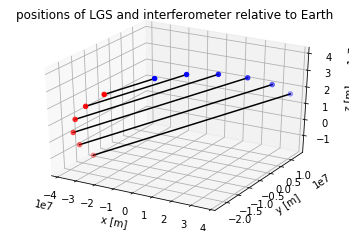

In [2]:
#initial positions for the LGS and the interferometer
r0_interferometer = np.array([36553680.122232765, 13110001.132682526, 16621226.943997538])
r0_lgs = np.array([-36553680.122232765, -13110001.132682526, -16621226.943997538])
v0_interferometer = np.array([-747.8642420733553, -1373.9962753573782, 2631.7475036829655])
v0_lgs = np.array([-719.9713170037995, -1351.544122384381, 2648.6823327646603])

#apply thust to LGS but not the interferometer
dvs_lgs = np.array([[11.524653064750597, -6.215470170245856, 1.898299503893403], [6.8605283843208875, -0.8992531997743181, -0.5925101261701045], [2.8045716870512862, 4.969053372497665, -2.839222921655394], [3.017857540283073, 4.3621928993323795, -7.473051036429393], [2.569021338974769, 4.713760397070592, -9.045308341484176]])
dvs_zero = np.zeros(dvs_lgs.shape)

#compute positiones at one-hour intervals
rs_interferometer = propagate_closed_loop_orbit(r0_interferometer, v0_interferometer, dvs_zero, n_minutes=60)
rs_lgs = propagate_closed_loop_orbit(r0_lgs, v0_lgs, dvs_lgs, n_minutes=60)

#plot the LGS, the interferometer and the line connecting them (pointing direction)
ax = plt.axes(projection='3d')

ax.scatter3D(*rs_interferometer.T, color="b")
ax.scatter3D(*rs_lgs.T, color="r")
print(rs_lgs.T.shape)
for i in range(len(rs_lgs)):
    ax.plot3D(*np.stack([rs_lgs[i],rs_interferometer[i]], axis=1), color="k")
ax.set_title("positions of LGS and interferometer relative to Earth")
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_zlabel("z [m]")

### Interferometer pointing
The interferometer is aligned by the LGS that is located tens of thousands of kilometers away. The line connecting between the two is the direction at which the interferometer is pointing at any given moment. We also define two perpendicular directions as follows:
1. a direction aligned with the initial velocity of the interferometer after projecting out the pointing direction
2. the remaining orthogonal direction

In [3]:
direction = (r0_lgs - r0_interferometer)/np.linalg.norm(r0_lgs - r0_interferometer)
perp_direction_1 = v0_interferometer - direction.dot(v0_interferometer)*direction
perp_direction_1 /= np.linalg.norm(perp_direction_1)
perp_direction_2 = np.cross(direction, perp_direction_1)

### Initial combiner and mirror positioning
Below we provide the initial positions of the combiner and the five cubesat-mirrors.

Text(0.5, 0, 'z [m]')

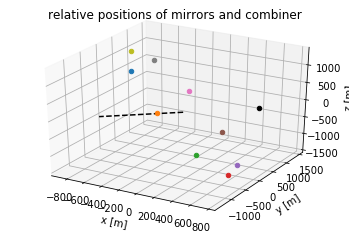

In [4]:
#initial positions of combiner and 9 mirrors
r0_combiner = r0_interferometer + [749.4224943295121, 268.7808646541089, 340.7679148465395]
v0_combiner = v0_interferometer + [0.014855606776677632, 0.028304829062108183, -0.05499614693189869]

r0_mirrors = r0_interferometer.reshape((-1,3)) + [[-350.3044986948371, -667.4455715138465, 1296.8435400072485], [159.18204107880592, -1321.2530439738184, 692.0631991308182], [594.1855347156525, -1356.8315330650657, -236.541204046458], [751.1630130335689, -757.5334683321416, -1054.4653489850461], [556.6629692986608, 196.22292527928948, -1378.9934380576015], [101.69413561373949, 1058.1644313782454, -1058.2751716580242], [-400.8585143312812, 1424.9790398478508, -242.37819102033973], [-715.8450103774667, 1125.030118694529, 686.9302389286458], [-695.879670329392, 298.6671016868204, 1294.8163757044822]]
v0_mirrors = v0_interferometer.reshape((-1,3)) + [[-0.09534384451353617, -0.034195131800288436, -0.04335354667637148], [-0.07303762227513744, -0.026194990697376852, -0.03321074352106734], [-0.016556284851503733, -0.005937922322118538, -0.007528264375650906], [0.047671922256768084, 0.017097565900257905, 0.02167677333818574], [0.08959390712664117, 0.03213291301949539, 0.04073900789671825], [0.08959390712664117, 0.03213291301949539, 0.04073900789671825], [0.047671922256768084, 0.017097565900257905, 0.02167677333818574], [-0.016556284851503733, -0.005937922322118538, -0.007528264375650906], [-0.07303762227513744, -0.026194990697376852, -0.03321074352106734]]

#plot mirrors, combiner and direction to star
ax = plt.axes(projection='3d')

ax.scatter3D(*(r0_combiner - r0_interferometer), color="k")
ax.plot3D(*np.stack([np.zeros(3), 1e3*direction], axis=1), color="k", linestyle="--")
for i_mirror in range(len(r0_mirrors)):
    ax.scatter3D(*(r0_mirrors[i_mirror] - r0_interferometer))
ax.set_title("relative positions of mirrors and combiner")
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_zlabel("z [m]")

### Open-loop drift due to the Sun
Here we propagate the positions of the combiner and the mirrors without applying any thrust. We plot optical path length from the star (which is in front of the LGS) to each mirror and then to the combine. The length is counted from the nominal position of interferometer, and it varies by several meters between the mirrors in open loop. The drift is due to the Sun acting slightly differently on each memeber of the formation.

We also plot how the mirrors appear to move when seen from the direction of the star (uv coverage).

/tmp/ipykernel_655013/3384014030.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
/tmp/ipykernel_655013/3384014030.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(122)


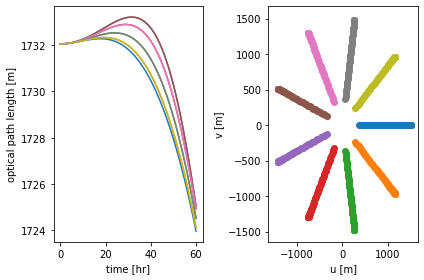

In [5]:
#propagate open-loop orbits for 5 hours at 5-minute intervals
dvs_zero = np.zeros((5*12,3))
rs_combiner = propagate_closed_loop_orbit(r0_combiner, v0_combiner, dvs_zero, n_minutes=5)
rs_interferometer = propagate_closed_loop_orbit(r0_interferometer, v0_interferometer, dvs_zero, n_minutes=5)

for i_mirror in range(len(r0_mirrors)):
    rs = propagate_closed_loop_orbit(r0_mirrors[i_mirror], v0_mirrors[i_mirror], dvs_zero, n_minutes=5)
    
    drs_nominal = rs - rs_interferometer #distance from nominal interferometer position to mirror
    drs_combiner = rs - rs_combiner #distance form combiner to mirror
    opl_1 = -drs_nominal.dot(direction) #(extra) OPL from star to mirror
    opl_2 = np.linalg.norm(drs_combiner, axis=1) #OPL from mirror to combiner
    plt.subplot(121)
    plt.ylabel("optical path length [m]")
    plt.xlabel("time [hr]")
    plt.plot(opl_1 + opl_2)
    
    u_disp = drs_nominal.dot(perp_direction_1) #mirror displacement in u direction as viewed from star
    v_disp = drs_nominal.dot(perp_direction_2) #mirror displacement in v direction as viewed from star
    plt.subplot(122)
    plt.scatter(u_disp, v_disp)
    plt.ylabel("v [m]")
    plt.xlabel("u [m]")
    
plt.tight_layout()

### Closing the loop on optical path length
We now introduce manuevers for the combiner and each of the mirrors to ensure the same optical path length. For simplicity, we only applied impulsive thrusts once an hour. The closed-loop optical path length differences are reduced from meters to millimeters.

/tmp/ipykernel_655013/4278641262.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
/tmp/ipykernel_655013/4278641262.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(122)


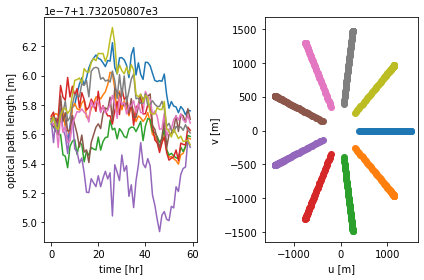

In [6]:
dvs_combiner = np.array([[2.3550881941329778e-05, 8.234645219156216e-06, 1.1297063012944664e-05], [4.5152397984874125e-05, 1.493418064399193e-05, 2.3954384154647618e-05], [4.2100563432031154e-05, 1.265765955332568e-05, 2.5743951081617603e-05], [3.8899608489147606e-05, 1.0428117745929434e-05, 2.719527437581107e-05], [3.557488850419017e-05, 8.260443156042414e-06, 2.8305311930489147e-05], [3.215349710479656e-05, 6.1687909936188685e-06, 2.9073567012982357e-05], [2.866173328800191e-05, 4.166900598695137e-06, 2.950113230227358e-05], [2.5126641015394434e-05, 2.267548922643852e-06, 2.9591521750464957e-05], [2.1574767591879365e-05, 4.828734904647077e-07, 2.9350074621338526e-05], [1.803283411645439e-05, -1.1758201362893734e-06, 2.8784352774910803e-05], [1.4527164358466664e-05, -2.6982104394808345e-06, 2.7903743359678636e-05], [1.1083523317435325e-05, -4.07488543460258e-06, 2.6719558147633048e-05], [7.727253796819316e-06, -5.297401662547871e-06, 2.5245058351899684e-05], [4.482792172993593e-06, -6.358430084199722e-06, 2.3495193898329814e-05], [1.3738794348350295e-06, -7.251669167021191e-06, 2.148687657073765e-05], [-1.5766994971697762e-06, -7.971947312955986e-06, 1.9238309490371364e-05], [-4.34735175814623e-06, -8.515288059825698e-06, 1.676944657969846e-05], [-6.917738582100247e-06, -8.878776575965594e-06, 1.410152069724405e-05], [-9.268551829667827e-06, -9.06080183151473e-06, 1.1257279531271213e-05], [-1.1382296226618507e-05, -9.060867192729367e-06, 8.260538659362834e-06], [-1.3242668509402987e-05, -8.879765849777077e-06, 5.136119386676353e-06], [-1.4835153496321533e-05, -8.519352619628957e-06, 1.9100971422330282e-06], [-1.614698671846682e-05, -7.982820252374782e-06, -1.391253975515457e-06], [-1.7166893822301697e-05, -7.274468931452007e-06, -4.740207123774416e-06], [-1.7885835443694638e-05, -6.399785423033749e-06, -8.109109921080039e-06], [-1.8296287076473828e-05, -5.365379837146654e-06, -1.1469825774021299e-05], [-1.839299657050365e-05, -4.178992415277119e-06, -1.4793597209690108e-05], [-1.817235069299206e-05, -2.849430475631125e-06, -1.80524118059917e-05], [-1.7633070719547706e-05, -1.3865152467611567e-06, -2.121731343333972e-05], [-1.6775889370132208e-05, 1.9891734051125463e-07, -2.426043864136308e-05], [-1.560324046855185e-05, 1.8951332750617224e-06, -2.7154172351698036e-05], [-1.4120004060332828e-05, 3.6894921107755103e-06, -2.987082496411551e-05], [-1.233291021292943e-05, 5.5685695803284215e-06, -3.238414723194514e-05], [-1.0250750219154849e-05, 7.518183220637971e-06, -3.466851075124633e-05], [-7.884165494896219e-06, 9.523479273795801e-06, -3.669918114936064e-05], [-5.245982839001659e-06, 1.1569018844965289e-05, -3.845254154957609e-05], [-2.350593522783356e-06, 1.363882289539394e-05, -3.9906514776695866e-05], [7.853760923215397e-07, 1.5716491763392587e-05, -4.1040339816098566e-05], [4.143995909190596e-06, 1.7785296751092798e-05, -4.183459671579539e-05], [7.705324267804385e-06, 1.9828198731355445e-05, -4.227162867762566e-05], [1.1447935729371817e-05, 2.182805613868376e-05, -4.233579042807992e-05], [1.5349107296267088e-05, 2.3767522512906502e-05, -4.201315024152476e-05], [1.9384421030729557e-05, 2.562947492878031e-05, -4.1291663718104675e-05], [2.3528465673061153e-05, 2.7396660051810978e-05, -4.016137252017146e-05], [2.775460071452526e-05, 2.9052203264284394e-05, -3.861480163283256e-05], [3.203513017120557e-05, 3.057944415191823e-05, -3.664618958909675e-05], [3.6341644127561825e-05, 3.1962138255755826e-05, -3.42523824412724e-05], [4.064486969238238e-05, 3.318454087411222e-05, -3.1432659924628676e-05], [4.4914975180494384e-05, 3.423141642212164e-05, -2.8188139493787556e-05], [4.9121871305986704e-05, 3.5088218424427634e-05, -2.452274478007769e-05], [5.323493171843075e-05, 3.57412882248787e-05, -2.044275858796917e-05], [5.722373186638111e-05, 3.617755073167003e-05, -1.595669878675493e-05], [6.10576143493112e-05, 3.638504218069393e-05, -1.1075516904922595e-05], [6.470638122729841e-05, 3.635271140713443e-05, -5.812821661737958e-06], [6.814007043259232e-05, 3.6070606198516824e-05, -1.836373480575563e-07], [7.132928645162439e-05, 3.552982966514038e-05, 5.7933613067865975e-06], [7.424546878392316e-05, 3.4722838466037836e-05, 1.2098729631867511e-05], [7.68607181122824e-05, 3.3643138390286694e-05, 1.870999331945055e-05], [7.914837139219617e-05, 3.228571283323237e-05, 2.5602467892344454e-05]])
dvs_mirrors = np.array([[[5.930793129112721e-06, 1.0678414899330589e-05, -2.02941801532427e-05], [1.3293814813356338e-05, 2.1381758064031125e-05, -3.8624687159190004e-05], [1.5307287908205947e-05, 2.1335819905558697e-05, -3.564635015556011e-05], [1.7138875803196988e-05, 2.118079921910142e-05, -3.263282696368015e-05], [1.878616968510762e-05, 2.0919222851432987e-05, -2.9594150334150447e-05], [2.024765477585777e-05, 2.055390943199293e-05, -2.65409242943252e-05], [2.1520971937457235e-05, 2.008788251874194e-05, -2.348320634050996e-05], [2.2605922562291526e-05, 1.9524513278230216e-05, -2.0431563278667295e-05], [2.3501190535094684e-05, 1.8867228797310136e-05, -1.7396276144449342e-05], [2.42072353135763e-05, 1.811981620253889e-05, -1.4387514345670738e-05], [2.472384587177608e-05, 1.7286258233314042e-05, -1.1415534109793585e-05], [2.5052114947168147e-05, 1.637061828956568e-05, -8.490492402644788e-06], [2.5193110420099375e-05, 1.5377381980502203e-05, -5.622310223037614e-06], [2.5148607950419018e-05, 1.431102246579888e-05, -2.820945847504895e-06], [2.4920693578105483e-05, 1.3176298500362534e-05, -9.589810070272461e-08], [2.451193764181501e-05, 1.1978164414528553e-05, 2.543098251417202e-06], [2.3925469208478734e-05, 1.072166143626305e-05, 5.0867554491839466e-06], [2.316469049560847e-05, 9.412017044804139e-06, 7.526108593995184e-06], [2.2233674273153427e-05, 8.054635671562921e-06, 9.852056161430571e-06], [2.113667949857656e-05, 6.6550583214045895e-06, 1.2056204428325877e-05], [1.9878548751293786e-05, 5.21883995519998e-06, 1.4130209316697262e-05], [1.84645840468653e-05, 3.7517963092234916e-06, 1.6065863320778757e-05], [1.6900348097271982e-05, 2.2597756967865928e-06, 1.7855679138511705e-05], [1.5191925160349479e-05, 7.486706618344661e-07, 1.9492169442562096e-05], [1.3345858893853416e-05, -7.754640474978229e-07, 2.0968405659452054e-05], [1.1368804698683319e-05, -2.3065833944716946e-06, 2.227773241066188e-05], [9.268100916627217e-06, -3.838554061921485e-06, 2.3413879202646875e-05], [7.051296941822261e-06, -5.365218824125948e-06, 2.4371134310171198e-05], [4.726302281229553e-06, -6.880398144885532e-06, 2.5143997088719685e-05], [2.30118782936369e-06, -8.377905212824638e-06, 2.572755049993091e-05], [-2.1526772079065315e-07, -9.851554381273306e-06, 2.6117150632479642e-05], [-2.8142360847724527e-06, -1.1295177219939911e-05, 2.6309146924749566e-05], [-5.486888913908633e-06, -1.2702648375039522e-05, 2.6299566030257587e-05], [-8.223565979761455e-06, -1.4067870422435184e-05, 2.6085701022929503e-05], [-1.1014669088109487e-05, -1.538483985153966e-05, 2.566469602545396e-05], [-1.3850575281599616e-05, -1.6647582629420344e-05, 2.5034614009037568e-05], [-1.6720991076908745e-05, -1.785026906718914e-05, 2.4194312545817768e-05], [-1.961592092628245e-05, -1.898711761227823e-05, 2.3142003637666943e-05], [-2.25248913757017e-05, -2.005251740425673e-05, 2.1878183848225404e-05], [-2.543736052192534e-05, -2.1040921251667168e-05, 2.04021826576625e-05], [-2.834283004878525e-05, -2.19470333864683e-05, 1.8715043005051353e-05], [-3.1230559450842414e-05, -2.2765589074459286e-05, 1.6817882337694836e-05], [-3.40897709887112e-05, -2.34916060749094e-05, 1.4712488596472372e-05], [-3.6909680699177094e-05, -2.4120213892662106e-05, 1.2400997406087887e-05], [-3.967951086200956e-05, -2.4646777935648985e-05, 9.886512865464525e-06], [-4.238839058919633e-05, -2.5066887132597045e-05, 7.172288086953349e-06], [-4.502561664065085e-05, -2.5376313546361623e-05, 4.262221855051417e-06], [-4.758046714967901e-05, -2.5571021681791575e-05, 1.1609331067676956e-06], [-5.004234751742483e-05, -2.564739824534583e-05, -2.1266115523787335e-06], [-5.240072211744948e-05, -2.5601923032846632e-05, -5.594750188242082e-06], [-5.464528193323247e-05, -2.5431367646774665e-05, -9.237473187914107e-06], [-5.676574897031358e-05, -2.5132814107527298e-05, -1.3048274278851878e-05], [-5.875220845810352e-05, -2.4703642411506163e-05, -1.701972837635615e-05], [-6.059478903200111e-05, -2.414152439408771e-05, -2.1144683522561454e-05], [-6.228397945131736e-05, -2.3444367737702273e-05, -2.54146468043899e-05], [-6.381050126365179e-05, -2.2610483715717016e-05, -2.9821249449144762e-05], [-6.516529407445498e-05, -2.1638444352453804e-05, -3.435577500923599e-05], [-6.633970725707443e-05, -2.0527218948857554e-05, -3.9008190931950436e-05], [-6.732538656235459e-05, -1.9275969331245202e-05, -4.376930890006926e-05]], [[-2.2275304799871872e-06, 2.0964309469429366e-05, -1.0793656172765054e-05], [-2.984410782597418e-06, 4.1240618435545014e-05, -2.0346550673572972e-05], [-8.724635316512019e-07, 4.012691618023206e-05, -1.8467023191315704e-05], [1.1121357865536458e-06, 3.890746212806753e-05, -1.6568687845951375e-05], [2.9661835466322727e-06, 3.75862175716988e-05, -1.4658696586687684e-05], [4.6871217522859775e-06, 3.616759702363984e-05, -1.274405237840262e-05], [6.272839440501313e-06, 3.46559280465506e-05, -1.0831932038051989e-05], [7.721026971791817e-06, 3.305611566019821e-05, -8.92956200936937e-06], [9.030392851642972e-06, 3.13729406377695e-05, -7.043783840907104e-06], [1.0199235865691953e-05, 2.961159979018534e-05, -5.181786710936585e-06], [1.122692261690692e-05, 2.7777401634140725e-05, -3.350511516111858e-06], [1.2112707953293243e-05, 2.5875803706577905e-05, -1.5567749327651644e-06], [1.2856281320070729e-05, 2.3912480843618646e-05, 1.925690947113121e-07], [1.3457592901228154e-05, 2.1893263094311645e-05, 1.8908528941524865e-06], [1.3917325482613684e-05, 1.9824095347920266e-05, 3.531445995260971e-06], [1.4236037644377931e-05, 1.7711055981459675e-05, 5.108127751729227e-06], [1.441477225966097e-05, 1.5560406532228447e-05, 6.614453980188391e-06], [1.4455230292601793e-05, 1.3378451974629243e-05, 8.04421638733128e-06], [1.4359000904556636e-05, 1.1171605934247136e-05, 9.391703415631095e-06], [1.4128269309725815e-05, 8.946451225641667e-06, 1.0651029628977191e-05], [1.3765580775261751e-05, 6.709489922654762e-06, 1.1816818686564484e-05], [1.3273704107038853e-05, 4.467422792697244e-06, 1.2883557666690377e-05], [1.2655842658508751e-05, 2.226938164782626e-06, 1.3846329645121664e-05], [1.1915398476503259e-05, -5.246919013257946e-09, 1.4700217708683412e-05], [1.105629509727246e-05, -2.2223781728694515e-06, 1.5440764339778276e-05], [1.0082518160940434e-05, -4.417710240827165e-06, 1.6063512047698827e-05], [8.998698960378633e-06, -6.584494089590167e-06, 1.6564624135288464e-05], [7.809357061366067e-06, -8.716029196336469e-06, 1.6940164620958484e-05], [6.519694893713768e-06, -1.0805621641776282e-05, 1.7187215637193235e-05], [5.1348156841641695e-06, -1.2846656284665715e-05, 1.7301853618600405e-05], [3.6605799280777354e-06, -1.4832563972402622e-05, 1.728214159458328e-05], [2.102550237347158e-06, -1.6756883828339437e-05, 1.7125074835443465e-05], [4.6702176679641226e-07, -1.8613233357204392e-05, 1.6828815711874707e-05], [-1.2397724209058883e-06, -2.0395324753670086e-05, 1.6391725289194225e-05], [-3.011288780408821e-06, -2.2097040965566987e-05, 1.5812040467082234e-05], [-4.840685835364888e-06, -2.371237513690411e-05, 1.5089165276690143e-05], [-6.721059955013242e-06, -2.52354601184635e-05, 1.4222156112273843e-05], [-8.64520953169265e-06, -2.6660625892018503e-05, 1.3210789507420094e-05], [-1.0605982648725357e-05, -2.798239025396694e-05, 1.2055338672071914e-05], [-1.2595625065473162e-05, -2.9195398284542964e-05, 1.0755878128890008e-05], [-1.4606811072098557e-05, -3.029458996650657e-05, 9.313897895775378e-06], [-1.663166844246146e-05, -3.1275072952533535e-05, 7.729894681703645e-06], [-1.8662492725549328e-05, -3.213220320112943e-05, 6.006227635685941e-06], [-2.0691200608743995e-05, -3.286157574860896e-05, 4.144337113968401e-06], [-2.2710056565664663e-05, -3.345905257823308e-05, 2.1469796112414935e-06], [-2.4710778623646866e-05, -3.392074713496376e-05, 1.686193800053558e-08], [-2.6685593962742152e-05, -3.4243073997479765e-05, -2.2429365674967585e-06], [-2.862625164563995e-05, -3.442268676408537e-05, -4.628914436399043e-06], [-3.05247677302773e-05, -3.445661776841721e-05, -7.137048705135036e-06], [-3.23731489477023e-05, -3.434214767887374e-05, -9.7628694238015e-06], [-3.4163411295261824e-05, -3.4076861421648474e-05, -1.2502154946281984e-05], [-3.588758941142811e-05, -3.365868536015346e-05, -1.5349640678142427e-05], [-3.7537956952794326e-05, -3.308594944807403e-05, -1.8300012349000373e-05], [-3.9106762707852714e-05, -3.23572195647379e-05, -2.1347781849776142e-05], [-4.0586435512568026e-05, -3.147135336745451e-05, -2.4486740932997223e-05], [-4.1969472466963696e-05, -3.042782320413234e-05, -2.77105820286762e-05], [-4.324867410749992e-05, -2.9226126247761297e-05, -3.1012923037964e-05], [-4.441689915474114e-05, -2.7866268752269134e-05, -3.438663690916058e-05], [-4.5467256491121965e-05, -2.6348685409243182e-05, -3.782469591361899e-05]], [[-9.369172332792703e-06, 2.1431671172661948e-05, 3.7455329495022714e-06], [-1.7917288241725713e-05, 4.178473170287833e-05, 7.427465280566292e-06], [-1.669464748167653e-05, 4.012498705211976e-05, 7.3277319187055955e-06], [-1.5485414824586273e-05, 3.841232285316447e-05, 7.221489679110096e-06], [-1.4291800690209611e-05, 3.66503280237641e-05, 7.108192407142597e-06], [-1.3115816843011895e-05, 3.484277774514685e-05, 6.987331186166577e-06], [-1.1959450193458035e-05, 3.29935527597599e-05, 6.858123910465042e-06], [-1.0824787033184706e-05, 3.110649654485666e-05, 6.7203224634015916e-06], [-9.713690118340358e-06, 2.918577545719658e-05, 6.573206827989094e-06], [-8.627885643740296e-06, 2.7235319890660713e-05, 6.416404686881427e-06], [-7.569435057384735e-06, 2.525948558500088e-05, 6.249394743130337e-06], [-6.5397292978009e-06, 2.3262376779171822e-05, 6.071742567518368e-06], [-5.540792570068487e-06, 2.1248420614590995e-05, 5.883013800931829e-06], [-4.573966150121057e-06, 1.9221845511990538e-05, 5.6828236935016454e-06], [-3.6407527571286334e-06, 1.718711894919009e-05, 5.470961358756672e-06], [-2.7429406657320512e-06, 1.5148658744922344e-05, 5.246942771291994e-06], [-1.8813620594824247e-06, 1.3110901314800057e-05, 5.010445230484882e-06], [-1.0577928521833784e-06, 1.1078270672836671e-05, 4.761481419869296e-06], [-2.730527741170638e-07, 9.055321218804564e-06, 4.499467889549523e-06], [4.716161919569938e-07, 7.046456772733893e-06, 4.224479363364505e-06], [1.175071434392486e-06, 5.056119966236543e-06, 3.9363049650469375e-06], [1.836654607870276e-06, 3.0887953349331726e-06, 3.634795854231518e-06], [2.4554217669929045e-06, 1.1488742787145777e-06, 3.319877737151594e-06], [3.0305531379681536e-06, -7.592937178810133e-07, 2.9915011478529627e-06], [3.561675949462915e-06, -2.6313646089050033e-06, 2.6498400779866655e-06], [4.047970454277519e-06, -4.463071569531633e-06, 2.2946712426137553e-06], [4.489324645623338e-06, -6.250221129610387e-06, 1.9262679542005987e-06], [4.88522918498267e-06, -7.98867278938268e-06, 1.5446924940377814e-06], [5.23550999143055e-06, -9.674381128841568e-06, 1.1501809456851328e-06], [5.540142020887463e-06, -1.1303379897251291e-05, 7.427831346358419e-07], [5.798963573936868e-06, -1.287181732506935e-05, 3.2312006972714267e-07], [6.0123718664572975e-06, -1.4375929547290855e-05, -1.092054484111317e-07], [6.1802299758975844e-06, -1.5812079591187414e-05, -5.529764127461664e-07], [6.303096557077776e-06, -1.717674614271693e-05, -1.0085900232188192e-06], [6.381368688143834e-06, -1.84665452532634e-05, -1.4750528200275544e-06], [6.4155428956589595e-06, -1.9678228038347222e-05, -1.952339824069183e-06], [6.406202535522755e-06, -2.0808688408487297e-05, -2.4394327580538776e-06], [6.354154593892343e-06, -2.1854984839127856e-05, -2.9363563277396055e-06], [6.260243222365731e-06, -2.2814290654306164e-05, -3.4421667720887525e-06], [6.125442991602335e-06, -2.3684050837750553e-05, -3.956168668564277e-06], [5.95058570514399e-06, -2.4461738329641005e-05, -4.478113555453233e-06], [5.737037070797333e-06, -2.5145089926376303e-05, -5.00678456269308e-06], [5.485889661467203e-06, -2.5732062880576855e-05, -5.54170976356541e-06], [5.198465761727314e-06, -2.622072308921849e-05, -6.082019934278869e-06], [4.876211854668388e-06, -2.660931031249706e-05, -6.626994850986091e-06], [4.520605447012083e-06, -2.689645547471405e-05, -7.175541823713866e-06], [4.133130299016555e-06, -2.70807150175453e-05, -7.727139287915954e-06], [3.715549541279899e-06, -2.7161008576764265e-05, -8.280471086335944e-06], [3.2694431780454947e-06, -2.713651661961665e-05, -8.834966012784957e-06], [2.796695423550848e-06, -2.7006543731674647e-05, -9.389034775025076e-06], [2.2991346821552132e-06, -2.677055602413488e-05, -9.942503491512442e-06], [1.7786700122666477e-06, -2.6428379647550188e-05, -1.0493633895707901e-05], [1.2372322572199728e-06, -2.5979989830153012e-05, -1.104168099866471e-05], [6.769136897307975e-07, -2.5425579087904844e-05, -1.1585403184232708e-05], [9.971657032093707e-08, -2.476551383276362e-05, -1.2124080309621484e-05], [-4.922140422640506e-07, -2.4000520537753615e-05, -1.265602381316192e-05], [-1.0967113244652157e-06, -2.313140644663137e-05, -1.3180339748538585e-05], [-1.7116127212344908e-06, -2.2159252004211687e-05, -1.3696059685535417e-05], [-2.334706817281925e-06, -2.1085385983931915e-05, -1.4201768235653667e-05]], [[-1.2152570555484567e-05, 1.1861783981220387e-05, 1.652027377397989e-05], [-2.4517520357344672e-05, 2.2759460465288657e-05, 3.170166496350791e-05], [-2.4756054867687662e-05, 2.1330796854879462e-05, 2.9668239684352123e-05], [-2.4887875038411668e-05, 1.992682618080299e-05, 2.7606019649758125e-05], [-2.4913005959101085e-05, 1.854906986911074e-05, 2.5521275485810625e-05], [-2.4832093553477904e-05, 1.719898729188736e-05, 2.3420265422149963e-05], [-2.464588306591467e-05, 1.5877901237941508e-05, 2.1309185595039756e-05], [-2.4355641273330065e-05, 1.4587221443966287e-05, 1.9194356334092004e-05], [-2.3962262440140158e-05, 1.33281279033579e-05, 1.7082048247712768e-05], [-2.3467659019145476e-05, 1.2101856537450951e-05, 1.4978569271514832e-05], [-2.2873370944143162e-05, 1.0909404209482664e-05, 1.2890115527449449e-05], [-2.218158384064505e-05, 9.75188267956547e-06, 1.0822895592699103e-05], [-2.139425982940517e-05, 8.630152235603984e-06, 8.783155255660438e-06], [-2.051426744577393e-05, 7.545144613111631e-06, 6.776867195446954e-06], [-1.954413999873052e-05, 6.497540060715437e-06, 4.810239965736524e-06], [-1.8486907418130628e-05, 5.488077849655997e-06, 2.888923369399607e-06], [-1.7345612120768804e-05, 4.517348221750224e-06, 1.0191135536952896e-06], [-1.6123904871172696e-05, 3.5858048522817116e-06, -7.937879911549574e-07], [-1.4825175729751313e-05, 2.6939603950696307e-06, -2.544032145719143e-06], [-1.3453336237274153e-05, 1.8420651855206946e-06, -4.226192594105337e-06], [-1.2012521450595874e-05, 1.0303773278415829e-06, -5.834917518837511e-06], [-1.0506754635167152e-05, 2.5905093053393327e-07, -7.365215231804664e-06], [-8.940543352974222e-06, -4.718390581333578e-07, -8.811969836289274e-06], [-7.318506887705327e-06, -1.1623527325962783e-06, -1.017045036868633e-05], [-5.645351439015838e-06, -1.8126014082085406e-06, -1.1436062462179857e-05], [-3.925957013900404e-06, -2.4227844874804727e-06, -1.2604596670001102e-05], [-2.165563764642202e-06, -2.9932127490794296e-06, -1.3671632437748398e-05], [-3.690764794397416e-07, -3.524275698359766e-06, -1.4633630859863134e-05], [1.4578176478651525e-06, -4.016437543833009e-06, -1.548628312339717e-05], [3.309977977552428e-06, -4.470254177587837e-06, -1.622698157911226e-05], [5.181543501775199e-06, -4.886372106419653e-06, -1.685197618792497e-05], [7.067100368445994e-06, -5.2655204538244445e-06, -1.73586841349106e-05], [8.960626201751969e-06, -5.608477237281265e-06, -1.7744174896254e-05], [1.0856607838048648e-05, -5.916153985675446e-06, -1.800643684140756e-05], [1.2748737330012347e-05, -6.18946765789841e-06, -1.814320994269994e-05], [1.4631501551789147e-05, -6.429478043271841e-06, -1.815315308814041e-05], [1.6498542843260553e-05, -6.6372526723545e-06, -1.8033906959963615e-05], [1.8344087404870348e-05, -6.81398486714154e-06, -1.7785545909496193e-05], [2.0161988705612504e-05, -6.960860150422023e-06, -1.740630666307888e-05], [2.194623075692043e-05, -7.079188278839941e-06, -1.6896313246325125e-05], [2.3690828538346518e-05, -7.170306936262166e-06, -1.625504406571829e-05], [2.5389772229347386e-05, -7.235622128718791e-06, -1.548257351532382e-05], [2.703710793740444e-05, -7.2765430023573315e-06, -1.4579845142143388e-05], [2.8626949995234632e-05, -7.2945811298665546e-06, -1.354710721939517e-05], [3.0153474913417688e-05, -7.291291614004262e-06, -1.2386048304082401e-05], [3.1610952263949515e-05, -7.268186063169081e-06, -1.1097612017594612e-05], [3.299368893076378e-05, -7.226915849395429e-06, -9.683909108537062e-06], [3.4296153212128224e-05, -7.169051630419109e-06, -8.147050350690799e-06], [3.551296551901313e-05, -7.096337939605076e-06, -6.4893700433051215e-06], [3.663878662966188e-05, -7.010326856488544e-06, -4.713748795326163e-06], [3.766851324664338e-05, -6.9128126214878224e-06, -2.8230175987846168e-06], [3.859717558520898e-05, -6.805428098661545e-06, -8.209510679365585e-07], [3.9419928004252466e-05, -6.689893061481328e-06, 1.289073458537713e-06], [4.0132213596166885e-05, -6.567939760394613e-06, 3.5028591624426495e-06], [4.072953441525324e-05, -6.441232158348424e-06, 5.816109878796939e-06], [4.120776349686575e-05, -6.311459064645866e-06, 8.224454916223868e-06], [4.1562870106861385e-05, -6.18031556086079e-06, 1.0722778604586832e-05], [4.179112035825783e-05, -6.04951534448707e-06, 1.3306213560898716e-05], [4.188899621641682e-05, -5.920573496806879e-06, 1.5968973616842513e-05]], [[-9.275252663298092e-06, -3.267470890652574e-06, 2.1553166115968263e-05], [-1.969669682479265e-05, -6.933146694827352e-06, 4.111784160374375e-05], [-2.1284807625839162e-05, -7.461670584906037e-06, 3.8101044759231504e-05], [-2.269547773761995e-05, -7.899503104871125e-06, 3.504675132141627e-05], [-2.3927316606382573e-05, -8.247811270999302e-06, 3.196488238466251e-05], [-2.497895854007109e-05, -8.508202950354141e-06, 2.8865756384907855e-05], [-2.584978283121476e-05, -8.68237288790173e-06, 2.5759418584538777e-05], [-2.653921845295603e-05, -8.772264185176317e-06, 2.2656050807673533e-05], [-2.7047538724837605e-05, -8.779906824107675e-06, 1.9565797663452983e-05], [-2.737501696245981e-05, -8.707753006451741e-06, 1.64988533920596e-05], [-2.7522559715221892e-05, -8.558171055141595e-06, 1.3465052141204161e-05], [-2.7491830998464056e-05, -8.333926665676125e-06, 1.0474563377227997e-05], [-2.7284283698749068e-05, -8.037884861898104e-06, 7.5370722140519845e-06], [-2.6902314401162024e-05, -7.673090696434627e-06, 4.6623755863947705e-06], [-2.6348642531250362e-05, -7.242707176756178e-06, 1.860121411222546e-06], [-2.5626223399353475e-05, -6.750186015842462e-06, -8.604149260460487e-07], [-2.4738695277710245e-05, -6.199022367942143e-06, -3.4898586664126876e-06], [-2.3689969564560308e-05, -5.592910057009558e-06, -6.019356587554446e-06], [-2.2484355039137396e-05, -4.935695024243142e-06, -8.439881619053326e-06], [-2.112659500871061e-05, -4.2312899255904195e-06, -1.0743139294033707e-05], [-1.9622028827226982e-05, -3.4838449121167646e-06, -1.2920773027225905e-05], [-1.797597100381231e-05, -2.697545824693999e-06, -1.496467462116742e-05], [-1.6194431357849787e-05, -1.8766824854280113e-06, -1.686731943384682e-05], [-1.4283941242960355e-05, -1.0257302101948033e-06, -1.8621344221299464e-05], [-1.2250758819129834e-05, -1.491317071738198e-07, -2.0219596899342098e-05], [-1.010222249778278e-05, 7.484599916278043e-07, -2.1655657887071564e-05], [-7.845509285425024e-06, 1.6624250386647527e-06, -2.2923082829703932e-05], [-5.488429435564464e-06, 2.5880164984595064e-06, -2.401604817408488e-05], [-3.0388180104704577e-06, 3.520475020241401e-06, -2.4929140149346143e-05], [-5.049446817254583e-07, 4.45496635417691e-06, -2.56571933102058e-05], [2.1044242443816137e-06, 5.386676238045556e-06, -2.6195936183867586e-05], [4.780870102965767e-06, 6.310709883343772e-06, -2.6540824207840913e-05], [7.514931237858319e-06, 7.222219448378452e-06, -2.668847989191765e-05], [1.0297717193965469e-05, 8.116336910286383e-06, -2.6635625177873657e-05], [1.3119517953005375e-05, 8.988201228955426e-06, -2.6379329610997648e-05], [1.597076018706819e-05, 9.833022738245901e-06, -2.5917978918859818e-05], [1.8841671777199147e-05, 1.0645969878562508e-05, -2.5249114537340514e-05], [2.1722257232474677e-05, 1.1422369383551856e-05, -2.4372190015644305e-05], [2.4602390602110338e-05, 1.2157484339845823e-05, -2.328628643693543e-05], [2.747205153063546e-05, 1.2846788929079292e-05, -2.1991254730049344e-05], [3.0320797473390202e-05, 1.3485729361756177e-05, -2.048766595592489e-05], [3.313846526818415e-05, 1.4069910177955959e-05, -1.8776165726377738e-05], [3.5914649656209364e-05, 1.4595029012143418e-05, -1.6858566773590605e-05], [3.863906952448644e-05, 1.5056873518667526e-05, -1.4736706706542262e-05], [4.1301269927790084e-05, 1.5451445536689293e-05, -1.2413217768364249e-05], [4.3891168459971806e-05, 1.577476861409353e-05, -9.891154409066463e-06], [4.639833500320535e-05, 1.602313635531502e-05, -7.17424153959064e-06], [4.881278027563229e-05, 1.6192947904594187e-05, -4.266551774872093e-06], [5.1124412540500635e-05, 1.6280738957144132e-05, -1.1728778785349572e-06], [5.332336356818057e-05, 1.628334322992858e-05, 2.101664541045193e-06], [5.5399904826498594e-05, 1.619761922174949e-05, 5.551214877352531e-06], [5.734455922332292e-05, 1.602079175482874e-05, 9.169689014165277e-06], [5.914790553367622e-05, 1.5750259443325462e-05, 1.2950158520187297e-05], [6.080091057116059e-05, 1.5383476761974085e-05, 1.688547143372424e-05], [6.229469634172515e-05, 1.4918425936225123e-05, 2.096820263281451e-05], [6.362073720428438e-05, 1.4352971122813633e-05, 2.5189735012972716e-05], [6.477076591623849e-05, 1.3685603618564183e-05, 2.9541823942940247e-05], [6.573683031555317e-05, 1.2914640797184763e-05, 3.401550461185116e-05], [6.651135415227624e-05, 1.2039064334350163e-05, 3.8600967926914275e-05]], [[-2.083556840288437e-06, -1.6876949955869808e-05, 1.648924967256465e-05], [-5.710675209647417e-06, -3.339948225208443e-05, 3.126998582027343e-05], [-7.904590281773878e-06, -3.2780049110357106e-05, 2.8680438514370147e-05], [-9.933682026818254e-06, -3.204616142196951e-05, 2.6062087715140885e-05], [-1.1795342874807014e-05, -3.12014512946192e-05, 2.3424171493024383e-05], [-1.3486741793531251e-05, -3.0249612936251085e-05, 2.0776114117765594e-05], [-1.5006314221377997e-05, -2.9194719234785514e-05, 1.8127178503942643e-05], [-1.6352123102919106e-05, -2.8040967272113327e-05, 1.5486577817307504e-05], [-1.752305089389305e-05, -2.679293284730166e-05, 1.2863674277242619e-05], [-1.8518513964648688e-05, -2.54552600248697e-05, 1.0267656264969829e-05], [-1.933786658604297e-05, -2.403296851797916e-05, 7.707575523866734e-06], [-1.9981369472628355e-05, -2.253108731096689e-05, 5.192508678029789e-06], [-2.0449370250534964e-05, -2.0955033450526127e-05, 2.731495075569151e-06], [-2.074298636013708e-05, -1.931032639354275e-05, 3.331767439783811e-07], [-2.0863422187963683e-05, -1.7602615983410572e-05, -1.9936801487547018e-06], [-2.0812577449428924e-05, -1.583779108621059e-05, -4.240532907007239e-06], [-2.0592550491987893e-05, -1.4021889568659879e-05, -6.399310716509788e-06], [-2.0206048151620626e-05, -1.2161020686325514e-05, -8.461582628681592e-06], [-1.965618694642681e-05, -1.0261507886367762e-05, -1.04197372301385e-05], [-1.894629451895444e-05, -8.329719623324529e-06, -1.2266026531954555e-05], [-1.808036899881718e-05, -6.37222457651686e-06, -1.399311227148915e-05], [-1.7062681695367442e-05, -4.395551051598105e-06, -1.5593854870560694e-05], [-1.5897863975921276e-05, -2.4064244847793146e-06, -1.706159900982157e-05], [-1.4591155690081571e-05, -4.115687462019477e-07, -1.838955275192147e-05], [-1.31477841693247e-05, 1.582234092553175e-06, -1.9571954806690437e-05], [-1.1573759105762367e-05, 3.5681359945341404e-06, -2.060265890412461e-05], [-9.875239119650714e-06, 5.539321726040218e-06, -2.1476412807730354e-05], [-8.058780195320241e-06, 7.4889086736876e-06, -2.2188125693072675e-05], [-6.131161836147748e-06, 9.410070697129567e-06, -2.273285574589191e-05], [-4.099771921032501e-06, 1.129597088892719e-05, -2.310662961686324e-05], [-1.971911405470449e-06, 1.313985732358597e-05, -2.33057471729043e-05], [2.4436121802401997e-07, 1.493496581216957e-05, -2.332616056193926e-05], [2.5411117562399e-06, 1.66746602203494e-05, -2.3165187804814332e-05], [4.9100334921115165e-06, 1.835235485400021e-05, -2.2820519405394646e-05], [7.342198772770702e-06, 1.996159441514183e-05, -2.228969683817992e-05], [9.829300917082873e-06, 2.1495973266340896e-05, -2.1571254986890656e-05], [1.2361729356444976e-05, 2.2949324806109397e-05, -2.0664026626426708e-05], [1.4930631035372984e-05, 2.431549640335354e-05, -1.956729162250931e-05], [1.752648234991064e-05, 2.5588600846478453e-05, -1.828092578669144e-05], [2.01396541521964e-05, 2.6762864228492232e-05, -1.6805251934406875e-05], [2.2760573175490004e-05, 2.78327454713155e-05, -1.5141015063800967e-05], [2.5379355721971856e-05, 2.8792846282238228e-05, -1.3289556146390099e-05], [2.7986105670777463e-05, 2.9638041560279747e-05, -1.1252613495336369e-05], [3.0570951753360456e-05, 3.036340797147368e-05, -9.032571087879927e-06], [3.312376190982616e-05, 3.096424568644556e-05, -6.632259880505147e-06], [3.5634714524905577e-05, 3.143618395337673e-05, -4.054759194839608e-06], [3.8093646496370716e-05, 3.177497925370341e-05, -1.3041168044653278e-06], [4.049061822612659e-05, 3.197689410708159e-05, 1.6154953317176988e-06], [4.2815683897276005e-05, 3.203814753109373e-05, 4.69928442397831e-06], [4.5059062213845834e-05, 3.195564774074697e-05, 7.94218452039268e-06], [4.7210891155556145e-05, 3.172625321810894e-05, 1.1338235689358682e-05], [4.926161602422126e-05, 3.13474681853618e-05, 1.4881328998088332e-05], [5.1201706919937e-05, 3.081681546054359e-05, 1.8565007828444404e-05], [5.302187919818346e-05, 3.0132395247813857e-05, 2.2381921608975585e-05], [5.4712970795443634e-05, 2.9292500230968867e-05, 2.6324769404839222e-05], [5.6266116092122284e-05, 2.82959135843001e-05, 3.038592744792764e-05], [5.7672640388116585e-05, 2.714160464832712e-05, 3.45564558595504e-05], [5.8924118830999986e-05, 2.5829045754895376e-05, 3.882818453457881e-05], [6.0012469300078e-05, 2.4358063064005057e-05, 4.31919252481488e-05]], [[6.057444171922789e-06, -2.2598633092538635e-05, 3.6979477490054474e-06], [1.0896429441910184e-05, -4.4255628955037305e-05, 6.766176452535048e-06], [9.123551831975095e-06, -4.2777401845689754e-05, 5.814336819494411e-06], [7.426043729444461e-06, -4.121461130390557e-05, 4.85613056398818e-06], [5.806214865897099e-06, -3.9571411151808276e-05, 3.89551852046982e-06], [4.267070273444417e-06, -3.785197387764961e-05, 2.9366477040989455e-06], [2.8107209929629506e-06, -3.606087552018591e-05, 1.9837893728099176e-06], [1.4390049365889405e-06, -3.4202617576341414e-05, 1.0407180723140885e-06], [1.5415730270001016e-07, -3.228206791817648e-05, 1.117298403840302e-07], [-1.042368932940721e-06, -3.0304063320381524e-05, -7.99202094873075e-07], [-2.1491331927069765e-06, -2.8273723071488452e-05, -1.688290787042385e-06], [-3.1646080160143187e-06, -2.6196181989188962e-05, -2.551463716857502e-06], [-4.088010924961274e-06, -2.4076820119309593e-05, -3.3848842402064808e-06], [-4.918422844831308e-06, -2.1920955409872788e-05, -4.184902014878585e-06], [-5.6553593086485395e-06, -1.9734206947529142e-05, -4.9477176584349755e-06], [-6.2984972616370374e-06, -1.7522094457098446e-05, -5.669705640981382e-06], [-6.8474391134649785e-06, -1.529034877089052e-05, -6.3475384777708715e-06], [-7.302693744678811e-06, -1.3044728641709275e-05, -6.977714757061088e-06], [-7.664223674590788e-06, -1.079098661964928e-05, -7.556907000094557e-06], [-7.932810918208174e-06, -8.535028907744507e-06, -8.082110495824267e-06], [-8.109274778227268e-06, -6.2827244568210805e-06, -8.550109463381733e-06], [-8.194471760104778e-06, -4.0399716996462525e-06, -8.958172405075448e-06], [-8.189779906922686e-06, -1.8126721650280651e-06, -9.303530531484216e-06], [-8.09677593024055e-06, 3.9323536590062246e-07, -9.583588890458815e-06], [-7.916912366358426e-06, 2.5718773133048815e-06, -9.79583948390208e-06], [-7.652349511262343e-06, 4.717367688286191e-06, -9.938146757673443e-06], [-7.3052228257621146e-06, 6.823899474481771e-06, -1.0008486933918135e-05], [-6.8776677968953976e-06, 8.88567026852872e-06, -1.0004687253492018e-05], [-6.372515239381172e-06, 1.0896988855516348e-05, -9.925170900278462e-06], [-5.792521439654158e-06, 1.2852200202836402e-05, -9.768696335805845e-06], [-5.140517270802125e-06, 1.474577424805417e-05, -9.533376368908377e-06], [-4.419805351257151e-06, 1.657224839604745e-05, -9.218615097467705e-06], [-3.633762915579094e-06, 1.8326297051340557e-05, -8.822922642181116e-06], [-2.7857794710444593e-06, 2.0002711025347472e-05, -8.34629911231755e-06], [-1.8798407248331335e-06, 2.1596417744998832e-05, -7.78752776409304e-06], [-9.196466322245744e-07, 2.3102475011279022e-05, -7.146881866301097e-06], [9.073021463065845e-08, 2.4516154855835024e-05, -6.423790353024944e-06], [1.1470683274460467e-06, 2.5832830177657754e-05, -5.619097613122034e-06], [2.24487908036367e-06, 2.7048100545227068e-05, -4.7322077457161204e-06], [3.3800155355863585e-06, 2.815774398714437e-05, -3.7647598055537746e-06], [4.547523427394448e-06, 2.915774967368655e-05, -2.7169525139643877e-06], [5.742914236605767e-06, 3.0044283718577094e-05, -1.5898786078541506e-06], [6.96126482080738e-06, 3.081381646547189e-05, -3.8502810923193633e-07], [8.197726518990576e-06, 3.146293933953484e-05, 8.962082683831048e-07], [9.447307880025615e-06, 3.198858835408943e-05, 2.251943177827916e-06], [1.0704905643032265e-05, 3.238785166197839e-05, 3.6806617449837097e-06], [1.1965404184979522e-05, 3.265814955538621e-05, 5.179731656315133e-06], [1.3223762354020195e-05, 3.279720968912887e-05, 6.746768912366325e-06], [1.4474609884487618e-05, 3.2802772134212635e-05, 8.379464006502033e-06], [1.5712874564742604e-05, 3.267326615931441e-05, 1.0075010795921929e-05], [1.693323270982339e-05, 3.2406959548565524e-05, 1.1829982331440703e-05], [1.8130546866775182e-05, 3.200287143409789e-05, 1.3641572470362561e-05], [1.9299558505660386e-05, 3.1459865657672346e-05, 1.55061059356281e-05], [2.0435099103718867e-05, 3.077737111312394e-05, 1.7420205444250963e-05], [2.1532038934268847e-05, 2.9955133308883653e-05, 1.93797735908312e-05], [2.2585310328035673e-05, 2.899295987978235e-05, 2.1381284081783644e-05], [2.35898945035867e-05, 2.7891341386760997e-05, 2.342014288331533e-05], [2.4540863449678858e-05, 2.6650656674182744e-05, 2.5492525715343954e-05], [2.5433365349521356e-05, 2.5271930235815338e-05, 2.759329224008526e-05]], [[1.1338449886731883e-05, -1.7755266581844763e-05, -1.0835456155136598e-05], [2.2353906011350556e-05, -3.442191942325928e-05, -2.09281739325509e-05], [2.183195669387426e-05, -3.277599962967875e-05, -1.9797770378341604e-05], [2.126026227530129e-05, -3.1114944921819014e-05, -1.8648690541867162e-05], [2.0640735152384195e-05, -2.944152474327928e-05, -1.7483604238716803e-05], [1.9974368946125674e-05, -2.7758471222834998e-05, -1.6305653074682624e-05], [1.9262802923750358e-05, -2.606863450514277e-05, -1.5117742760588125e-05], [1.8507502544747065e-05, -2.4374759165921032e-05, -1.3923002509153908e-05], [1.771018160417904e-05, -2.2679701563736485e-05, -1.2724536708145299e-05], [1.6872951206072896e-05, -2.0986287039905888e-05, -1.1525189010069513e-05], [1.5996978843340977e-05, -1.929728499650303e-05, -1.032833691720564e-05], [1.5085108208921036e-05, -1.7615558065574085e-05, -9.136737220430765e-06], [1.4138866878521471e-05, -1.5943857047924156e-05, -7.953692937586142e-06], [1.3160564653193502e-05, -1.4285001088529743e-05, -6.78215946853857e-06], [1.2152436825433642e-05, -1.2641719297971275e-05, -5.6250176964281245e-06], [1.1116892561523863e-05, -1.1016728370799534e-05, -4.485446536032676e-06], [1.00562168090282e-05, -9.412729486851944e-06, -3.3661530179549977e-06], [8.972918081277935e-06, -7.832420719978886e-06, -2.270340885103411e-06], [7.86959174810399e-06, -6.2783387192286015e-06, -1.2006675248009312e-06], [6.748870451933553e-06, -4.753055836040163e-06, -1.5992691269093547e-07], [5.613250257170511e-06, -3.259152183214228e-06, 8.490249151211577e-07], [4.465550038559862e-06, -1.7989936659650761e-06, 1.8236423151118406e-06], [3.308688036683124e-06, -3.7500052092023517e-07, 2.7612058008883086e-06], [2.14516028043137e-06, 1.0105312008055605e-06, 3.659207031968248e-06], [9.77996719584678e-07, 2.355327170679421e-06, 4.515373530282075e-06], [-1.898595676290775e-07, 3.6572485034907287e-06, 5.327060329474418e-06], [-1.3557263466394e-06, 4.9142007435995335e-06, 6.09229300751756e-06], [-2.516461880164746e-06, 6.124192130736284e-06, 6.808674925354959e-06], [-3.6692970215739993e-06, 7.285304055429574e-06, 7.474393078757703e-06], [-4.811176970484023e-06, 8.395724533569786e-06, 8.087261937209337e-06], [-5.939258092009151e-06, 9.453734718372388e-06, 8.645691996239437e-06], [-7.050398660717771e-06, 1.0457732429646091e-05, 9.147597068253461e-06], [-8.141941371667911e-06, 1.1406174479744603e-05, 9.592058168477675e-06], [-9.210719636797798e-06, 1.2297682220009007e-05, 9.976840127926424e-06], [-1.0253976813191633e-05, 1.3130940657720383e-05, 1.0301197793141815e-05], [-1.1268782315585166e-05, 1.3904774503095615e-05, 1.0563591355739093e-05], [-1.2252367069268856e-05, 1.4618120243151929e-05, 1.0763300503806797e-05], [-1.3201775669511587e-05, 1.52699966335697e-05, 1.0899083439012039e-05], [-1.4114450152911248e-05, 1.5859616480013253e-05, 1.0970418546642655e-05], [-1.498753448169254e-05, 1.638623139167965e-05, 1.0976436541332615e-05], [-1.5818470707700092e-05, 1.684926375259802e-05, 1.0916988311340529e-05], [-1.6604663593436473e-05, 1.7248247703793168e-05, 1.0791601930742508e-05], [-1.734360484141969e-05, 1.7582853999257245e-05, 1.0600053815045377e-05], [-1.8032817207278375e-05, 1.7852831018406278e-05, 1.0342319050658269e-05], [-1.8670022160886376e-05, 1.8058125851715624e-05, 1.0018794892039392e-05], [-1.925288526026508e-05, 1.819875698719306e-05, 9.62960545084961e-06], [-1.977925835333075e-05, 1.8274876428220255e-05, 9.175197678977865e-06], [-2.0247117464883216e-05, 1.8286844185398442e-05, 8.656043384377616e-06], [-2.0654401398636093e-05, 1.823493338702851e-05, 8.073384162340447e-06], [-2.0999275548492765e-05, 1.8119783471227264e-05, 7.42784085173047e-06], [-2.128004191974528e-05, 1.7942052516592073e-05, 6.720282623964732e-06], [-2.1494996332757326e-05, 1.7702510420231147e-05, 5.952373281628432e-06], [-2.1642648799796108e-05, 1.7402026404119458e-05, 5.125404172329686e-06], [-2.1721652134512574e-05, 1.704163733022433e-05, 4.2405176764912e-06], [-2.173068866615091e-05, 1.6622504317786006e-05, 3.299899125633885e-06], [-2.1668681308820887e-05, 1.614585675696569e-05, 2.3052620659433975e-06], [-2.153461894317049e-05, 1.5613060645965088e-05, 1.2583697274280492e-06], [-2.132766198047449e-05, 1.502556895311863e-05, 1.6150682463162274e-07], [-2.104713774329232e-05, 1.4385008498394405e-05, -9.831412318477511e-07]], [[1.1288371081086895e-05, -4.61313680040883e-06, -2.031069157721939e-05], [2.330083635810875e-05, -8.499703345982843e-06, -3.885437136290421e-05], [2.4273774306471713e-05, -7.455716803331601e-06, -3.617191922663332e-05], [2.5096265505413572e-05, -6.473122505623112e-06, -3.345421690188932e-05], [2.5766571824234848e-05, -5.551970325645175e-06, -3.070978232474547e-05], [2.6285165293875833e-05, -4.692291636328103e-06, -2.7947369541663944e-05], [2.6651574283635765e-05, -3.89389424102934e-06, -2.517558346064176e-05], [2.6866146701609417e-05, -3.1564555875364833e-06, -2.2403438819589168e-05], [2.692987607126545e-05, -2.4794979496442747e-06, -1.9639366750471026e-05], [2.6843520054193354e-05, -1.862475280551627e-06, -1.689222052877682e-05], [2.660864338141157e-05, -1.3046056379873596e-06, -1.4170692051533636e-05], [2.622710877029223e-05, -8.049735983900598e-07, -1.1483224858688195e-05], [2.5701014906189378e-05, -3.626233926512037e-07, -8.838585339798862e-06], [2.5032758411674723e-05, 2.3661506060897942e-08, -6.244919003858506e-06], [2.422544372864189e-05, 3.5514417097194794e-07, -3.710756351280592e-06], [2.3282051067303904e-05, 6.332894616562925e-07, -1.2440069631093346e-06], [2.2206293291455803e-05, 8.596305166958349e-07, 1.147059426134778e-06], [2.10020322115138e-05, 1.0358556844071362e-06, 3.454781545778277e-06], [1.967342767009789e-05, 1.163783697408685e-06, 5.671386366402778e-06], [1.8225272747865894e-05, 1.2453589993458535e-06, 7.789510584670214e-06], [1.6662037678875235e-05, 1.2825896766938253e-06, 9.80191513977091e-06], [1.4989359896649439e-05, 1.2776390190755147e-06, 1.170160920515329e-05], [1.3212504302626524e-05, 1.2328131274669495e-06, 1.3481862787448057e-05], [1.1337232473387061e-05, 1.1504142074740494e-06, 1.5136219040757175e-05], [9.36969089269676e-06, 1.0329408215704117e-06, 1.6658606026672003e-05], [7.316212326840734e-06, 8.829315006419141e-07, 1.8042926985727546e-05], [5.183340552985563e-06, 7.030289641588649e-07, 1.9283954339316734e-05], [2.978016756107365e-06, 4.959448597435386e-07, 2.0376224573092564e-05], [7.072689687152634e-07, 2.644601054958703e-07, 2.1315068864630868e-05], [-1.6217381693750005e-06, 1.1446717313513669e-08, 2.2095892901233702e-05], [-4.0012315670379155e-06, -2.601937912332577e-07, 2.2714400337641638e-05], [-6.423723825416622e-06, -5.474839893584917e-07, 2.316723854044861e-05], [-8.881305271222373e-06, -8.474122953689602e-07, 2.3450632701743777e-05], [-1.1365867656587867e-05, -1.1569314090365844e-06, 2.3562024831163698e-05], [-1.3869426859134359e-05, -1.4729389294269804e-06, 2.3498608654420888e-05], [-1.63834648504182e-05, -1.7923293291093627e-06, 2.3258397349759148e-05], [-1.8899674719878743e-05, -2.112009496553457e-06, 2.2839801462237e-05], [-2.1409637778931173e-05, -2.428777649283708e-06, 2.2241330893008427e-05], [-2.390468083379898e-05, -2.7395841054642387e-06, 2.14624391720933e-05], [-2.6376242430868393e-05, -3.0412037661480585e-06, 2.050267920443359e-05], [-2.881564318296629e-05, -3.3306164140442155e-06, 1.9362299205358005e-05], [-3.121424092647827e-05, -3.6046590098119385e-06, 1.8041597098125527e-05], [-3.356339356959362e-05, -3.860320600911905e-06, 1.654203793306997e-05], [-3.5854427904725846e-05, -4.094549880213423e-06, 1.4864639812771601e-05], [-3.8078745304560523e-05, -4.30441035610608e-06, 1.3011761800544995e-05], [-4.022785265285459e-05, -4.486943802861574e-06, 1.0985638833201737e-05], [-4.2293281683273674e-05, -4.6393565018836956e-06, 8.78915150440358e-06], [-4.426671314670717e-05, -4.758749147677758e-06, 6.425726749897367e-06], [-4.613991780906981e-05, -4.842582551669648e-06, 3.8990150103432214e-06], [-4.790482167408954e-05, -4.8881498185110445e-06, 1.2135607182212187e-06], [-4.9553549388451715e-05, -4.8928620402593985e-06, -1.6264144726297516e-06], [-5.1078306350270294e-05, -4.854471717564354e-06, -4.61519898873309e-06], [-5.2471682855974686e-05, -4.7705264977999584e-06, -7.747950309120933e-06], [-5.3726275432795875e-05, -4.638896775394389e-06, -1.1018038012367566e-05], [-5.483510432923866e-05, -4.457446782422434e-06, -1.441957658763323e-05], [-5.57913232794437e-05, -4.224351112555493e-06, -1.794546374859138e-05], [-5.658845309463075e-05, -3.937678807460575e-06, -2.158879581596529e-05], [-5.722024546663014e-05, -3.595827920538842e-06, -2.534179998534754e-05], [-5.7680794516833486e-05, -3.1973020705280598e-06, -2.9196976567561612e-05]]])

rs_combiner = propagate_closed_loop_orbit(r0_combiner, v0_combiner, dvs_combiner, n_minutes=5)


for i_mirror in range(len(r0_mirrors)):
    rs = propagate_closed_loop_orbit(r0_mirrors[i_mirror], v0_mirrors[i_mirror], dvs_mirrors[i_mirror], n_minutes=5)
    
    drs_nominal = rs - rs_interferometer[:len(rs)]
    drs_combiner = rs - rs_combiner
    opl_1 = -drs_nominal.dot(direction)
    opl_2 = np.linalg.norm(drs_combiner, axis=1)
    plt.subplot(121)
    plt.ylabel("optical path length [m]")
    plt.xlabel("time [hr]")
    plt.plot(opl_1 + opl_2)
    
    u_disp = drs_nominal.dot(perp_direction_1)
    v_disp = drs_nominal.dot(perp_direction_2)
    plt.subplot(122)
    plt.scatter(u_disp, v_disp)
    plt.ylabel("v [m]")
    plt.xlabel("u [m]")
    
plt.tight_layout()

### Closing the loop on optical path length and uv coverage
Here, we change the thrusts to also make the rotate mirrors rotate around the axis poiting towards the star to increase uv coverage of the interferometer. The optical path differences still remain within millimeters of each other.

/tmp/ipykernel_655013/4264393203.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
/tmp/ipykernel_655013/4264393203.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(122)


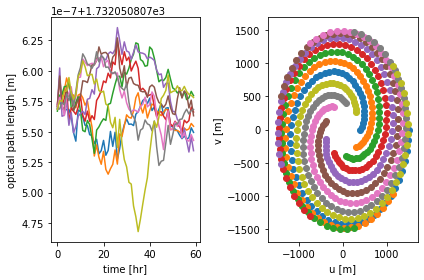

In [7]:
dvs_mirrors_uv_coverage = np.array([[[0.24278128362095053, -0.4335795997772277, -0.19035525776849133], [0.013479237910936265, 0.031701188013554475, -0.04516193688503851], [0.013515901552359396, 0.037729759198888754, -0.04070154612656853], [0.013331157374293908, 0.04321769355156696, -0.03570483537047088], [0.012910565834606128, 0.04808006356262431, -0.0302529470108397], [0.012243699332985627, 0.052241642829917154, -0.024433577850828454], [0.011324437364067448, 0.05563811214726718, -0.018339546543859057], [0.010151189365294156, 0.058217089192705115, -0.012067285157219197], [0.008727039799975638, 0.05993896583232971, -0.005715276027271483], [0.007059812650423148, 0.060777540190931595, 0.0006175369168983925], [0.005162053571885246, 0.060720432234129464, 0.006833340032521024], [0.0030509286605538677, 0.059769277040752286, 0.012837015452417846], [0.0007480410656772528, 0.05793969214139193, 0.018537658461290504], [-0.0017208316052453796, 0.055261019515752685, 0.023850018138000223], [-0.004326076558935902, 0.05177584689795697, 0.028695841707944526], [-0.00703465601029545, 0.04753931585448637, 0.033005097535518835], [-0.009810581935346402, 0.042618228213492, 0.036717060209621594], [-0.012615449333344006, 0.0370899655282939, 0.03978123684928541], [-0.015409016836599442, 0.03104123899672062, 0.04215812359857559], [-0.018149829587564014, 0.024566690619570807, 0.04381977759273213], [-0.02079586971484562, 0.01776736821393232, 0.04475019647315611], [-0.02330522803969192, 0.010749099345295669, 0.044945500072960984], [-0.025636783022693108, 0.003620790502067965, 0.044413912270854235], [-0.027750878258431474, -0.003507320436436443, 0.04317554188828434], [-0.02960998434901602, -0.010525430253415027, 0.041261969545776975], [-0.031179338540456628, -0.0173259259623801, 0.038715646102637696], [-0.0324275462645168, -0.02380510164100678, 0.03558911397595261], [-0.033327138791449815, -0.029864808188557777, 0.03194406337293701], [-0.03385507524767517, -0.0354140098055169, 0.02785024391372674], [-0.03399318060916025, -0.04037022133252132, 0.02338424171446329], [-0.033728513051132655, -0.04466080384940196, 0.018628153016692912], [-0.03305365243197857, -0.04822409712378577, 0.013668169380373916], [-0.03196690709095407, -0.05101037103366147, 0.008593098890052856], [-0.030472431510433145, -0.05298258059250647, 0.003492852319133096], [-0.028580256352639877, -0.05411691274335216, -0.001543083842195611], [-0.02630622567669129, -0.054403116257458986, -0.006427162911287113], [-0.023671845340045218, -0.053844609702276294, -0.011075252164680608], [-0.020704041105563988, -0.05245836648077428, -0.015408046898281832], [-0.017434831761836585, -0.050274578795439014, -0.0193523959261091], [-0.013900921572016835, -0.047336107087653435, -0.0228425194764203], [-0.010143216434928753, -0.0436977235114577, -0.02582109881081349], [-0.00620627321973775, -0.03942516359806694, -0.02824021862776568], [-0.0021376882799244287, -0.03459400068935842, -0.03006214778119217], [0.0020125640680563267, -0.029288363032400386, -0.031259944605683744], [0.006192833750643913, -0.023599514454282107, -0.03181787856026316], [0.010350527440398778, -0.017624322409783736, -0.0317316592126999], [0.01443285892341959, -0.011463638827367272, -0.031008470917301943], [0.018387607316970714, -0.005220620654939723, -0.0296668123611298], [0.022163870137572192, 0.001000982214661559, -0.027736142747712748], [0.0257128005162573, 0.007098543144617089, -0.02525634322439069], [0.02898831625628312, 0.012972250958080805, -0.022277001018289277], [0.031947770897329246, 0.01852674993882252, -0.018856527652997206], [0.034552574945532634, 0.023672701158694767, -0.015061130188391999], [0.0367687589444555, 0.028328238933832597, -0.010963647751209844], [0.03856746880636037, 0.032420298853591864, -0.006642277503374387], [0.03992538604384822, 0.03588579520643199, -0.0021792084426808696], [0.0408250662471525, 0.03867263002947352, 0.0023408114720413573], [0.04125519081380772, 0.040740514569772665, 0.006831953175538172], [0.041210727702465366, 0.04206159346354776, 0.011208801030535075]], [[0.2641836028362401, -0.1625156393181589, -0.4324679545405927], [0.0061739758799709684, 0.057432778379154406, -0.013796785164521055], [0.005117155501404359, 0.05941786424937176, -0.007238517885489239], [0.003843817845142118, 0.06053028138376789, -0.0006581300662113539], [0.002361987631110512, 0.06075139403013271, 0.0058441148261596625], [0.0006841682059955127, 0.06007650777758496, 0.012169879131028745], [-0.001172781424912961, 0.05851495422097348, 0.01822431140837717], [-0.0031878477927110883, 0.056089949128219754, 0.023917543281579315], [-0.005336141882462988, 0.05283822664333753, 0.02916610118874935], [-0.007589251466962274, 0.048809456081568475, 0.03389420825265202], [-0.009915660373638606, 0.044065449927510936, 0.03803495769390858], [-0.012281228926281947, 0.03867917654515147, 0.041531336925784916], [-0.014649727990521881, 0.032733593666197894, 0.04433708709048498], [-0.016983417786534605, 0.02632032120306561, 0.04641738436178628], [-0.0192436610843951, 0.019538175388802686, 0.047749331965987345], [-0.021391563000023366, 0.012491588137267817, 0.04832225534420825], [-0.02338862414448941, 0.005288936865969891, 0.04813779735204843], [-0.02519739915359735, -0.0019591872245498486, 0.04720981114298565], [-0.02678214513125292, -0.009141745123419776, 0.04556405311441788], [-0.028109455866878588, -0.016149020866873164, 0.0432376829613209], [-0.02914886330570476, -0.022874368715226377, 0.04027857845990678], [-0.02987340211882217, -0.02921590850199597, 0.036744476441399214], [-0.0302601242005794, -0.03507814114425543, 0.03270195655840049], [-0.030290555922601155, -0.040373458752744625, 0.02822528273004306], [-0.029951088222950763, -0.04502352429187703, 0.023395123092097184], [-0.029233294628201067, -0.04896049905835511, 0.018297170740587048], [-0.02813416983245428, -0.05212809778739104, 0.013020686086555815], [-0.026656284290018616, -0.05448245471853368, 0.0076569877591407265], [-0.024807852379514043, -0.05599278662992971, 0.0022979153421860835], [-0.022602711321170185, -0.056641842502468516, -0.0029657098092583014], [-0.020060211414714396, -0.056426132686693165, -0.008045599371192353], [-0.01720501644064416, -0.05535593432186863, -0.012857464980616424], [-0.01406682085167329, -0.05345507319233045, -0.017322411047410013], [-0.01067998174500239, -0.050760486154088395, -0.021368233476846542], [-0.007083076598710251, -0.04732157141901964, -0.02493059758832275], [-0.003318389316644537, -0.043199338095921865, -0.027954083450325136], [0.0005686666618910541, -0.03846536877283006, -0.030393073501781883], [0.004530178209300065, -0.03320061309807021, -0.03221247480324814], [0.00851640849436362, -0.027494031883290825, -0.03338825968795653], [0.01247650575359872, -0.021441114485609133, -0.03390781739266399], [0.016359236375065825, -0.01514229434531958, -0.033770114102580163], [0.020113729580346046, -0.008701288108181309, -0.03298565403068012], [0.023690222235261318, -0.0022233866104563534, -0.03157624561191785], [0.027040793159576963, 0.004186274695944857, -0.029574579306627116], [0.030120074054765796, 0.010424437158211826, -0.027023618188952225], [0.032885927018221954, 0.016391403866351885, -0.02397581799470173], [0.03530007730749068, 0.021992660777299874, -0.02049218792416094], [0.03732869175847683, 0.02714040683174518, -0.016641205424354516], [0.03894289351305633, 0.031754968834491845, -0.012497608671438695], [0.04011920511100478, 0.03576607746093717, -0.008141083278027506], [0.04083991218650105, 0.03911398373154354, -0.003654867288870937], [0.041093343465327795, 0.04175039805970593, 0.0008757045684082361], [0.04087406039526382, 0.04363923651286168, 0.005364687421443705], [0.0401829557135213, 0.04475716255252692, 0.009727024069120635], [0.03902725704484727, 0.04509391549099933, 0.01388002652281227], [0.03742043722186534, 0.04465242056975276, 0.017744815398101656], [0.035382031119925474, 0.0434486803227771, 0.021247694241594103], [0.03293736299316704, 0.041511447443362604, 0.02432143562559343], [0.03011718742220077, 0.038881687097406845, 0.026906455632245453]], [[0.1619714527024167, 0.18459118586079035, -0.47222410080697436], [-0.00402020923748661, 0.056290915634449684, 0.02402401130373879], [-0.00567601516616603, 0.053303673084271315, 0.029611467910994584], [-0.007442137338339218, 0.04952006112964879, 0.034696495071340455], [-0.009291840997897236, 0.04499645591510392, 0.03920662273317307], [-0.011195543028652279, 0.03980089148180635, 0.04307888561916172], [-0.013121292735678485, 0.03401198375383104, 0.04626078150278169], [-0.015035305418699902, 0.0277176837925892, 0.048711056183009464], [-0.016902533230309564, 0.021013879789287586, 0.05040030299893046], [-0.018687270076657467, 0.014002871338126362, 0.05131136902348765], [-0.020353775843733227, 0.006791740746925885, 0.05143956095071031], [-0.021866911489059122, -0.0005093530435736402, 0.05079264816513421], [-0.02319277429244921, -0.0077889288762198975, 0.04939066298507207], [-0.02429932052564332, -0.01493595892850453, 0.04726550309096471], [-0.025156967732032676, -0.021841635659051242, 0.044460341251524045], [-0.025739162955048557, -0.028401101695162283, 0.04102885504280711], [-0.026022910051326373, -0.03451511498493789, 0.037034286947663655], [-0.025989244037706825, -0.040091621629454365, 0.03254835384008601], [-0.025623645528091123, -0.04504721118834951, 0.027650020661596816], [-0.024916387973212068, -0.049308431051308096, 0.022424162385136052], [-0.023862809538237086, -0.05281293842716155, 0.016960134105728795], [-0.022463506434890233, -0.05551047129049412, 0.01135027374203095], [-0.02072444167444033, -0.057363623179923856, 0.0056883634583542245], [-0.018656968718326956, -0.058348408801743364, 6.807281198825106e-05], [-0.016277766427534236, -0.05845461218307942, -0.005418587963836427], [-0.013608687974974379, -0.057685911280190065, -0.01068278060456292], [-0.01067652327905511, -0.05605977802196579, -0.015640292681305432], [-0.007512679289852497, -0.05360715514841241, -0.020212906613254963], [-0.004152782021454648, -0.05037191587069451, -0.02432966491807513], [-0.0006362064198099698, -0.04641011514380103, -0.02792800804086154], [0.002994459847749533, -0.04178904543867924, -0.03095476656749018], [0.006694009364536434, -0.036586112407969565, -0.03336699387954961], [0.01041525613653879, -0.03088754942813493, -0.03513262382082991], [0.014109716942282, -0.024786991943203274, -0.036230942888122356], [0.017728318164814676, -0.018383935565495783, -0.03665287132578759], [0.021222121857493944, -0.011782102883463576, -0.03640104688933041], [0.024543055962901798, -0.005087746328665029, -0.0354897118996971], [0.02764463974592854, 0.0015920854078061452, -0.03394440532563474], [0.030482690466563434, 0.008151288616799783, -0.03180146497496864], [0.03301600310676009, 0.014486425287673887, -0.029107350353143224], [0.03520698909545392, 0.02049839474638601, -0.02591779551195337], [0.03702226645021083, 0.026094029135583927, -0.022296808771306253], [0.03843319006445249, 0.03118758691755509, -0.018315534756947676], [0.03941631442942164, 0.035702119377090065, -0.014050999123006178], [0.03995378114896314, 0.03957068889164046, -0.009584756118401858], [0.04003362439519311, 0.042737418516051125, -0.00500146401005848], [0.03964998972622711, 0.04515835616063329, -0.0003874094669845302], [0.038803262606190145, 0.04680214001085834, 0.004170991443422597], [0.03750010331670795, 0.04765045355267164, 0.008588691866907913], [0.03575338913468044, 0.04769826483427058, 0.012783486878608315], [0.03358206227326056, 0.04695384449421683, 0.016677435572300912], [0.031010887599992494, 0.04543856442262459, 0.02019820798128221], [0.02807012259500732, 0.04318648002875773, 0.023280335491753477], [0.024795104372353795, 0.040243703501211515, 0.025866342019258737], [0.02122576067711338, 0.03666757910478875, 0.02790773926872878], [0.017406051727862134, 0.032525674440896886, 0.029365865841255594], [0.013383351292618764, 0.027894604768516035, 0.0302125603538077], [0.009207777168963023, 0.022858710495584085, 0.030430653608786256], [0.004931480391131326, 0.017508609325757624, 0.03001427432675106]], [[-0.01602896585573679, 0.4453257345727327, -0.291021353927516], [-0.012333344783161383, 0.028809889950598296, 0.050603681431002745], [-0.01381336596046156, 0.022248083504457828, 0.05260589330035861], [-0.015245884289112605, 0.015338837113225133, 0.053816217946733254], [-0.01659796442880462, 0.008187159671049146, 0.054223888343154496], [-0.01783678498942859, 0.0009019799171417403, 0.05383077378153467], [-0.018930254929324188, -0.006405587120480331, 0.052651287823339436], [-0.019847625434675113, -0.013624008350925422, 0.05071209354484066], [-0.020560089427060498, -0.020643108821826926, 0.048051611015844646], [-0.021041354235861117, -0.027355825561111928, 0.04471933741922392], [-0.021268179120836273, -0.03365991161780725, 0.04077498900411806], [-0.02122086736236068, -0.03945956191230334, 0.03628748154299013], [-0.020883706063180307, -0.044666935296123124, 0.031333765517759196], [-0.02024534166459832, -0.04920354718634721, 0.025997534400494533], [-0.019299087986415896, -0.05300151093826422, 0.020367830062754767], [-0.018043159192766105, -0.056004607724953005, 0.01453756514906333], [-0.016480821873554784, -0.05816916741873221, 0.008601990152885097], [-0.014620466134955861, -0.05946474634213942, 0.0026571284564539882], [-0.012475589473219691, -0.059874591422084546, -0.0032017953196809518], [-0.010064696489561367, -0.059395882662888096, -0.008881904775310994], [-0.0074111130813640045, -0.05803975108893619, -0.014294178074512533], [-0.004542717610837916, -0.05583107099637068, -0.019354882040004594], [-0.0014915945240357737, -0.05280803134568322, -0.02398691402741962], [0.0017063883929109586, -0.049021492508650594, -0.028121027574955732], [0.005012068543452451, -0.04453413959900263, -0.03169692317146804], [0.00838353866868433, -0.03941944629459923, -0.03466418559559761], [0.011776749006568998, -0.033760466349358496, -0.03698305414694464], [0.015146151957988562, -0.02764847258214551, -0.0386250111700446], [0.018445379768457656, -0.021181465806877957, -0.03957318272317011], [0.02162794418128575, -0.014462578249156715, -0.0398225428961567], [0.02464794724050237, -0.0075983976115483725, -0.03937991975834881], [0.027460791185870453, -0.0006972391674033808, -0.03826380343897424], [0.030023877582079993, 0.0061326056805764894, -0.036503960289708634], [0.032297282636298726, 0.012784615838733266, -0.03414086045117732], [0.03424439898547103, 0.01915575338927083, -0.031224926424733304], [0.035832532787417604, 0.02514811507772032, -0.02781561993246349], [0.03703344727244917, 0.030670495356414747, -0.023980378672302936], [0.037823842188026126, 0.03563983562483548, -0.019793423897502736], [0.03818576259895875, 0.03998253640119306, -0.015334456330831636], [0.038106930344933614, 0.04363561081516254, -0.010687266617950936], [0.03758098955575013, 0.04654766123454941, -0.005938278775715575], [0.03660766695963533, 0.04867966302993514, -0.0011750560832167903], [0.03519283831806887, 0.05000554333510778, 0.003515210618810832], [0.033348504352698725, 0.050512545525665385, 0.008047200337089664], [0.031092672421961363, 0.05020137403766153, 0.012338927226982146], [0.028449147717532437, 0.049086117315581254, 0.01631314344748211], [0.02544723563325182, 0.04719395125390463, 0.019898657981315918], [0.0221213596950989, 0.04456462782118985, 0.02303155146907293], [0.018510601288968535, 0.0412497579000188, 0.025656262245202368], [0.014658166999053108, 0.03731190142892595, 0.02772653133318512], [0.010610792568537192, 0.032823478819031304, 0.029206183236813184], [0.006418091599635603, 0.02786552346250668, 0.030069738163277727], [0.0021318598087504484, 0.02252629486500681, 0.0303028373846384], [-0.002194655634056201, 0.016899777636590424, 0.02990248010015938], [-0.006507509453832567, 0.011084088902955959, 0.028877066381651217], [-0.010752823350964153, 0.005179822519045141, 0.02724624371542601], [-0.014877551328594888, -0.0007116425845310601, 0.025040563399253788], [-0.018830232753275784, -0.006489842553864935, 0.02230094953362586], [-0.022561722300483648, -0.012056908448199215, 0.01907799001696205]], [[-0.18652927865762603, 0.49768741375744247, 0.026353506986674977], [-0.014875622240120573, -0.012151621302083318, 0.05350530210497107], [-0.015487339878805293, -0.019217648806228855, 0.05098541102561538], [-0.01591596271017884, -0.026019616001365334, 0.04775470766270897], [-0.016137765403633448, -0.03245301559479022, 0.04386916635068473], [-0.016132046075787276, -0.03841899342929749, 0.039394616074404296], [-0.015881588447951907, -0.04382592711883877, 0.034405642120431415], [-0.015373067913533203, -0.04859088933956647, 0.028984348579231333], [-0.014597397243653741, -0.052640970256697346, 0.023219005687498368], [-0.013549999619802999, -0.05591443970070416, 0.017202599762650605], [-0.012231008506182186, -0.05836172836027385, 0.011031315088645867], [-0.01064538592378672, -0.059946213565143056, 0.004802967197441636], [-0.00880296105090639, -0.06064479584066666, -0.0013845813626521043], [-0.006718383054942827, -0.06044825771956608, -0.0074350023618150705], [-0.0044109907563869896, -0.0593613984494496, -0.013255048791207787], [-0.0019046006509415062, -0.05740294310371011, -0.018756047726047474], [0.0007727858507763158, -0.05460522717214461, -0.023855309394313434], [0.0035893496194155153, -0.05101366223115555, -0.02847743470265068], [0.006509892057166644, -0.04668599140611314, -0.03255549549035708], [0.009496335834246573, -0.04169134683973875, -0.03603207239712588], [0.012508282035550296, -0.03610912496207027, -0.03886013044067011], [0.015503614511845945, -0.030027697483353974, -0.04100372131677427], [0.01843914076932607, -0.02354297966209766, -0.042438498609282414], [0.02127126125452159, -0.016756879385786995, -0.043152040151560725], [0.023956654669793395, -0.009775651813439342, -0.04314397145633735], [0.026452968514003295, -0.0027081871819884177, -0.04242589040030952], [0.028719504736757582, 0.004335740648355756, -0.041021092066191936], [0.03071788736007449, 0.011247236382955062, -0.03896410220758909], [0.0324127029482605, 0.01792002715969257, -0.03630002579743876], [0.03377210208449237, 0.024252160202305736, -0.03308372248000812], [0.03476835269993156, 0.03014762606132989, -0.029378822515587173], [0.035378334555001244, 0.035517881766089436, -0.02525660109099326], [0.03558396843038373, 0.040283248532575186, -0.020794729574735455], [0.03537257107048503, 0.04437416204662172, -0.016075925023858382], [0.0347371297400143, 0.04773225465966835, -0.011186519643413119], [0.03367649264294946, 0.05031125248619681, -0.00621497637823422], [0.03219547002458821, 0.05207767294445427, -0.001250374190629532], [0.030304844730452616, 0.05301131170268932, 0.0036191124068838103], [0.028021290833531748, 0.05310551153337131, 0.008307711706903923], [0.0253672016130995, 0.052367209136924234, 0.012733508460809688], [0.022370428379601324, 0.05081675948002004, 0.016819826790584136], [0.019063934080612865, 0.0484875412933477, 0.02049652066841992], [0.015485366352610662, 0.045425350418513234, 0.023701149647756933], [0.011676556828024869, 0.04168759122588995, 0.02638002055839329], [0.007682953071286114, 0.03734228067455946, 0.028489078289977845], [0.0035529928076427136, 0.03246688057241031, 0.02999463001173419], [-0.0006625710204124077, 0.027146978781069794, 0.030873892581467284], [-0.004911383566258352, 0.021474840689265518, 0.031115351688958397], [-0.009140228926112643, 0.015547855085107696, 0.030718930130317266], [-0.01329578768833361, 0.009466901263579356, 0.0296959596645521], [-0.01732539888441325, 0.003334662910775878, 0.028068958737200576], [-0.021177814691715546, -0.0027460818699067808, 0.025871219616988517], [-0.02480393709311176, -0.008674167033783639, 0.023146213427519394], [-0.028157523763432692, -0.014351712329575108, 0.019946818711503844], [-0.031195853600162714, -0.019685738153237414, 0.016334394117364776], [-0.033880340708198155, -0.024589693416355536, 0.012377703046502158], [-0.036177087843810365, -0.028984872082168673, 0.00815171404712958], [-0.038057370695414455, -0.03280169502533567, 0.0037362953126509066], [-0.03949804552586714, -0.03598083606035066, -0.0007851761495792871]], [[-0.2697504944866923, 0.31717561182977955, 0.33139725727788905], [-0.010457481742909005, -0.04742727165449494, 0.031371172789434375], [-0.009914665778956198, -0.051691246791985446, 0.025508262812511263], [-0.009138835320201969, -0.05520321799357221, 0.019348212475667283], [-0.008126575967540406, -0.057908079954803494, 0.012987546374317828], [-0.006878992320591051, -0.05976330774755842, 0.0065252514459284375], [-0.005401798183866648, -0.060739643068319624, 6.118482743958374e-05], [-0.0037053285449551994, -0.06082156672949436, -0.006305525069188326], [-0.0018044674867504183, -0.060007549609386486, -0.012478061390699844], [0.0002815039248628292, -0.05831007834660473, -0.018363457287207695], [0.0025291406095399043, -0.05575545555191687, -0.023874066639883375], [0.004911143653181759, -0.05238337693366489, -0.028928942963857864], [0.007396740770915323, -0.04824629324977659, -0.03345510285788143], [0.009952134947604704, -0.04340856708719382, -0.03738865600764715], [0.01254101092331934, -0.03794543795712519, -0.04067578197278355], [0.015125094006615524, -0.03194181310571473, -0.04327353820133851], [0.017664750487255, -0.025490903517800676, -0.04515048745770481], [0.02011962056580981, -0.018692727392488912, -0.04628713418899942], [0.022449274588089946, -0.0116525053543801, -0.046676163959621576], [0.024613879391711703, -0.004478974024546254, -0.046322480490446745], [0.026574866281324362, 0.002717355208801338, -0.04524304457212622], [0.028295587973317438, 0.009825963436434647, -0.04346651270413677], [0.029741954028852578, 0.016738088779863592, -0.041032686656385785], [0.030883034187966226, 0.023348459702543935, -0.03799178086842278], [0.03169161866468587, 0.029556968906135, -0.034403521618712685], [0.03214472692587927, 0.03527026052105683, -0.030336092309471402], [0.032224055508877164, 0.04040320497656568, -0.0258649444074026], [0.03191635656686314, 0.0448802377311288, -0.021071491946369775], [0.031213740994620442, 0.048636540163626216, -0.016041714101638082], [0.03011390084292924, 0.05161904370826987, -0.010864686773963923], [0.028620245924727204, 0.053787241128318335, -0.005631069190148845], [0.026741951396153645, 0.05511379194008536, -0.00043157191411519], [0.02449391684932571, 0.05558491266961607, 0.004644571938858765], [0.02189663372991805, 0.0552005457313514, 0.009511102404199577], [0.0189759656084391, 0.05397430463702305, 0.014086173103565318], [0.01576284130373301, 0.051933197068087834, 0.018293711939218728], [0.012292867648135475, 0.04911713034010485, 0.02206468057299494], [0.008605865207945514, 0.045578208269126994, 0.025338207922079463], [0.004745334937583608, 0.041379830940614815, 0.028062585895095964], [0.0007578642472693211, 0.036595612865773404, 0.030196102980074493], [-0.0033075206877462003, 0.03130813740115179, 0.03170770986421655], [-0.00740004387045293, 0.025607568269323908, 0.03257749980882852], [-0.011467901397980663, 0.01959014156448038, 0.03279700028553707], [-0.015459004069320626, 0.013356562514226282, 0.03236926961911272], [-0.019321729330896292, 0.0070103345115728214, 0.03130879764345697], [-0.023005671409328615, 0.0006560473744991026, 0.029641213388721208], [-0.026462377612989325, -0.005602346669723962, 0.027402801228589763], [-0.029646059121974256, -0.01166324113365995, 0.024639840964583992], [-0.03251426597637895, -0.017429038574094138, 0.021407775815263756], [-0.03502851481007441, -0.022807743184384534, 0.017770226752059443], [-0.037154860107102526, -0.027714454896250462, 0.013797868792512066], [-0.03886439957856475, -0.03207274199879921, 0.009567189373679941], [-0.04013370651469189, -0.03581586858519888, 0.005159147844592758], [-0.04094518097883848, -0.038887858201502847, 0.0006577595956722359], [-0.041287315990115425, -0.04124437461080628, -0.0038513689773045133], [-0.04115487279201728, -0.04285340772901423, -0.008282534583291404], [-0.04054896403574423, -0.04369575169496587, -0.012551430435899081], [-0.039477042194858904, -0.04376526854060245, -0.016576615991193838], [-0.03795279428565287, -0.04306893406641062, -0.020280939682291443]], [[-0.2267524815347775, -0.011746192930085584, 0.48137653604150177], [-0.0011462204233595068, -0.06051119230416278, -0.005441901304676968], [0.0002971400064645737, -0.05997795301036341, -0.011904510451175014], [0.001914404392069771, -0.058556637337014134, -0.018111552840999877], [0.0036870787187574393, -0.05626732598915712, -0.023971118375424497], [0.005592768724278053, -0.053143721551188274, -0.02939737952925509], [0.007605503948592962, -0.04923261979957215, -0.0343119311609889], [0.009696125887927756, -0.044593171436758956, -0.038645004406528884], [0.011832743254947303, -0.03929594343866841, -0.04233653704324971], [0.013981239223996168, -0.03342179673959796, -0.04533708216641835], [0.016105827329863803, -0.027060598420976092, -0.04760854218683713], [0.018169645218118813, -0.02030978854842112, -0.049124715626473595], [0.020135376289813645, -0.013272825830279342, -0.04987164755930496], [0.02196588964615757, -0.006057536922417394, -0.04984778099119609], [0.023624886164407142, 0.0012256039331963683, -0.04906390467796349], [0.0250775422646472, 0.008465236248079945, -0.04754289988432147], [0.026291136598568386, 0.015550888052254536, -0.04531929159626572], [0.027235654057819227, 0.022374734140248757, -0.0424386101021169], [0.02788435103604397, 0.028833310223357524, -0.03895657671530476], [0.028214276950367066, 0.0348291543357104, -0.03493812434434422], [0.02820673997849669, 0.04027234953355146, -0.03045627264729641], [0.027847709439884568, 0.045081942702521555, -0.025590875055343437], [0.027128147927343308, 0.0491872162556171, -0.02042725755569405], [0.026044266827395555, 0.05252879266871368, -0.015054775580551193], [0.02459769975602, 0.055059553790225556, -0.009565309400278924], [0.02279559060237382, 0.05674536040233226, -0.0040517249906376245], [0.020650595051127436, 0.057565560236927854, 0.0013936745699547769], [0.018180791644854092, 0.057513277068004284, 0.006680681056759559], [0.015409507364210047, 0.05659547586502197, 0.011722671719829101], [0.012365055325303395, 0.0548328037178839, 0.01643803389437058], [0.009080391885645253, 0.05225920940050962, 0.020751498956914475], [0.005592694519969609, 0.04892134791996769, 0.024595366518020297], [0.0019428698456593365, 0.04487778057907541, 0.027910594476576952], [-0.0018250037114514997, 0.04019798350834681, 0.03064774147768907], [-0.0056642881546096315, 0.03496118151943941, 0.03276774472517324], [-0.009526445581199534, 0.029255026632592163, 0.034242518114115404], [-0.013361733474506842, 0.023174143020297265, 0.03505536779006788], [-0.017119925656790127, 0.016818562605171283, 0.03520120900560222], [-0.02075104867728469, 0.010292077161865858, 0.03468659209987951], [-0.024206119722296165, 0.0037005338876624186, 0.03352952778769492], [-0.027437877474941006, -0.0028498973060285264, 0.03175912130634678], [-0.030401491469404497, -0.009254456339711278, 0.02941502055501993], [-0.033055241320267034, -0.015411496989039434, 0.026546685329979978], [-0.035361153275142915, -0.021224134372377162, 0.023212494858930708], [-0.037285584810139535, -0.026601809096999152, 0.019478704369123863], [-0.038799747615534445, -0.03146174214180706, 0.01541827151722328], [-0.03988016094900584, -0.03573025751546809, 0.011109571285128364], [-0.040509027502455074, -0.039343950094682265, 0.006635022156945108], [-0.04067452614482905, -0.042250681119717845, 0.0020796443616191715], [-0.04037101651401895, -0.044410383645989676, -0.00247042093601371], [-0.03959915228874254, -0.045795667056960324, -0.0069294124780559015], [-0.03836590053299361, -0.046392208786542266, -0.011213437580565566], [-0.03668446742680113, -0.04619892980701021, -0.015241931326342531], [-0.0345741307673888, -0.04522794877941772, -0.018939053660841917], [-0.03205998176270168, -0.043504318233028756, -0.022235007002943504], [-0.02917258009308892, -0.04106554682387862, -0.02506725053087484], [-0.02594752744749322, -0.03796091498861296, -0.027381587163355703], [-0.022424965796058984, -0.03425059817294816, -0.029133111835335217], [-0.018649008445512264, -0.030004609694449364, -0.030286997606560853]], [[-0.07765448795679514, -0.33517183258213956, 0.4061143719150399], [0.0087013191122759, -0.04528127142211751, -0.039708673712073955], [0.010369860002469988, -0.040200325730408215, -0.04374705642733363], [0.012071822392576637, -0.034510772052567036, -0.04709674788562767], [0.013775457746524953, -0.02829848120605281, -0.04971345819419249], [0.015447561037863987, -0.021657613177754314, -0.051564678753628614], [0.01705405613176829, -0.014689121849728069, -0.05263014334979188], [0.018560605600856206, -0.007499150382777631, -0.052902088027257495], [0.019933232704340855, -0.0001973427955521449, -0.052385308918552295], [0.021138948761073143, 0.007104901495759103, -0.05109701580928783], [0.022146370709801275, 0.014296200632210869, -0.049066485969948066], [0.022926321267356775, 0.021266963595129373, -0.0463345226921066], [0.02345240035855783, 0.027911133164135665, -0.042952729331361884], [0.023701517193287596, 0.03412787195897272, -0.0389826104900005], [0.02365437349845018, 0.039823162936116784, -0.034494516056217756], [0.02329589067517768, 0.04491129934403089, -0.02956644479331817], [0.022615571220820675, 0.049316239172850905, -0.024282729127947586], [0.02160778800056796, 0.05297280277612332, -0.018732621434428734], [0.020271997763711844, 0.05582769432992004, -0.013008805872187466], [0.018612870981467022, 0.057840329968307326, -0.0072058621900498105], [0.016640338477730228, 0.05898346036819042, -0.0014187022923796394], [0.014369551284141842, 0.059243577027409816, 0.004258987952261601], [0.011820753864043472, 0.05862109622848862, 0.009736282727624918], [0.009019071680042186, 0.05713031783704857, 0.014926496065967394], [0.005994217466840734, 0.054799160052536676, 0.019748585388129368], [0.0027801168943798324, 0.05166867438008031, 0.024128455234621527], [-0.0005855371716192995, 0.047792349392177115, 0.02800014025359215], [-0.004061798237841275, 0.043235214629943154, 0.03130684785755763], [-0.0076050387105717175, 0.03807275971803409, 0.03400184339119109], [-0.011169571748744465, 0.03238968644563577, 0.03604916472983392], [-0.014708315322725875, 0.026278514554010066, 0.037424154349529094], [-0.018173484789982926, 0.019838064190388065, 0.038113798406994255], [-0.021517307289654383, 0.013171839897525423, 0.0381168737004206], [-0.024692741910922474, 0.006386342851776006, 0.03744389192209647], [-0.027654198625125893, -0.00041066107426177993, 0.036116851615247005], [-0.030358241846343788, -0.007111888924568256, 0.034168795196678], [-0.032764268203175885, -0.01361227550324362, 0.03164318451952714], [-0.034835147553181435, -0.019810666846758914, 0.02859310073162543], [-0.036537817091955145, -0.025611444909162867, 0.025080287698509916], [-0.03784381836449457, -0.03092605700684812, 0.021174050723909762], [-0.038729769133583884, -0.03567442471043224, 0.01695003110589566], [-0.03917776134540776, -0.03978621012193319, 0.01248887903438274], [-0.039175679876839585, -0.04320191814012242, 0.007874844231322344], [-0.03871743486703699, -0.045873817805918114, 0.003194309361902884], [-0.037803105762437804, -0.04776666732257672, -0.001465707140870425], [-0.0364389922886947, -0.048858231711569826, -0.006019056263952103], [-0.03463757264486397, -0.04913958464804063, -0.010381946159603297], [-0.032417368707519684, -0.048615190455320804, -0.01447438517399507], [-0.02980271930034499, -0.047302764937716596, -0.018221557576707893], [-0.02682346639828912, -0.04523291776764473, -0.021555109214114274], [-0.02351455678505818, -0.04244858388312032, -0.024414321483766783], [-0.01991556676464488, -0.039004251610697815, -0.026747151652498292], [-0.016070156004042154, -0.034965003261622114, -0.028511124803596764], [-0.01202545939886127, -0.03040538239736656, -0.029674063968711185], [-0.007831425852058373, -0.025408107858572053, -0.030214638912731812], [-0.00354011391034943, -0.02006265621464186, -0.030122733554503497], [0.0007950441795366337, -0.014463735816689355, -0.029399620755979572], [0.005119999979154626, -0.008709678544019668, -0.028057940065642103], [0.00938085505949203, -0.002900775740849531, -0.02612148594234536]], [[0.1077788779946824, -0.5017668558263122, 0.1408267678990702], [0.014477363784200838, -0.008863758319547903, -0.055395340863314727], [0.015590356520158378, -0.0016125365790735145, -0.05511989399845391], [0.016580650136488663, 0.005683050192386525, -0.05404487788624397], [0.017418097115686045, 0.012911521241997325, -0.052194346099935396], [0.01807421826774759, 0.01996231748548155, -0.049604320614954324], [0.018522777425184857, 0.026727564527086526, -0.0463221562249013], [0.018740323686616673, 0.03310379235060583, -0.042405727167053146], [0.018706694322143485, 0.03899358339397218, -0.03792244369915824], [0.01840546387514414, 0.04430712490900836, -0.03294811951952409], [0.01782433698942642, 0.048963637015725446, -0.027565707473705903], [0.01695547436785523, 0.05289265653448214, -0.021863923757306364], [0.01579574481328668, 0.05603515312599991, -0.015935783843633363], [0.014346901966693904, 0.058344461441739735, -0.009877075412503909], [0.012615678391133273, 0.059787013503047055, -0.003784792223569116], [0.010613795996951031, 0.0603428591697934, 0.002244445957370592], [0.008357892453002946, 0.06000596736883289, 0.008115959264040651], [0.005869361988818833, 0.058784302342955, 0.013738535503254498], [0.003174115643011753, 0.056699674341773115, 0.019025894926266572], [0.00030225945638609486, 0.05378736734394416, 0.023898066615212724], [-0.0027122994858034843, 0.05009554989181597, 0.02828265614228852], [-0.005832317824570431, 0.0456844789160025, 0.03211598190182005], [-0.00901774203621958, 0.04062550980232001, 0.035344063948259966], [-0.012226288394885402, 0.03499992882305337, 0.037923446790344914], [-0.015414068286164451, 0.02889762722244235, 0.03982184654719633], [-0.01853624820737114, 0.022415638894726624, 0.04101860848882042], [-0.02154773444782362, 0.01565656529224261, 0.04150497133797995], [-0.024403872544066504, 0.008726913715781529, 0.041284131965643636], [-0.027061147014363355, 0.0017353759630552204, 0.04037111197932161], [-0.0294778755500535, -0.005208924426790183, 0.0387924273018145], [-0.03161487968676877, -0.011998187755404009, 0.03658556809463423], [-0.03343612747463057, -0.018527667894112653, 0.033798298378115925], [-0.034909332709081864, -0.02469734801306533, 0.030487784713027485], [-0.03600650321783566, -0.03041353503335464, 0.02671957403057589], [-0.03670442930622027, -0.03559034691363803, 0.02256643253168054], [-0.03698510161885282, -0.040151068718181575, 0.01810707036912056], [-0.036836055203125766, -0.044029355347768924, 0.013424768203284178], [-0.03625062953143258, -0.04717026191092915, 0.008605935589478338], [-0.03522814320059177, -0.04953108481259593, 0.003738619021822991], [-0.03377397832587106, -0.05108200053262362, -0.0010890109332358487], [-0.031899572742304726, -0.05180649171289427, -0.005790170655758968], [-0.029622320345282522, -0.05170155435660071, -0.010280945339634527], [-0.02696537989247309, -0.05077768282247758, -0.014481717336469867], [-0.023957395265346102, -0.04905863375183691, -0.018318519857818776], [-0.020632130441817602, -0.046580972903295256, -0.021724288512391384], [-0.017028025405141835, -0.043393413145860975, -0.024639993548818753], [-0.013187678556861603, -0.039555954565299575, -0.027015633339465443], [-0.009157263942874293, -0.03513884184428649, -0.028811071266396992], [-0.004985892073247332, -0.030221355934559314, -0.02999670382350369], [-0.0007249233110508934, -0.024890460754239806, -0.030553946534210393], [0.0035727543646603905, -0.019239326812168646, -0.030475534447254767], [0.007853473975508396, -0.013365757913172642, -0.029765624546700155], [0.012063551221226963, -0.0073705451632963175, -0.02843970744094235], [0.016150049159748634, -0.0013557774713096704, -0.026524322827285167], [0.02006153288077468, 0.004576864960361911, -0.024056588563255384], [0.023748803665555287, 0.010327804277986094, -0.02108354644072958], [0.027165600214205502, 0.015801219325918776, -0.017661342236761562], [0.03026925728271117, 0.020906631894978368, -0.013854246793997667], [0.03302131085291277, 0.02556040003103706, -0.009733541104088674]]])

for i_mirror in range(len(r0_mirrors)):
    rs = propagate_closed_loop_orbit(r0_mirrors[i_mirror], v0_mirrors[i_mirror], dvs_mirrors_uv_coverage[i_mirror], n_minutes=5)
    
    drs_nominal = rs - rs_interferometer[:len(rs)]
    drs_combiner = rs - rs_combiner
    opl_1 = -drs_nominal.dot(direction)
    opl_2 = np.linalg.norm(drs_combiner, axis=1)
    plt.subplot(121)
    plt.ylabel("optical path length [m]")
    plt.xlabel("time [hr]")
    plt.plot(opl_1 + opl_2)
    
    u_disp = drs_nominal.dot(perp_direction_1)
    v_disp = drs_nominal.dot(perp_direction_2)
    plt.subplot(122)
    plt.scatter(u_disp, v_disp)
    plt.ylabel("v [m]")
    plt.xlabel("u [m]")
    
plt.tight_layout()

### Delta-v estiamtes for formation maintenance
We can now compare our rough delta-v estiamtes required for maintaining the optical-path lengths of the cubestas and increasing the uv coverage.

Increasing uv coverage is much more expensive and requires on average about 0.2 m/s per cubesat (or less for more cubesats). However, it is neccesary only when performing observations. Keeping the cubestas at the right distances from the combiner between observation only requires about 0.001 m/s per hour per cubesat.

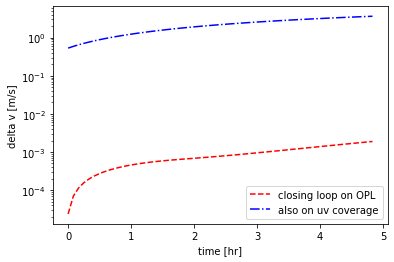

In [8]:
#delta-v magnitudes of manuevers averaged across all CubeSat mirrors
mean_delta_v_mirrors = np.mean(np.linalg.norm(dvs_mirrors, axis=2), axis=0)
mean_delta_v_mirrors_uv_coverage = np.mean(np.linalg.norm(dvs_mirrors_uv_coverage, axis=2), axis=0)

times = np.arange(len(mean_delta_v_mirrors))*5/60
plt.plot(times, np.cumsum(mean_delta_v_mirrors), "r--", label="closing loop on OPL")
plt.plot(times, np.cumsum(mean_delta_v_mirrors_uv_coverage), "b-.", label="also on uv coverage")
plt.yscale("log")
plt.xlabel("time [hr]")
plt.ylabel("delta v [m/s]")
plt.legend()

## Analyzing repointing (47 days)
The LGS needs to be manuevered such that it appear ahead of different stars as viewed from the interferometer (repointing). We note that the pointing drifts on its own due to the different influence of the Sun on the LGS and th interferometer as they fly in oposite directions. This drift can be exploited to reduce fuel consumption.

### Star targets
First, we provide a list of stars that are bright, large and close enough to produce high-resolution images with a 3 km baseline interferometer and five 20 cm mirrors.

In [9]:
star_names = ['Alpha Aquilae', 'Alpha Arietis', 'Alpha Aurigae', 'Alpha Bootis', 'Alpha Canis Majoris', 'Alpha Canis Minoris', 'Alpha Carinae', 'Alpha Cassiopeiae', 'Alpha Centauri', 'Alpha Ceti', 'Alpha Serpentis', 'Alpha Tauri', 'Alpha Ursae Minoris', 'Beta Andromedae', 'Beta Bootis', 'Beta Cancri', 'Epsilon Corvi', 'Epsilon Cygni', 'Epsilon Geminorum', 'Epsilon Leporis', 'Epsilon Ophiuchi', 'Epsilon Pegasi', 'Epsilon Scorpii', 'Epsilon Virginis', 'Eta Ceti', 'Gamma Hydrae', 'Gamma Hydri', 'Gamma Leonis', 'Gamma Phoenicis', 'Gamma Sagittae', 'G Scorpii', 'Alpha Scorpii', 'Eta Draconis', 'Iota Aurigae', 'Lambda Velorum', 'Theta Centauri', 'Beta Leporis', 'Beta Ophiuchi', 'Beta Pegasi', 'Beta Ursae Minoris', 'Delta Andromedae', 'Delta Canis Majoris', 'Alpha Herculis', 'Alpha Hydrae', 'Alpha Indi', 'Alpha Lyncis', 'Alpha Lyrae', 'Alpha Orionis', 'Alpha Persei', 'Alpha Phoenicis', 'Mu Geminorum', 'Mu Ursae Majoris', 'Mu Velorum', 'Nu Hydrae', 'Nu Ursae Majoris', 'Pi Herculis', 'Pi Hydrae', 'Pi Puppis', 'Theta Eridani', 'Zeta Arae', 'Eta Geminorum', 'Eta Pegasi', 'Eta Serpentis', 'Gamma Andromedae', 'Gamma Aquilae', 'Gamma Cephei', 'Gamma Crucis', 'Gamma Draconis', 'Gamma Eridani', 'Delta Draconis', 'Delta Ophiuchi', 'Delta Virginis', 'Epsilon Boötis', 'Psi Ursae Majoris', 'Rho Persei', 'Sigma Canis Majoris', 'Sigma Librae', 'Tau Puppis', 'Tau Sagittarii', 'Iota Draconis', 'Kappa Ophiuchi', 'Lambda Sagittarii', 'Beta Ceti', 'Beta Columbae', 'Beta Corvi', 'Beta Cygni', 'Beta Draconis', 'Beta Geminorum', 'Beta Gruis', 'Beta Herculis', 'Zeta Cephei', 'Zeta Cygni', 'Zeta Hydrae']
star_ras = np.array([297.69582729166666, 31.79335708333333, 79.17232795833334, 213.9154166666667, 101.28715533333333, 114.82549791666668, 95.98795783333334, 10.126837916666666, 219.90205833333331, 45.569887791666666, 236.06697629166666, 68.98016279166666, 37.954541666666664, 17.433016166666665, 225.4865099166667, 124.12883583333334, 182.5311690833333, 311.5528431666666, 100.98302608333333, 76.365272375, 244.5803739166667, 326.04648391666666, 252.5408333333333, 195.54415770833333, 17.1474645, 199.73040495833334, 56.80975258333333, 154.99312733333335, 22.091363625000003, 299.6892859583333, 267.464503375, 247.35191541666669, 245.99785808333334, 74.24842120833334, 136.998991125, 211.67061466666667, 82.0613465, 265.8681360416666, 345.94357275000004, 222.67635750000002, 9.831979916666667, 107.09785866666668, 258.66188750000003, 141.89684708333334, 309.39180004166667, 140.2637530833333, 279.23473479166665, 88.792939, 51.080708708333326, 6.5710475, 95.74011191666666, 155.58224900000002, 161.69241154166667, 162.406203125, 169.619736, 258.76180983333336, 211.59290620833332, 109.28565325, 44.565330083333336, 254.65505070833333, 93.71940416666666, 340.75057262499996, 275.32750233333337, 30.974801208333332, 296.564917875, 354.83688333333333, 187.791498375, 269.1515411666667, 59.50736229166667, 288.13875820833334, 243.58641054166668, 193.90086920833332, 221.24675, 167.41586949999999, 46.29414104166667, 105.42978245833334, 226.01756699999999, 102.48403524999999, 286.73503737500005, 231.23239429166668, 254.41707437499997, 276.9926696666667, 10.89737875, 87.73997041666667, 188.5968118333333, 292.68035833333334, 262.60817375, 116.32895779166667, 340.666876125, 247.55499812500003, 332.71366250000005, 318.2341080833333, 133.84844225])
star_decs = np.array([8.868321194444444, 23.462417555555554, 45.997991472222225, 19.182222222222222, -16.71611586111111, 5.224987555555556, -52.69566138888889, 56.53733111111111, -60.83399269444445, 4.089738777777778, 6.425628694444445, 16.50930236111111, 89.2641111111111, 35.62055763888889, 40.39056683333333, 9.185544722222222, -22.619767222222222, 33.97025694444444, 25.131125416666666, -22.371034416666667, -4.692509583333333, 9.87500863888889, -34.29333333333334, 10.959150416666667, -10.182265833333334, -23.171514277777778, -74.2389635, 19.84148522222222, -43.318236166666665, 19.492146694444443, -37.04330486111111, -26.432002611111113, 61.51421386111111, 33.166099583333335, -43.43259091666667, -36.36995475, -20.759441055555556, 4.567304305555556, 28.08278711111111, 74.15550394444445, 30.86102175, -26.393207611111112, 14.390277777777778, -8.6586025, -47.291500722222224, 34.39256236111111, 38.78368894444444, 7.407064, 49.86117930555555, -42.30598719444444, 22.51358275, 41.499519194444446, -49.42025677777778, -16.193648888888887, 33.09430852777778, 36.80916230555555, -26.68236177777778, -37.097471166666665, -40.30467936111111, -55.99014452777778, 22.5068, 30.221245055555556, -2.8988268333333336, 42.32972841666667, 10.613261333333334, 77.632275, -57.11321344444445, 51.48889561111111, -13.508519388888889, 67.66154044444444, -3.6943225555555554, 3.3974703333333336, 27.07422222222222, 44.498486666666665, 38.84027619444444, -27.9348305, -25.28196127777778, -50.614567694444446, -27.670421916666665, 58.966065111111114, 9.375031277777778, -25.4216985, -17.986606305555554, -35.76830977777778, -23.39676038888889, 27.959677777777777, 52.30138869444445, 28.02619888888889, -46.88457644444444, 21.489611333333333, 58.201258333333335, 30.226915472222224, 5.945565388888889])

### Open-loop drift
We plot the stars and the pointing on the LGSI as it changes over time in open loop (no thursts applied). The pointing changes but doesn't come close to stars other than the first one (Gamma Hydrae).

Text(0, 0.5, 'declination [deg]')

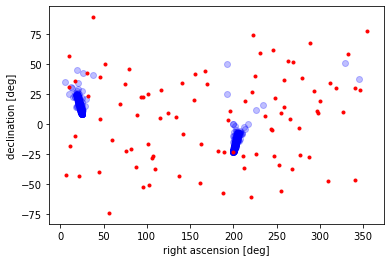

In [10]:
#propagate LGS and interferomter positions at 1-hour resolution for 1116 hours
dvs_zero = np.zeros((1116, 3))

rs_interferometer = propagate_closed_loop_orbit(r0_interferometer, v0_interferometer, dvs_zero, n_minutes=60)
rs_lgs = propagate_closed_loop_orbit(r0_lgs, v0_lgs, dvs_zero, n_minutes=60)

#get pointing direction (the line connecting interferometer to LGS)
directions = (rs_lgs - rs_interferometer)/np.linalg.norm(rs_lgs - rs_interferometer, axis=1, keepdims=True)

#get right ascension and declination corresponding to pointing directons
ra = np.arctan2(directions[:,1],directions[:,0])
dec = np.arctan2(directions[:,2], directions[:,0]*np.cos(ra) + directions[:,1]*np.sin(ra))
ra = ra + 2*np.pi*(ra<0)

plt.scatter(np.degrees(ra), np.degrees(dec), alpha=0.25, color="b")
plt.scatter(star_ras, star_decs, marker=".", color="r")

plt.xlabel("right ascension [deg]")
plt.ylabel("declination [deg]")

### Closing the loop on LGS position
Fiding suitable star targets and manuevers is a a multi-step optimization problem which we skip for brevity. Instead we present an example of a set of hourly thrusts that bring the LGS to point at four different stars (marked by crosses). The code below propagates the LGS (with thrusts) and the nominal interferometer position (no thrust) for about 47 days.

Text(0, 0.5, 'declination [deg]')

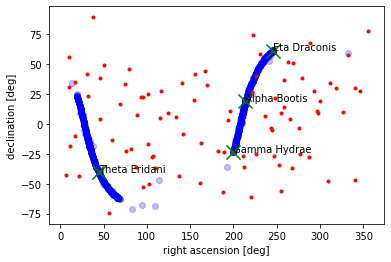

In [12]:
#repeat with non-zero thrust for LGS
dvs_lgs = np.array([[11.524653064750597, -6.215470170245856, 1.898299503893403], [6.8605283843208875, -0.8992531997743181, -0.5925101261701045], [2.8045716870512862, 4.969053372497665, -2.839222921655394], [3.017857540283073, 4.3621928993323795, -7.473051036429393], [2.569021338974769, 4.713760397070592, -9.045308341484176], [-0.011714082608154826, -0.12213821134173987, -0.05882705885577106], [-0.0033615350888768895, -0.1618349897834982, -0.06319843574520219], [0.004357163737805819, -0.19149047477177902, -0.059856627904332396], [0.011715530389700024, -0.2078259732169337, -0.050329844968424194], [0.018123533615132366, -0.20880379534980126, -0.03707121307285367], [0.022130907874493875, -0.1940596290892945, -0.022761608071901775], [0.021794856237535395, -0.1650477139712184, -0.009566594827665276], [0.015321969609324266, -0.12483135594992437, 0.0014037439702646569], [0.001771794916341427, -0.07755902623194741, 0.010242700531576596], [-0.018434584389666483, -0.02776820550068428, 0.017959172224451817], [-0.04339348960316757, 0.020291793834456492, 0.025879457102411456], [-0.07003321412336246, 0.06315192088364073, 0.03497532710600997], [-0.0947569065348148, 0.09834677958031453, 0.04536213827890955], [-0.11420825877807728, 0.1243831391883911, 0.0561236714049128], [-0.12594265511440683, 0.14053886561805237, 0.06549186853525417], [-0.12884563551829747, 0.1466043805900514, 0.07129751223544671], [-0.12323186580487748, 0.1426649449430196, 0.07154562899923403], [-0.11064367290792966, 0.1289853018481552, 0.0649604682372489], [-0.0934284816978019, 0.10601603733417074, 0.051373556639919576], [-0.07420498637486904, 0.07450458733985246, 0.03187491601469283], [-0.05533435458320775, 0.03566727507300297, 0.008698092913991358], [-0.038502526889478035, -0.00863768152348698, -0.015142302746068382], [-0.024496892553031533, -0.055803279183203554, -0.036397704137710714], [-0.013225740204604562, -0.10249644896044921, -0.05221498417658936], [-0.003980681507229929, -0.14485676913884438, -0.06071583292554582], [0.004117551735057931, -0.17888373797520116, -0.06138327904196459], [0.011611063300821092, -0.20097525102462738, -0.05513586954798856], [0.01829835800355391, -0.2085226826477606, -0.044037085920643405], [0.023090649401831684, -0.20042254376308222, -0.030693253000194543], [0.024225029251747496, -0.17735599093603913, -0.017507679010663194], [0.019805179135838777, -0.1417331966563178, -0.006031835341339518], [0.008504341949002875, -0.09729431574118298, 0.0033606014854390565], [-0.00981852270335051, -0.048468601622744974, 0.011364227965567507], [-0.03382107314779295, 0.0003306441494112909, 0.019252151079589858], [-0.06081413201751138, 0.04529039298698018, 0.02820521679763855], [-0.08728843036440988, 0.08353816550954875, 0.03871370968597773], [-0.10965846520350137, 0.11321111909280511, 0.05025399665742788], [-0.12500061676234434, 0.13331321711656205, 0.061324531123815695], [-0.1315951138306365, 0.14346666742108888, 0.06980040283352199], [-0.1291641861014513, 0.14366579124268292, 0.07347954465809937], [-0.1187909047508619, 0.13411247568532345, 0.07066293014482376], [-0.10257635210362284, 0.11517037336810561, 0.06062597034924434], [-0.0831358422140254, 0.08743526597008705, 0.0438798454767558], [-0.06305090488543824, 0.05188782578905564, 0.02217196497504028], [-0.04438957812138756, 0.010074440926121158, -0.001775404090554892], [-0.028389470236839288, -0.0357492062415563, -0.024743227919441328], [-0.015368154797539753, -0.08257807151332505, -0.04362384350525756], [-0.004882753360173394, -0.1267763777430568, -0.05603791411965943], [0.0038947308374457012, -0.16438364999947908, -0.06081915018489236], [0.011682010459412542, -0.19159350184729412, -0.05823342285295265], [0.01861988329094268, -0.20533514688147592, -0.04984674571456704], [0.024002532168263417, -0.20383485850708774, -0.03804741380151215], [0.026334371217553183, -0.1870075970236596, -0.025342452378041693], [0.023741100764384775, -0.15655045681142138, -0.013644897457180347], [0.014625770232827037, -0.11568518239843452, -0.003794741106706755], [-0.0016524074697940702, -0.06860514539140698, 0.004516579862864951], [-0.02432780053499364, -0.019777855959301555, 0.012399976622371885], [-0.05118052924675889, 0.02670705379311063, 0.021145917336604293], [-0.0789156644309744, 0.06758854474726524, 0.031567759102802656], [-0.10384399567538276, 0.10061407199966636, 0.04354621766374494], [-0.12265194051007886, 0.12447441020832978, 0.055914052069716245], [-0.13304755835626356, 0.13858496100340134, 0.06669084459285558], [-0.13413580248492982, 0.14282575351151228, 0.0735709838342464], [-0.12646911159632424, 0.13733431854935413, 0.07451316401799649], [-0.11180329734558504, 0.12240710591324228, 0.06827721538033588], [-0.09264535848429237, 0.09852291741837856, 0.05478690372252831], [-0.07170670137393692, 0.0664664270614421, 0.035246002781092405], [-0.051378549454371286, 0.027504841281485806, 0.01198622094000091], [-0.03333340749873401, -0.016444252107471462, -0.011926418274183706], [-0.01833106481993042, -0.06272081986511913, -0.03325655635404646], [-0.006270264295999649, -0.10796737483605089, -0.04922792627176336], [0.0035230454968215273, -0.14835252715639588, -0.05808040039033837], [0.011840194897741666, -0.17997847227495653, -0.059415721970133506], [0.0190952612727152, -0.1994267540886576, -0.05422181330446267], [0.02495617098586254, -0.204340885016019, -0.04453855798517826], [0.028254033056987458, -0.19390393646734946, -0.03283560482286642], [0.02724747199034787, -0.16906812813914893, -0.021282159315548305], [0.020192004375462, -0.13244639305725014, -0.011149648378502894], [0.00603417712650051, -0.08787382775272698, -0.0025583955844498546], [-0.015019794761923088, -0.03975313197037771, 0.005343817010317539], [-0.04127841440405595, 0.007635004815473503, 0.01385061518353418], [-0.06977464557139326, 0.050678812385075905, 0.024025299707313104], [-0.09684487609903984, 0.08672993744179207, 0.03613900870864106], [-0.11889163543850127, 0.11413229269165351, 0.04940588301878254], [-0.1331071531373167, 0.13205369360472127, 0.062080099993262694], [-0.13797674565738063, 0.14022906626537218, 0.07185774853886645], [-0.1334675597624454, 0.13872074350555305, 0.07644780417005459], [-0.12089975464084521, 0.12776928206475993, 0.07415295744114245], [-0.10256685901599627, 0.10776581093173548, 0.06432148520505016], [-0.08121136754831491, 0.0793377253625933, 0.047575702772650545], [-0.059473888233051574, 0.04350990218748111, 0.025774227641571546], [-0.03942717841459266, 0.0018845631805634573, 0.0017153682836895336], [-0.022285607561874105, -0.04322625880350717, -0.021365495418004053], [-0.00834811497005075, -0.08878052628719053, -0.04041133801850822], [0.0028122274382601053, -0.1311495740205961, -0.0531465702842315], [0.011955397933704901, -0.16644736886113515, -0.05852731593598793], [0.019682712866675205, -0.1910228298680141, -0.05691225599770108], [0.025998853315968858, -0.20203734310063012, -0.04988192174642134], [0.030091196740917727, -0.19800031816256006, -0.03972900912311269], [0.030441768032049246, -0.17911552682026294, -0.028755268023342342], [0.025279038098214267, -0.14732019735200533, -0.018597285918929996], [0.013241599408669903, -0.10597992520544365, -0.00981521522661229], [-0.0059762490620088515, -0.059309859870659364, -0.0018924003546560747], [-0.03124011834962204, -0.011680994169547858, 0.006362139995970578], [-0.06000517760407807, 0.03300148592012834, 0.01617230205242333], [-0.08876004700936724, 0.07170376707260968, 0.02816101744980478], [-0.11374186913678667, 0.10239822005519102, 0.04194770779968069], [-0.13170489580517925, 0.12396498164433094, 0.05609685964285212], [-0.1405356774231756, 0.1359574152336371, 0.06840882825614293], [-0.13958060622242882, 0.13834292661680977, 0.07644352112250562], [-0.12964550766982047, 0.13130848713245713, 0.07812069856213845], [-0.11270831265405705, 0.11518014414399967, 0.07224480705738681], [-0.09143846660729413, 0.09046390863959863, 0.05883897398149984], [-0.06863968595707519, 0.057981232854420174, 0.0392234834333338], [-0.04673261452980369, 0.019048923273338524, 0.01582576892123382], [-0.027378322160107684, -0.024359950881557124, -0.008243322253080837], [-0.011315484373930922, -0.06954058549136169, -0.029769601268893733], [0.0015556369299402886, -0.11312480497957168, -0.0460588733168784], [0.011861212148924582, -0.1513293129798823, -0.05546736582715528], [0.020292710974577494, -0.18038155289010863, -0.05770348179360667], [0.027131096340121136, -0.1970692344838849, -0.05380164701180109], [0.03192007608435313, -0.1993059119070406, -0.045747380256864936], [0.033430556228335205, -0.18657014450495923, -0.03584122581225405], [0.0299743633289848, -0.1600824289388479, -0.02599207947692134], [0.01999654841460471, -0.12264402797762107, -0.01717828443734576], [0.002752698366376154, -0.07816190733258332, -0.009270411085532665], [-0.021177571367490575, -0.030985434741356545, -0.0012775899260403748], [-0.04974182797757357, 0.014762569728450884, 0.008085291394381973], [-0.07969846507811154, 0.055691369416274915, 0.019732193842027217], [-0.10724490586670826, 0.08938922049295267, 0.03368726606302083], [-0.12879405615766312, 0.11441224813520756, 0.048882925314095285], [-0.1416778588305905, 0.1300922671049507, 0.06331932009090324], [-0.1446076382643117, 0.13627402300523375, 0.07451233619983395], [-0.1378108261903821, 0.1330839740089656, 0.08008640044905138], [-0.12285377745992689, 0.12079789663891323, 0.07835241752427523], [-0.10222633948943115, 0.09983186101722775, 0.06873681700298744], [-0.07879897583689471, 0.07084288028407756, 0.05197480974814773], [-0.055271887657223406, 0.034897423879525866, 0.030033599279198124], [-0.03372543414289406, -0.006351263417693388, 0.005781378062890297], [-0.015357758921778196, -0.05054338057139387, -0.01753733332502262], [-0.00046052206354417084, -0.09461326749447568, -0.036920684660136774], [0.011363331074233046, -0.1349574613471391, -0.05019467786957551], [0.020792985138326028, -0.16778557388426327, -0.056425851396975375], [0.028306627226040174, -0.18962297434601472, -0.05604302108680062], [0.033776728616533996, -0.19788004694567454, -0.05061028563784175], [0.03630089037371808, -0.19135764534375144, -0.042291196984665574], [0.03436786317537457, -0.17054532830066255, -0.03315369576455876], [0.026345116424181154, -0.13760589705576257, -0.024541569809514645], [0.01114258618921888, -0.09602538105324307, -0.016735104437862414], [-0.011182644206106904, -0.05001326111452512, -0.009025446661643574], [-0.039113042333317125, -0.0038178668746028663, -0.000168687617976621], [-0.06977906374774148, 0.03886071218527449, 0.010961167939676804], [-0.09946526958644829, 0.07522897414301426, 0.02476796860044218], [-0.12435493146115746, 0.10348981681881915, 0.04058853612369591], [-0.14129195578488649, 0.12271258364299488, 0.05670691556417268], [-0.14836090593220613, 0.13258500230188522, 0.07070031806146707], [-0.14516420084129356, 0.13315696533625299, 0.07999583685849437], [-0.13277002251058959, 0.12466017262234194, 0.08247827634929815], [-0.11338267993676768, 0.10744633013309983, 0.07699988564163901], [-0.08983563894323061, 0.08204519537051475, 0.06368343969592295], [-0.06502632650740915, 0.04931106423301846, 0.04396232203305035], [-0.04140853224739409, 0.010604508493392001, 0.02035333180302845], [-0.0206395641098557, -0.032055032034182966, -0.003994874198167953], [-0.003448869237150485, -0.07593133962826933, -0.025893526533259305], [0.010247245497651424, -0.11766308350337124, -0.042728211218746745], [0.02101327977436925, -0.15353534444511038, -0.05295962833369424], [0.029432402534553585, -0.17992095467348587, -0.056380331305239194], [0.03565392074097027, -0.19382979123022523, -0.05404005268047796], [0.03911150455619226, -0.19345326689033157, -0.04783525240891402], [0.038542346179638934, -0.17856217171140873, -0.03986649547289627], [0.03234602540567796, -0.1506304656689818, -0.03176263556087063], [0.019192695739167695, -0.11262379002480499, -0.024205139060859342], [-0.0013240839705039534, -0.06849255645820707, -0.01682738186858124], [-0.02823464359933859, -0.022505389947869606, -0.008524771228809971], [-0.05912312825118142, 0.0213946343262768, 0.0019487644492312832], [-0.09048307359753292, 0.06005175953913212, 0.015328721634704069], [-0.11839031287496986, 0.09129678600912823, 0.03136958390498592], [-0.139287915129105, 0.11389769180476542, 0.048707930938683495], [-0.15066539368739945, 0.1273460106181678, 0.06508367923670515], [-0.15147345067270318, 0.1315904375917122, 0.07783174496956813], [-0.14220803386456898, 0.12681566283820242, 0.08449353787307928], [-0.12468571978996519, 0.1133274374881081, 0.08338912762565238], [-0.10159444508291325, 0.09156199931375018, 0.0740215178043972], [-0.07593461413596884, 0.06220077964243086, 0.05723402514995339], [-0.05047043119700176, 0.026344963299309458, 0.03509524652944243], [-0.027298239748989966, -0.01431101497702912, 0.01053581567699675], [-0.007612551666545443, -0.05737319729839188, -0.013195068070021916], [0.00828688864542275, -0.09976963704258984, -0.03314864182712303], [0.020752271644691227, -0.137941813007164, -0.047240891432180826], [0.030371745020786687, -0.16821446476244295, -0.05462647484678723], [0.037499327091626074, -0.187304904223311, -0.05577297003654148], [0.04188654158072143, -0.1928800427113291, -0.052192256758121135], [0.04256492566630609, -0.18402879620396584, -0.04588554839176331], [0.03806258184465877, -0.16151148076347785, -0.038663820432730686], [0.026920982697870292, -0.12769188433882084, -0.031570308297891446], [0.008351214740357079, -0.08614689721605412, -0.024614353326152003], [-0.017208247324853813, -0.041051351410109585, -0.01691724005804684], [-0.04785182630317539, 0.0034925543752034292, -0.007211455074984336], [-0.08039258677766689, 0.04400495671275088, 0.005501904074261387], [-0.11092623910561913, 0.0779391641030435, 0.021383983436482717], [-0.13560000847852674, 0.10372813401781887, 0.03947344578233937], [-0.15136352563553943, 0.12062553646329426, 0.05776592616761906], [-0.15651110498448031, 0.12844665035444752, 0.0736127102181123], [-0.15090808729891647, 0.12731684873400725, 0.08430741919371391], [-0.1358880884948427, 0.11750615358996301, 0.08769860066131749], [-0.11388312207903442, 0.09938596842149187, 0.08268256495528795], [-0.08789265134290175, 0.073503474377079, 0.06947504127033645], [-0.060912622816855756, 0.040737926101701516, 0.049613805302158594], [-0.03543898741903103, 0.0024830823971336885, 0.025696457667917554], [-0.013138695929989168, -0.03920931551215648, 0.0009041707781156564], [0.0052516355259542066, -0.08158905825472695, -0.021598302823183455], [0.019783238708036537, -0.12132124860576897, -0.039265339961123635], [0.030946704756243195, -0.1547785501013234, -0.05064024771000938], [0.039213251745748474, -0.1784944520147665, -0.055568278012339906], [0.04460874523488952, -0.18970852200830324, -0.05507770641951228], [0.046477542342030546, -0.1868867376396693, -0.05094053813845806], [0.04355350949136007, -0.17007700927429328, -0.045030765090989515], [0.034358063403675754, -0.1409816210307718, -0.038685312392851036], [0.01781678165709905, -0.10269975593674087, -0.032293699684085575], [-0.006118599680174049, -0.0591945158157585, -0.025271441064504515], [-0.03608134644436881, -0.014628379731651311, -0.016427903736607456], [-0.0692974116933515, 0.027252055196780985, -0.004584864345078909], [-0.1020087982315948, 0.06353338619553241, 0.010790589641552469], [-0.13018584489076543, 0.09228856801684046, 0.029166747455717918], [-0.15031606304181305, 0.11249198236967542, 0.048875178171003154], [-0.1600563844671855, 0.12378715318847032, 0.06739136640305815], [-0.1586018624760315, 0.12621865666699125, 0.0818668657021167], [-0.1467183501463147, 0.12002193267960759, 0.08975670400688496], [-0.1264727017983023, 0.10552574242702577, 0.08938410015833803], [-0.10075223348553823, 0.08317920625738456, 0.08031964157777166], [-0.07269195235300197, 0.053679434403380445, 0.06350388677899442], [-0.04512943956325128, 0.018151025774453045, 0.041096375206254136], [-0.020191189951572975, -0.021684955666207404, 0.016083295435371233], [0.0009143633301070137, -0.06341813467913729, -0.008281418780712929], [0.01786135349297235, -0.1039899765781475, -0.029092213761168877], [0.03094265412117788, -0.13990618922435466, -0.04433400310056003], [0.04064888519158519, -0.1676220811740109, -0.05321834272963905], [0.047214845632514345, -0.1840547093192494, -0.056214044610078534], [0.05028859017753688, -0.1871245861941845, -0.05474330993166752], [0.04886340587014734, -0.17619375514017294, -0.050615074669859164], [0.04153946806318766, -0.15226774527666823, -0.04536722594854861], [0.02706264712505968, -0.11787932345255896, -0.039743095893423196], [0.004966596708691555, -0.07666354433119799, -0.033496941155048414], [-0.023920064080628176, -0.03273296656131227, -0.02560573485268225], [-0.05730719415242529, 0.009975045222069844, -0.014806328516599902], [-0.09170227914158986, 0.048209482403454705, -0.00025103182686381443], [-0.12302685834056419, 0.07967037999576182, 0.017961671831627862], [-0.1474047479709267, 0.10301487082356514, 0.038562583049175786], [-0.16189910587136727, 0.11767229632891188, 0.059254001929965834], [-0.16501656384473543, 0.12357638250726435, 0.07715782526852263], [-0.15688427336949837, 0.12091954428691333, 0.08942922152680843], [-0.1390991678944414, 0.11000229842476762, 0.0938722452374901], [-0.1143206397746551, 0.09120774251686248, 0.08941567628428265], [-0.08571792554742141, 0.06509111293482656, 0.0763545954679698], [-0.056394744232125746, 0.03254474552101695, 0.056318024445402244], [-0.028903926149099, -0.005019489460940248, 0.03197502881193397], [-0.004940809447122889, -0.04553569532617472, 0.0065371889989761355], [0.014730970014816916, -0.08625977149817166, -0.01684667686997663], [0.030113280702494836, -0.12390292625743984, -0.03567999350675832], [0.04161324255036632, -0.15494135508798149, -0.04855806305019851], [0.04959156302870493, -0.17607769190348949, -0.05534087343095128], [0.05396461974375305, -0.18477896746692843, -0.056995990489453675], [0.054012344151955424, -0.17977124891191323, -0.055137793764977655], [0.04849621562368303, -0.16135388077773966, -0.05139335656561409], [0.03608948149946841, -0.13142436939844743, -0.04680386201974992], [0.015995318538403903, -0.0931807877317198, -0.041478940453909936], [-0.011466279598202036, -0.050568789636819156, -0.03463920857500685], [-0.04453373631850325, -0.007623669830524012, -0.025034690850700116], [-0.0800856692458691, 0.0321146427735826, -0.011578692310244306], [-0.11412636851533331, 0.06597557936492097, 0.006042388228230647], [-0.14253207568212464, 0.09226799145330127, 0.027001223096480915], [-0.16184054759179115, 0.11016309256357579, 0.049319710261128455], [-0.1698758916107812, 0.11944623703862912, 0.07020530002373711], [-0.16607311860474813, 0.12024853300931976, 0.08662032768290585], [-0.15146256026510965, 0.11284769648728395, 0.09592342873541995], [-0.12835823058510143, 0.09758705373489374, 0.09642671905185314], [-0.09984868991468893, 0.0749189090119201, 0.08775147160444692], [-0.06921186940400831, 0.04554387555182786, 0.07091884653514678], [-0.03937356587793755, 0.010594537171304451, 0.048166506517834724], [-0.012510236927914314, -0.028200010381230312, 0.022530913659976785], [0.010133984448230915, -0.06843358186568972, -0.0027239081560194644], [0.028187474828617436, -0.10708144777666244, -0.02471797347690852], [0.04187082387533839, -0.1407303905755755, -0.041475706358109724], [0.051574700537135844, -0.1659758526341101, -0.05222758443689225], [0.05742474611390254, -0.17993356686968293, -0.05740289739343518], [0.05898708147337317, -0.18076407112299653, -0.05829797391116131], [0.05524545667416323, -0.1680770343811659, -0.05650487619465095], [0.04490129194396483, -0.1430892625489582, -0.05327993733783382], [0.026927402703100456, -0.10846586345671365, -0.049074495470671727], [0.0011910255579665595, -0.06786722465745852, -0.043407771237332055], [-0.031090482151097738, -0.025319827588123768, -0.03513749166875459], [-0.06725294819119979, 0.015416034470696215, -0.02302776479782887], [-0.1035119984809693, 0.051319554287636245, -0.006398188822730557], [-0.1356259003207404, 0.08033097859771593, 0.014384688867863081], [-0.15969932854846866, 0.1013210487478905, 0.03774044508981499], [-0.1729058550122734, 0.11388344395333357, 0.06107557313474878], [-0.17395608423277753, 0.11806001869576352, 0.08127701115860698], [-0.16322912528396816, 0.11410120730367981, 0.09535049927410044], [-0.14257791944780168, 0.10232941971587158, 0.10103902972272136], [-0.11488776373625094, 0.08312981332787482, 0.09728347900903521], [-0.08350392243306959, 0.057053584920089245, 0.08443737776878844], [-0.05165201344947461, 0.02499070120851917, 0.06420365369853279], [-0.02196220298899435, -0.01164770366086381, 0.03931314347292643], [0.0038181224944312283, -0.050802765373107364, 0.013009256708629641], [0.024875725348150975, -0.08975777100327355, -0.011560645738396708], [0.041146331351558395, -0.1252881542439645, -0.03192170406445752], [0.052946817097689836, -0.153984790837633, -0.04668388570006155], [0.06053302844956444, -0.17272008549218695, -0.05568009487186424], [0.06372955259296142, -0.17917639912869157, -0.059778166934940445], [0.06177791397314798, -0.17231510125817162, -0.06040604512372526], [0.05349515896539039, -0.1526525313368954, -0.0589305601801594], [0.0377289669145598, -0.12224294590559674, -0.056100592209922896], [0.013971782448186275, -0.08434756075371981, -0.05176266546124867], [-0.01708914835775093, -0.042867596882698616, -0.044965739601735166], [-0.05330825923713295, -0.0016963232949442554, -0.03442244949299018], [-0.09123142032841812, 0.03583570064748418, -0.01915280237681127], [-0.126636719139748, 0.06729416052245887, 0.0009306238140617649], [-0.1553099661269419, 0.09121218552266469, 0.024703851829610424], [-0.17383363813553582, 0.10694504923167306, 0.04987918616252906], [-0.18018641718225387, 0.11440843030530329, 0.07339239185742623], [-0.1740279630845246, 0.11381034272271592, 0.09200605104877936], [-0.1566400470692579, 0.10546220682923692, 0.10296439102143141], [-0.13057730879177068, 0.08971273792780685, 0.10454478906140265], [-0.09913205891797515, 0.06700593827186763, 0.09639363383144904], [-0.06573729988417946, 0.03803093148824673, 0.07958978845168575], [-0.033427300553359636, 0.003909555693123342, 0.056433619432163115], [-0.004453649002295169, -0.03364262092824609, 0.03000786314558423], [0.019878237496548642, -0.07224585748617218, 0.003596540266818149], [0.03913003630176203, -0.10892888552657194, -0.019921891596628983], [0.05343839206878267, -0.140372764261637, -0.03857565140945838], [0.06309463879751351, -0.1633159983518044, -0.051571945286200814], [0.06812846385038243, -0.1750629992614716, -0.05925909953672443], [0.06804681949938181, -0.173990910125789, -0.06277460914462428], [0.06185021073736213, -0.15992265512724438, -0.06347532258004707], [0.04836368911369943, -0.13424625850311134, -0.06233466718029982], [0.026799165662828174, -0.09972042302489453, -0.059525205681841005], [-0.002643404325500017, -0.06000019428638006, -0.05435237474380662], [-0.038369706117146615, -0.019007865722398348, -0.04557575878431952], [-0.0773580814844773, 0.019677990731440498, -0.03200106097652077], [-0.1155459401599485, 0.05326046711556987, -0.01312020512240243], [-0.14853287517846045, 0.07990727341802797, 0.010434396647882687], [-0.1723975599814607, 0.09868819118243669, 0.036775279159531424], [-0.1844073947534179, 0.10934811885948387, 0.06301339391225111], [-0.18345548243998244, 0.11202656915174027, 0.08579267890820566], [-0.17015258367633326, 0.10702346681766481, 0.10195160753520771], [-0.14659398863159154, 0.09467475243686319, 0.10914609927490783], [-0.11588755858728304, 0.07535732735917515, 0.10629888478541452], [-0.0815628205508016, 0.04960448345523633, 0.09379278187148128], [-0.04698594833467393, 0.018285797239965904, 0.0733820959809061], [-0.014890294959653522, -0.017209862242607225, 0.047848352516159945], [0.012896400997758887, -0.054853699328136225, 0.020470340973700887], [0.03548600644785785, -0.09197770492427225, -0.005586947850220711], [0.05273100641669071, -0.1254371580354129, -0.027837673185762028], [0.06485285091035328, -0.15194346959264085, -0.04486496142114448], [0.0720104067494882, -0.16853173837020077, -0.05643141367853324], [0.0739551789226055, -0.17307850468377892, -0.06326827857175112], [0.06991432710695586, -0.1647469210390921, -0.06659351362445735], [0.05878234491577449, -0.14422921188522045, -0.06750712865016828], [0.03959395039633076, -0.11369470079856431, -0.06647491399285464], [0.012130163840422911, -0.07643296062724035, -0.06309939073093634], [-0.02256752436456517, -0.03627856317233376, -0.05627830673118301], [-0.061989039802757225, 0.003024745893054761, -0.04470088921300363], [-0.10236495879301441, 0.03835033187878306, -0.027497334512254237], [-0.13925484365864063, 0.06748633772165698, -0.004800578079631845], [-0.16834782944899243, 0.08917340384658881, 0.021978433589949827], [-0.1862517006447393, 0.10293550342479564, 0.050248814463195866], [-0.1910720585983379, 0.10880670609551633, 0.07667172185488466], [-0.18266438562129025, 0.10706322011523453, 0.09779483219812828], [-0.1625389793686231, 0.09804276381369889, 0.11072134422100637], [-0.13347929443852002, 0.08209084455429376, 0.11365976368179947], [-0.09898317052006923, 0.05963122441247648, 0.10624588845093311], [-0.06265360116214339, 0.03132506769522151, 0.08958551956598534], [-0.027658369318498976, -0.0017373198155358355, 0.06602176962183617], [0.0036455503797191368, -0.03787725406870525, 0.0386787780569387], [0.029861901260966606, -0.07476428528893124, 0.010872564029442235], [0.05046268031284017, -0.109498892249703, -0.014492185927423837], [0.06548876815847388, -0.13886575217132133, -0.03540820693010162], [0.07513367019796502, -0.15974318095653553, -0.051015496078136546], [0.07934476015766845, -0.1696064397292617, -0.06154108348620549], [0.07759082493665571, -0.16701769425149762, -0.0679347838556966], [0.06891011995101974, -0.1519718035099734, -0.07130589392875747], [0.05226448461623957, -0.12598373392863693, -0.07234949330230467], [0.027104749790896422, -0.0918665776931933, -0.07097598605919277], [-0.006050471024047383, -0.05324281640287326, -0.06629709518389351], [-0.045252901848859384, -0.013919017871602898, -0.05698869539581845], [-0.08714633831086802, 0.022704380327796037, -0.04190098133137627], [-0.12740330696460928, 0.054039936918719354, -0.020689139980783106], [-0.16146202162955192, 0.07846359173523272, 0.005764494919701215], [-0.18535526572197705, 0.09522573320391695, 0.03528010133632896], [-0.1964115094949863, 0.10420814468692413, 0.06467840545292673], [-0.19366852804201196, 0.1056383412178306, 0.09035125018315762], [-0.17793459352599836, 0.09985911447366912, 0.10894558175716962], [-0.1515241588871191, 0.08721343146469493, 0.11799412886680401], [-0.11775972242891981, 0.06806072119788566, 0.11635981040486819], [-0.08036324089563772, 0.04290251605813688, 0.10441503551575876], [-0.04286330018065319, 0.012569024632605062, 0.08393500176422493], [-0.008127145298549557, -0.021596002703527087, 0.05773629818277482], [0.021903951825657703, -0.057617721896010145, 0.02913544794325061], [0.04623791723384032, -0.09289772339596364, 0.0013353527375228823], [0.0646247241022922, -0.12438443247424351, -0.023132287572842015], [0.07718432943275519, -0.1489112133179453, -0.04278068512271514], [0.08398583622297495, -0.1636625810307648, -0.05725924411511734], [0.08472448109063344, -0.16668098823510866, -0.06712855132248663], [0.07863254085995466, -0.15729110473125374, -0.07337791597831389], [0.06469571011773503, -0.13631496505730706, -0.0768395304876902], [0.04213676274219027, -0.10599332874907424, -0.07770950543281303], [0.011010936051216034, -0.06961103501255701, -0.07536606483509593], [-0.02731238913755348, -0.030918984635967442, -0.06857165385590332], [-0.06998819946063183, 0.00648839866984614, -0.05599599807612105], [-0.11295344652530714, 0.03967433075737344, -0.036868615719433624], [-0.15155368815013484, 0.0666278017001606, -0.011520882484761276], [-0.18136477324996408, 0.08627464906308098, 0.018373629898204902], [-0.19898461143040538, 0.09828947062454967, 0.04993751061390809], [-0.20259973634820333, 0.10281290076407168, 0.079558454216989], [-0.19221495388496213, 0.10018267390829362, 0.1035515114097894], [-0.16953170526790265, 0.09075836724434594, 0.11884419019948615], [-0.13754088712198434, 0.07487644051742466, 0.12353046875070661], [-0.09994334837947319, 0.052930278893206645, 0.11718727449972213], [-0.06052726915405862, 0.0255372565685557, 0.10090520127936563], [-0.022622475603926828, -0.00626491521606074, 0.07704147800084751], [0.011273393234107358, -0.040858411305971384, 0.04875141615667167], [0.03963859515751865, -0.07598508482647733, 0.019392719835442027], [0.06182824272469043, -0.10883445756757379, -0.00807619296335858], [0.07777258060223838, -0.13630161282933062, -0.031572800986448914], [0.08756645803502003, -0.15539716969020304, -0.0501260366710111], [0.09108593246504165, -0.16374392033209503, -0.06380299337326886], [0.08777841272617357, -0.16005157317477858, -0.07334041594240158], [0.0767339588873075, -0.14444043753301128, -0.07959237822802943], [0.05705409367807336, -0.11850495387075777, -0.08298459788467434], [0.028415275273927263, -0.08507312180017353, -0.08318412688733492], [-0.008373807004777264, -0.047710798202484146, -0.07912705559744151], [-0.051047228247092846, -0.010103587730468672, -0.06941250692719508], [-0.09594632807646768, 0.024514279295104063, -0.05292504773608608], [-0.13849453508237566, 0.05374162058836926, -0.02945711069578203], [-0.17396040737656152, 0.07613594821108474, -0.00010690518204787898], [-0.1982979059206446, 0.09110499768607459, 0.032683773061992646], [-0.20884535364458884, 0.09865154486005864, 0.0654611929624831], [-0.20472675802807141, 0.09908286569007056, 0.09435938801960785], [-0.18689435272786475, 0.09278138759733455, 0.11580568546461206], [-0.1578430624100565, 0.08009480705220504, 0.12716388662189418], [-0.12109204455534175, 0.06135969249467784, 0.12718224737406936], [-0.0805594732090953, 0.0370346475461116, 0.11616895145474258], [-0.03995867281714475, 0.007892931305544425, 0.09587675104210779], [-0.0023252646041960045, -0.024789316964237966, 0.06913151061344058], [0.030247224477721928, -0.05911523320240092, 0.03928290137768769], [0.05662784059260936, -0.09257682665003018, 0.009588086874125523], [0.07643945328613273, -0.12222804653045727, -0.017342399105416566], [0.08968988337985846, -0.14502353188867398, -0.039909734823909686], [0.09636152561401908, -0.15828058047328533, -0.057608416855258214], [0.0961055578967478, -0.16017500727748346, -0.07079642521565804], [0.0881727060008588, -0.15014819529047047, -0.08021901162237105], [0.07164496065134608, -0.12910209157477479, -0.08644336901600098], [0.04592250667257742, -0.09930320051371005, -0.08941240260674253], [0.0113061724301308, -0.0639992427228003, -0.08830023376533688], [-0.030548423641078105, -0.02684435434296679, -0.08174581709672368], [-0.0765045423566797, 0.008709252209332566, -0.06839339125839522], [-0.12223603521780406, 0.03989175420875553, -0.04754529087334598], [-0.1628803138420002, 0.06486238323370283, -0.01968978512416302], [-0.19387587926222005, 0.08270256145113561, 0.013281692167864635], [-0.21175991809609349, 0.09321529507168302, 0.04823931736812609], [-0.2147325749054955, 0.0966354601778919, 0.08130962857792727], [-0.2028780368807126, 0.093358459297451, 0.10856047737887965], [-0.1780298009539954, 0.0837661687788974, 0.12670401872912634], [-0.14334762209369495, 0.06818583163849758, 0.13366264594567792], [-0.1027217779998251, 0.04697543732689795, 0.12889085201754877], [-0.060136069507075514, 0.020696533320457858, 0.11340543289507031], [-0.019111492798561898, -0.009684631529708866, 0.08953390449713561], [0.0176739062210233, -0.042634263883824054, 0.06044003067735947], [0.04853161588053659, -0.07598961326579448, 0.02952380140346825], [0.07266530023058586, -0.10704686029125572, -0.0001809966373753138], [0.08996876014798186, -0.021156438495490242, 0.16043300237498526], [-0.0411513872285067, 0.004953496793787413, -0.09478584073212837], [-0.4328459125313545, 0.47663210310230175, 0.21131298602410506], [-0.4339618983360509, 0.49236561264009243, 0.26270955719718764], [-0.4042463739309945, 0.4734064997772029, 0.29653242642395844], [-0.34539711570510856, 0.42085623810193906, 0.3099382860890097], [-0.26144299144573724, 0.3382159924122171, 0.3014548098816663], [-0.15851655261696335, 0.23117109532469024, 0.27125702342279423], [-0.0443701017295798, 0.10720156837480065, 0.22130860755372234], [0.07232098883655567, -0.024954535722752472, 0.15530670100641616], [0.18277359106879335, -0.15594212757899892, 0.07840152773942362], [0.2789076498591677, -0.276480666280188, -0.003288284368474018], [0.35403191845185294, -0.37804787694835584, -0.08329405626168127], [0.4033193131154462, -0.4534988069084055, -0.1554463599014521], [0.4240396830193736, -0.4975711635113426, -0.21444984258432642], [0.4155698187329831, -0.5072401097747962, -0.25630395102542636], [0.3792355936800573, -0.4819013562142404, -0.27853229886275205], [0.3180521786224536, -0.423377964725665, -0.28022714305730184], [0.23642003408038412, -0.3357609964232755, -0.26194684335392115], [0.13981383308926018, -0.225105357086373, -0.22551886939883747], [0.03447926008039584, -0.09900878452202892, -0.1737995116538171], [-0.07286554807934213, 0.033895505979800254, -0.1104293001688016], [-0.17533776493830833, 0.1645020950020334, -0.03960613152662927], [-0.2662226819960489, 0.2838233759782731, 0.0341190742180376], [-0.3393420684386132, 0.3835774631326554, 0.10603311650475951], [-0.38945619860847014, 0.45674457615028075, 0.17145525662039435], [-0.4126807164451719, 0.4980600958943035, 0.2259554970623671], [-0.40687978614869347, 0.5044106271840622, 0.26561052510191135], [-0.3719795404953428, 0.47509865609101404, 0.2872977974180865], [-0.3101359076059821, 0.411945246364086, 0.28900828584188326], [-0.2256957952004682, 0.3192093837527802, 0.27013563586097494], [-0.12491445753361191, 0.20331760681248862, 0.23168123633105844], [-0.015434523194626088, 0.07241642040683643, 0.1763103620846634], [0.09441718883266279, -0.06422004511398827, 0.10821100427083497], [0.1964147235264203, -0.19687831884384172, 0.032744193480292394], [0.28317986661695926, -0.3161303451923908, -0.04407666402937256], [0.348783105577952, -0.4135319715188793, -0.11619678381435443], [0.38913137593406877, -0.48223626857147, -0.1781189960902913], [0.4021279046336276, -0.5174731187450751, -0.22539634069285702], [0.3876350834366843, -0.5168617722176605, -0.2549561018413559], [0.34729794774277256, -0.48054049367465257, -0.2652362563656905], [0.2842896832475368, -0.411114982923413, -0.2561543852666382], [0.20302764729434894, -0.3134416787976483, -0.228953776663779], [0.10888752079220981, -0.1942719255468647, -0.18597945060497817], [0.007923005360289986, -0.06178777883151156, -0.13043039525154917], [-0.0934164988533473, 0.07493888135438631, -0.06611999413964452], [-0.18858485216657953, 0.20653346861928418, 0.0027403817315840265], [-0.27126854011372875, 0.3239233140263235, 0.0717351705144347], [-0.3357527048811617, 0.41893147567557704, 0.13642772539597173], [-0.37731678450015, 0.4848302048977693, 0.19255030054118255], [-0.39263550460947394, 0.5168216800621879, 0.2362178942402749], [-0.3801427733657962, 0.5124111006986536, 0.26417492607277626], [-0.3403009092570795, 0.4716369977056442, 0.27406911654713534], [-0.27571220202138214, 0.3971278698766572, 0.2647271066704533], [-0.19101919125083516, 0.2939654842044154, 0.23638621150080574], [-0.092568972938995, 0.16935197294549184, 0.19082369025944845], [0.01213951257321679, 0.03209898593652415, 0.13132715514906468], [0.11515720743949047, -0.10802212759209344, 0.062472264640429535], [0.20883164236194157, -0.2410135441469391, -0.010285674392833863], [0.2864841754385012, -0.35740249718493855, -0.0811537491502711], [0.34292491542489784, -0.4489448683514548, -0.14458931119544072], [0.3747568074633596, -0.5092211955433815, -0.19583576881864884], [0.3804701093915562, -0.5340788688123013, -0.23132556001774515], [0.3603670584526338, -0.5218919970978994, -0.24890688187971702], [0.316374433645701, -0.47362965750647046, -0.24789235450680405], [0.25179894737704794, -0.3927410546217973, -0.2289612806269421], [0.171064321620221, -0.2848795237172629, -0.19396460453386227], [0.07944867625086649, -0.15749536665397582, -0.1456828246410064], [-0.017176887440344183, -0.019330487520665778, -0.08757727501074061], [-0.11261900192809875, 0.12015307661148532, -0.02355932187655946], [-0.20065609367841022, 0.2513807713390016, 0.04221427967797077], [-0.275366693315436, 0.3652813568277981, 0.1055248731896165], [-0.33149358446084887, 0.45388301279808224, 0.16226782186973857], [-0.3648314963319888, 0.5108597283991837, 0.20863744843260454], [-0.3726092770172202, 0.5319944286811956, 0.24133434087588498], [-0.35382077021733593, 0.5155225770460472, 0.25779874496695104], [-0.30944664435568037, 0.4623197513101767, 0.25645846264412886], [-0.24250795553674245, 0.3759030478729296, 0.23696094348084296], [-0.1579065933188133, 0.2622292684475616, 0.2003426332186844], [-0.062040467653834995, 0.12929234043624266, 0.14908048740929372], [0.037773752272786974, -0.013454662391429046, 0.086979518515208], [0.1339926447056114, -0.1558061558430252, 0.01887815505832026], [0.21954677336196657, -0.287576885606854, -0.049805153092113], [0.28844430779110747, -0.399370951634398, -0.11361874218092444], [0.3362010667257427, -0.4832786684325156, -0.16762688749737797], [0.36006681511626276, -0.5334426660117453, -0.20787103825007963], [0.359063425172847, -0.5464509292045593, -0.23167860716071517], [0.33388076743227174, -0.5215345817288088, -0.2377946416431858], [0.28668562011712034, -0.460568473153101, -0.22635040063418], [0.2208905973863524, -0.3678900157657076, -0.1987094690105921], [0.14091242134425352, -0.24996360202681983, -0.1572417998211429], [0.05192978608862134, -0.11492398124311884, -0.10507213513929213], [-0.0403632588742667, 0.0279673854940809, -0.045835949909728495], [-0.13002037060087154, 0.1689209956716249, 0.016539825306568928], [-0.2111350441720296, 0.29824407923190643, 0.07802881132743514], [-0.2781691008386759, 0.4069642777689762, 0.13467820586615753], [-0.32631431579577674, 0.4874244299697645, 0.1827769936208393], [-0.3518701972931447, 0.5338173690455015, 0.21903375285637217], [-0.3526046261734137, 0.5426254862378963, 0.24077350312468093], [-0.328049191190974, 0.5129266334093383, 0.24615222623763114], [-0.27967209892136563, 0.44652935153657625, 0.23437261892161076], [-0.2108739022066747, 0.34790872344093693, 0.20586752378700746], [-0.12677077082500424, 0.22393035265351, 0.16240399894055063], [-0.03376587204877397, 0.08337227922536959, 0.10705847200791115], [0.0610450868873661, -0.06372127560678031, 0.044027933312132256], [0.15054794173748384, -0.20679930635771168, -0.02172542914188445], [0.22825835280529017, -0.3356077770576593, -0.08495699350080754], [0.288849330911015, -0.440964413746829, -0.14067447163297855], [0.32849916169418764, -0.5154355914957592, -0.18463386116170033], [0.3450473481318842, -0.5538597748622911, -0.21371714236693795], [0.33798625376867497, -0.5536806688408854, -0.2261451104127203], [0.30833744193059387, -0.5150752436338427, -0.22151891857176587], [0.25846345069153565, -0.4408823429099439, -0.20071806457303068], [0.19185309810137408, -0.3363541198514884, -0.1657012597215966], [0.112900200817212, -0.20876222041192288, -0.1192597721524906], [0.026679103400111044, -0.06689446588627172, -0.06476389585693017], [-0.061290835785624276, 0.0795235664363319, -0.005928158166085296], [-0.14530373467709873, 0.2204510341511161, 0.05339412058430785], [-0.21975918667576966, 0.34617061236641744, 0.10938921772963392], [-0.27949104492228277, 0.44791693654911724, 0.15844452191254776], [-0.3201257174052518, 0.518466154265906, 0.19730664013300855], [-0.338448397675183, 0.5526538531954359, 0.22324821646704238], [-0.3327406439821135, 0.5477833239498151, 0.23424889181587505], [-0.3030393240592137, 0.5038839430552996, 0.22918519051234265], [-0.25126050872390354, 0.4237827986718838, 0.20800920905512862], [-0.18113882736128914, 0.3129641990834197, 0.17188053630807257], [-0.09795649901524478, 0.17921159613989315, 0.1232056100727998], [-0.008076192333178467, 0.0320509441541693, 0.06554087840464809], [0.0816633648645018, -0.1179611092617226, 0.0033364992011158208], [0.16459576690119457, -0.2600415098932938, -0.058466663656538014], [0.2348168490794363, -0.384003986867377, -0.11493315148306858], [0.2876347053262346, -0.4810260231317938, -0.1616394396346211], [0.3198394175064662, -0.5442925247468825, -0.1951039018508286], [0.32979712580741166, -0.5694647629943499, -0.2130744635705276], [0.3174053488677885, -0.5549445964686558, -0.21464619773629934], [0.2839587920096773, -0.5019270710390975, -0.20021977706110142], [0.23196981229849997, -0.41425487249583165, -0.171339307558587], [0.164972083646651, -0.29810287985314643, -0.13045912985323876], [0.08731878552813524, -0.1615286703947882, -0.08068589889788697], [0.00397304401533496, -0.013925938614791633, -0.025529645081112416], [-0.07971926123197026, 0.13458530736253932, 0.03131769080756492], [-0.1582855802461243, 0.2738019448871586, 0.08617165551904342], [-0.22641943866556857, 0.3940876670502063, 0.13551807215030653], [-0.2793096333288884, 0.48700291868641205, 0.1761602685467665], [-0.31299463887463813, 0.5458846582045673, 0.2053630510342803], [-0.32471712903034866, 0.5663402858102431, 0.22100311487387406], [-0.3132387712319799, 0.5466148877272909, 0.22172877094798063], [-0.27906319158101817, 0.487790144474479, 0.20712084445029283], [-0.22451150677090803, 0.39378009219248933, 0.1778321795991583], [-0.15360607106328253, 0.27110446752489525, 0.13566861921381815], [-0.07174762356603866, 0.12844367322502173, 0.08356676154772441], [0.014785704865232915, -0.023995238921335038, 0.02543128329895143], [0.09944540508493678, -0.1752489298601121, -0.034179267221547315], [0.17602687341438994, -0.31443585649679745, -0.09048988615239997], [0.23919512819829122, -0.4315854222518901, -0.13900275672835902], [0.2848564201322191, -0.5183836317964252, -0.17596030163363713], [0.310355036455412, -0.5687709919791162, -0.19869783351956002], [0.31451499136287225, -0.5793468686818846, -0.20583683482931825], [0.2975696516700703, -0.5495578435269117, -0.19731029880303447], [0.26102596784155363, -0.48167118512770873, -0.17424659797056583], [0.20749873178059153, -0.3805546485437743, -0.13875835852141352], [0.14053419479095938, -0.2532960825944023, -0.09368608504888844], [0.06442665402153956, -0.1087013900685331, -0.042337577402626884], [-0.015978402178028282, 0.04329187695625583, 0.011750334518841856], [-0.0955052649997957, 0.19225254738177497, 0.06501601511956008], [-0.16890317602840776, 0.3279170477748742, 0.11404331137009494], [-0.2311405896961478, 0.4408477001147446, 0.1557052968903128], [-0.27773550821382986, 0.5230601481254773, 0.18729266178923487], [-0.3051072292630101, 0.5685870372940128, 0.20663812294575792], [-0.3109208913252976, 0.5739385138121895, 0.21224521279374653], [-0.29438093071322785, 0.5384161645320382, 0.20342310923650506], [-0.2564187262932918, 0.4642391219105495, 0.18041748714722283], [-0.19971905854344055, 0.3564522459610726, 0.14451214165987797], [-0.1285473916528088, 0.22260641339540377, 0.0980619663523153], [-0.048376203441855024, 0.07222603486056157, 0.04441337609542072], [0.03464474006497445, -0.08389634956927346, -0.012318329591189127], [0.11428901799372908, -0.23451839294518878, -0.06761203634249867], [0.18482412660891748, -0.36880659159975426, -0.11699929629809626], [0.24146653865624843, -0.47715806151973084, -0.15653968752725464], [0.2806752203688649, -0.5519122339991054, -0.18322529323341105], [0.3002825138965304, -0.5878922118908022, -0.1952460841582996], [0.29949459372782067, -0.5827363219659865, -0.19208642236058077], [0.2788069326098854, -0.5370052905595418, -0.17446311701214212], [0.2398754529983227, -0.4540747931977498, -0.14414477796981082], [0.18536949643279382, -0.3398413499044683, -0.10370338429806196], [0.11881651157176984, -0.20227959383670702, -0.056245375226454085], [0.04443605262025689, -0.050890988735934166, -0.005156739938883939], [-0.03304615525314731, 0.10391924151029998, 0.046118629900639994], [-0.10861477237303825, 0.2515056365703485, 0.09426149108203159], [-0.17722061621851865, 0.38165921203046993, 0.1362238212778682], [-0.23407830715672504, 0.48527068634421067, 0.16934839012748867], [-0.2750002632944856, 0.5549498187104525, 0.19147264744494388], [-0.29674914928131396, 0.5855640747590806, 0.20102830162273846], [-0.29737539790856515, 0.5746535615045885, 0.19714545089446145], [-0.2764909278112001, 0.522677441148356, 0.17976243656318788], [-0.23542006920749903, 0.43305386084588504, 0.1497293413803481], [-0.17717333976571703, 0.31197174697581104, 0.1088756574005343], [-0.10621530527217452, 0.1679757499734581, 0.05999869209004156], [-0.028041302815042832, 0.011351097209291047, 0.006729372220302965], [0.051373395084389276, -0.14664305909990996, -0.04674598785778008], [0.12615583073527867, -0.2946272484721775, -0.09608872184259218], [0.19105047201998215, -0.42196789744806196, -0.13727326413694657], [0.24179783249406384, -0.5195794760201456, -0.16702698644815378], [0.2753525137776675, -0.5805913034908116, -0.1831608590883167], [0.28995802037756674, -0.600823279957006, -0.18473896958711974], [0.2851191115396929, -0.5790378793814482, -0.17207805425157852], [0.26151519267162215, -0.51696257064553, -0.14660571003500383], [0.22088696870560096, -0.4191006283219709, -0.11062663382422708], [0.16591216614727555, -0.29236473771032395, -0.06704915317237012], [0.10007221222721344, -0.1455747583667099, -0.019114416865188763], [0.027502476346869503, 0.01113962148118659, 0.0298445680699838], [-0.04718452841516417, 0.16699586890023965, 0.0766015455988299], [-0.11911353627766333, 0.31124514193423786, 0.11819195041313135], [-0.18340555849771675, 0.43386142387187515, 0.152029948369161], [-0.23548278516500862, 0.5262046980515931, 0.17599764380219765], [-0.27141113624723884, 0.5816240693257724, 0.1885189987564874], [-0.28825815178962105, 0.5959595632534662, 0.18863185356650689], [-0.2844265843068107, 0.567896826111331, 0.17606813663983123], [-0.25990720172099097, 0.49913147842869726, 0.15134301224633345], [-0.21638766911815194, 0.394312161468993, 0.11583656716117488], [-0.1571669152563292, 0.26075162892639686, 0.07183130777214564], [-0.08686005806907635, 0.1079198927480813, 0.022456875632275924], [-0.010929873712992698, -0.05324415829328979, -0.02849892873521874], [0.0648729299632679, -0.21114850380770644, -0.07692065172086386], [0.13505756197633642, -0.35442437666055937, -0.11879793206123722], [0.19484039468618694, -0.472788653956416, -0.1506808344280316], [0.24044376701249603, -0.557815880656079, -0.17006488426081276], [0.2692452504155444, -0.6035508790923889, -0.17563271854190074], [0.2798099016744805, -0.6069108950074263, -0.16732116281675782], [0.27184958954201316, -0.5678525233605725, -0.14622682285289393], [0.2461467955144943, -0.48930661342088333, -0.11439427801729013], [0.20446451863345724, -0.37690741930339383, -0.07454238071083119], [0.14944815093694913, -0.23855590629385387, -0.029778604616805333], [0.08451422978451689, -0.08386088603125377, 0.016662745751769695], [0.013715369645618675, 0.07650165319319345, 0.061638804139552555], [-0.0584300711321543, 0.23147679206365857, 0.10226627559322399], [-0.12715367018134519, 0.37033736796225014, 0.13604176792635017], [-0.18770423437506348, 0.4833810503391448, 0.16092243004963633], [-0.23566625337076227, 0.5625860615501097, 0.1753790459880517], [-0.2673176397304308, 0.6021867219246911, 0.1784372007800003], [-0.2799979055111964, 0.5991238679808787, 0.16972296788061053], [-0.2724378319019252, 0.5533239167812568, 0.1495248881645066], [-0.24498555067544567, 0.4677686854817692, 0.11886988398525541], [-0.19966366954031, 0.34833537234785134, 0.07958832386096368], [-0.14001586172230424, 0.2034089894603851, 0.03432180624461466], [-0.07074843088246598, 0.043292157026606756, -0.013579523088422685], [0.0027730618209785033, -0.12054475451417751, -0.06030315774970628], [0.07507398764388061, -0.2763166094106541, -0.10195244130673373], [-0.6139848768164987, -0.11010976331051424, -0.5361575494940068], [0.45321876581554993, 0.07257963458616543, 0.45465525761681364], [-0.07303738741526586, 0.020123348604905406, 0.07712926127090898], [-0.06512918643868969, 0.006777851028907471, 0.08151556968741369], [-0.05107819628066395, -0.006842286442521425, 0.08191452440948399], [-0.033974415926359865, -0.020187246133684042, 0.07646372089650103], [-0.01748454292773519, -0.03342122876800921, 0.06492484345514077], [-0.004949081972275219, -0.04710060486791921, 0.04881983564315496], [0.001403060462680707, -0.061741613743786464, 0.031112319522242873], [0.0009469586646039341, -0.07740105561702171, 0.015518988413602473], [-0.00524570441483607, -0.09338620819562624, 0.0056117475246749236], [-0.014735351309732246, -0.10818181760889758, 0.003917148315434969], [-0.024394763069011807, -0.11963565181658384, 0.01122979987592606], [-0.031284651732426116, -0.12538410628628277, 0.026324706278013543], [-0.03350415176294616, -0.12343349707442906, 0.04617539392260055], [-0.030775815075625594, -0.1127551396578863, 0.06666424121123873], [-0.02456983427764153, -0.09372299587088034, 0.08362929374379399], [-0.01768880866825253, -0.06824094792963645, 0.09396850743165927], [-0.013401247511777408, -0.03948121195315888, 0.09646913605102785], [-0.014375874565169412, -0.011271519589466686, 0.09208672879682561], [-0.02176127001298631, 0.01271134105966006, 0.083564803850802], [-0.03472527214158342, 0.029710267264132516, 0.07450997272053056], [-0.05061637351148725, 0.03839510205635943, 0.06822879290611808], [-0.06569332050489503, 0.038974063500299846, 0.06671024505523768], [-0.07617894847947315, 0.03290866640090409, 0.07007143236544701], [-0.07930324592066465, 0.022354360616535618, 0.07661004605091268], [-0.0740318261489645, 0.0095169090865455, 0.08340311899270052], [-0.06129927295252001, -0.003887153837855045, 0.08723467087001824], [-0.04372429232294183, -0.016934537617557765, 0.0855671468421237], [-0.024920712528835244, -0.029514652736277323, 0.07729378265285447], [-0.00860324724074869, -0.0420950846341132, 0.0630933275077083], [0.002287259079064285, -0.05532205826738498, 0.04531970795386604], [0.006238456557484674, -0.06957546656318765, 0.02746801343629428], [0.0034590371303244516, -0.08460168970082639, 0.01334721068752584], [-0.004252758141324712, -0.0993277666407386, 0.00615032476865679], [-0.0140364279037363, -0.11192155012737014, 0.0076392826012489845], [-0.02277390938282468, -0.12010794180156814, 0.01764890649901417], [-0.027977306175269192, -0.12168712798970922, 0.03405757885178818], [-0.028523119460312885, -0.11513805741303475, 0.05327009965359945], [-0.025009915258265646, -0.10014612551200143, 0.07112384925073031], [-0.019599768728378417, -0.07788856900218824, 0.08399309076309738], [-0.015350355069105906, -0.05095896399812967, 0.0897754770811893], [-0.015215793685569114, -0.02291102685245057, 0.08844717898001249], [-0.021027182413146613, 0.0024755735180432676, 0.08198990875548277], [-0.03279501050026567, 0.022004174546129514, 0.07369714257397163], [-0.04857851449879554, 0.033708289441024206, 0.06708350822750173], [-0.06497265074922372, 0.037152822563193626, 0.06475987549117067], [-0.07805084124047935, 0.03332332646579141, 0.06763873615691958], [-0.084456993736394, 0.024171636390630878, 0.07470448663515372], [-0.08231362312311775, 0.0119841545782098, 0.08338317840044922], [-0.07169838391155442, -0.0012294072253130725, 0.0903586168235861], [-0.0545906442169616, -0.014162704043278533, 0.09256837016301331], [-0.03434322118589865, -0.02636534925836905, 0.0880946217593638], [-0.014847352565274832, -0.03811651178207372, 0.07672471237295644], [0.0003874907864661674, -0.05008512616475857, 0.06006011866512954], [0.009020007134719005, -0.0628865654067883, 0.04116685165812827], [0.010356301566668315, -0.07666125654807232, 0.023860963381097295], [0.005421308120623326, -0.09079087187724179, 0.011797331632688436], [-0.0033906379665634328, -0.10383656502999225, 0.007571985960836816], [-0.01300761723107665, -0.11373555269594862, 0.012053098277859674], [-0.020552068772192972, -0.11823174914355493, 0.024118728619057287], [-0.024171391582104455, -0.11545176775415011, 0.04089754044751935], [-0.02359201863452856, -0.1044832992306178, 0.0584877366064309], [-0.02021207826591948, -0.08578781544718488, 0.07299082919570787], [-0.016666375146301544, -0.061301556489165576, 0.08158061886596986], [-0.015961665845527044, -0.034154735034075547, 0.08328268581507907], [-0.020437446461138972, -0.008053577282226256, 0.07920237978842717], [-0.03089175566732164, 0.013514587262348181, 0.0721071190208799], [-0.046175278724977904, 0.028024109852608243, 0.0654883142221465], [-0.06340270010176471, 0.03438427668564199, 0.06241240559725638], [-0.07871644950111692, 0.03301654067414936, 0.06454069721067289], [-0.08835275460075474, 0.025542003076002556, 0.07162621798667629], [-0.08967418968744573, 0.01420601880269798, 0.08161985188689257], [-0.08186889577195008, 0.001231661013059514, 0.09131470286007483], [-0.06614314041882591, -0.011710591415888502, 0.09730333292616183], [-0.045393121799622474, -0.02378881997179446, 0.09695869034310428], [-0.023478980605757847, -0.03500710469955889, 0.0891761337850836], [-0.004306982230704346, -0.04595033720806779, 0.07470267050241775], [0.009051879047026876, -0.05737012849253149, 0.055993917139243565], [0.015006835324957907, -0.06973435946472009, 0.036649601798506445], [0.013719083743889164, -0.08286391359967323, 0.020566653871918198], [0.006946511515850271, -0.0957576837322181, 0.011006085379599972], [-0.002500991448922053, -0.10666562065769919, 0.009791384579967565], [-0.011569529279858404, -0.11341388810979984, 0.016837812015112832], [-0.01783477285547343, -0.11392270861379779, 0.030150265389379205], [-0.020207294853988016, -0.10679740238393355, 0.04632338604971015], [-0.0192553740311706, -0.09183294546401935, 0.0614449521010741], [-0.017018291899534087, -0.07027125356074422, 0.07217328877522881], [-0.01632891651726572, -0.04470102632341767, 0.0766769731952277], [-0.019830541580743734, -0.018588694261740476, 0.07513511671111922], [-0.028997458781630632, 0.004451659379756241, 0.06961704551672086], [-0.043492227946728065, 0.021446296046044106, 0.06336242616946636], [-0.06109102598435551, 0.030676169858932404, 0.05969290570128693], [-0.07821457782434481, 0.03194143332265581, 0.0609166398911231], [-0.09089369617738743, 0.02641822574309301, 0.0675823286449684], [-0.09585983225943538, 0.01618221343261534, 0.07830576439527898], [-0.09142987202954975, 0.003568249992599118, 0.0901915440655254], [-0.07794402906678741, -0.009436018926909736, 0.09968722707273586], [-0.05766747059681828, -0.021601196578893547, 0.10359753293676431], [-0.03422030889224396, -0.03258688039513603, 0.09997217230204627], [-0.011712211433498586, -0.04279270009753537, 0.08864535017108598], [0.006191508628238176, -0.05300054643233156, 0.07131284990484489], [0.017052469204293194, -0.06392171529251371, 0.05114899273937666], [0.02012063790102344, -0.075775852584967, 0.03206665224791612], [0.016381344350890135, -0.08801591146075784, 0.01779559234923631], [0.008184153172998698, -0.09927949408482495, 0.010991981699852481], [-0.0014590570705448878, -0.10759700963878088, 0.01259132835338576], [-0.00973914231628464, -0.11082648722166251, 0.02157463592026487], [-0.01485651775911615, -0.10722226530315607, 0.035232482287115556], [-0.01654102591433243, -0.0959941675442271, 0.04989085648781183], [-0.01611146855655017, -0.07769302101543268, 0.06192833915985141], [-0.01602142612920506, -0.05428407987749022, 0.06880551036515402], [-0.018998942728350485, -0.028847103474169376, 0.06979075649816553], [-0.027037682914546918, -0.004954616017195324, 0.06613514565056151], [-0.040573007990188203, 0.014109022026229783, 0.06061741763864665], [-0.058133906247964606, 0.026061701085605887, 0.05659503833153368], [-0.07660558757312116, 0.03006040022043815, 0.05687337359070136], [-0.09202652172291734, 0.02674276723081421, 0.06276731804190093], [-0.10066387839143444, 0.017887058804466602, 0.07365305187399544], [-0.1000317259331702, 0.005821828580126665, 0.08712987385118183], [-0.08955716410584746, -0.007221518212659759, 0.09971010251238051], [-0.07072930811768526, -0.0196276467753559, 0.10780393921652212], [-0.046726609956784404, -0.030663409279659035, 0.10870669478268499], [-0.0216545266225143, -0.040452262233548766, 0.10132711350934506], [0.00039381449193515763, -0.04969847118907219, 0.08648851636124305], [0.016222787867294426, -0.059259407072003, 0.06675193901105773], [0.02416706767362447, -0.06969101963078914, 0.04582182011371957], [0.02434109969194743, -0.08088981652028024, 0.02768162139250656], [0.01846026820693815, -0.09192940643518846, 0.015660189277987173], [0.009280582138996308, -0.10114613768886202, 0.011646012297981255], [-0.00020995137398529442, -0.10647189485801839, 0.01564268406299689], [-0.007648259560017124, -0.10594973347269494, 0.02579288466716114], [-0.011971382475419737, -0.09831078681594278, 0.03889292807500078], [-0.013705102624996383, -0.08345489267455689, 0.05128987653567341], [-0.01475144579035209, -0.06268014060136441, 0.059929115392745515], [-0.01770508983787185, -0.03855961870078713, 0.06324595834347625], [-0.02488923832269865, -0.014461715766373, 0.061611850368913965], [-0.03741806572950882, 0.0061737489046262495, 0.05716918123686613], [-0.054608987175079116, 0.020601093480499728, 0.053088539007375306], [-0.07396265607791487, 0.027349862793958426, 0.05248558175573867], [-0.09173551381565499, 0.02645312575842066, 0.05735694689366127], [-0.10392571496600593, 0.01927297043689618, 0.06788349259365939], [-0.10736029459238855, 0.008003329204372762, 0.08231237271169269], [-0.10055562323333696, -0.004977718082193724, 0.09742919707896208], [-0.08411669560941955, -0.01770870123435461, 0.10944838985015068], [-0.060594684473241324, -0.029039934787397602, 0.115043977067289], [-0.033876621045947984, -0.03874271772154158, 0.11223343049478028], [-0.00829128118290957, -0.047338577157631796, 0.10089611187940188], [0.012337157407928416, -0.055724497632826, 0.08281939773936947], [0.025467353161854684, -0.06471134266574002, 0.06128409454396311], [0.030285060741245245, -0.0746034911732613, 0.040301259158222504], [0.02772765740326795, -0.08493209406330664, 0.023682063612582672], [0.02009419690423288, -0.09441812325949672, 0.014155298949604291], [0.010336291539021401, -0.10119003245872618, 0.012741099364938405], [0.0012018380109567114, -0.10322055994855943, 0.018542360437773537], [-0.0055481995019717265, -0.09888665657804875, 0.02902760555140771], [-0.009628101502483102, -0.08750944283831633, 0.04075919760482174], [-0.012258313767991648, -0.06971431661420249, 0.05039107914018447], [-0.01569710477188831, -0.04747999214949297, 0.055658686405954526], [-0.022388309556896156, -0.023823067567221128, 0.056054321876868804], [-0.03398380823336771, -0.0021753860279197907, 0.05295419128832364], [-0.05056775033640579, 0.014381791675095587, 0.04913164608732287], [-0.07036195318620095, 0.023804048521275527, 0.0478011759738758], [-0.09003480436914561, 0.025486711764357912, 0.05150661579845887], [-0.1055277828936052, 0.020273883803302955, 0.06122253964336734], [-0.1131388005323756, 0.010093502849624032, 0.07595695676125286], [-0.11052709432996866, -0.0026463845868457433, 0.09296452123815924], [-0.09734924014820119, -0.015706025718182418, 0.10847864751530178], [-0.07536836772713895, -0.027522697607778937, 0.11872264585398919], [-0.048040494846699075, -0.03745893508882775, 0.12090401086736212], [-0.019718188397341792, -0.04575603084651296, 0.1139315894328421], [0.005309580954306302, -0.053239267755939, 0.09869226010447023], [0.02370755575112254, -0.06087739600402414, 0.07784422851564145], [0.03371759373037346, -0.06932373235147295, 0.05519634327568812], [0.035389978071056635, -0.07856188671794813, 0.0348282889026785], [0.030385586450889904, -0.08775126934030303, 0.020156306469380252], [0.021403963036466682, -0.09532212662561777, 0.01316058897320775], [0.011376134428591943, -0.09931299318331495, 0.013961662629028036], [0.0026234936210099095, -0.09788229154783466, 0.020863799723532563], [-0.0037913795432757556, -0.08987136432233918, 0.030877655733444226], [-0.008325789448520105, -0.07526379266050115, 0.04060721677118967], [-0.01272589660961253, -0.05539186354313848, 0.047267775912303606], [-0.01934236390511631, -0.03279555156535034, 0.049534207787303386], [-0.030186786934835473, -0.010736532094646058, 0.04794106893968447], [-0.04603285764772485, 0.007517577679178563, 0.04468114756886602], [-0.06587672217904482, 0.019437667692684086, 0.042846077868316505], [-0.08696342199965978, 0.02378492339095615, 0.04535009523249168], [-0.10539443455061963, 0.02080819808630679, 0.05389402853461311], [-0.11713110439699186, 0.012042944930588322, 0.06831084172370984], [-0.1190801065538845, -0.00020385897334249228, 0.08649530006571994], [-0.10993494375318597, -0.013508651826949524, 0.10492026046249062], [-0.0905437677174601, -0.025928635949488823, 0.11956041979067421], [-0.06372954182563101, -0.03638473073203664, 0.12694095044155357], [-0.03364389670775374, -0.04475314108411362, 0.12502194803609273], [-0.004845570304932766, -0.051675829746097746, 0.11370238493535194], [0.01866034125884263, -0.058170197095059405, 0.09484217016461487], [0.034200980115996135, -0.06515839041786134, 0.07182163861348821], [0.0408692740247886, -0.07304535561182378, 0.04875834371267801], [0.0395328768750713, -0.08145663931496093, 0.02956830036299086], [0.03243122972945325, -0.0892086703687181, 0.017087674845926864], [0.022462422070556997, -0.09453175699369913, 0.012460261305090344], [0.012335047410531803, -0.0955061643967271, 0.014945176475633704], [0.0038036583843457936, -0.0906131338679715, 0.02220981242755718], [-0.002796369471157479, -0.07925857615032149, 0.03105449809394205], [-0.008560857248883615, -0.062113440121156875, 0.03838995692068943], [-0.015542320065457842, -0.04114539790797392, 0.04219280793735445], [-0.025909244325387232, -0.019294246103641496, 0.04214039348580254], [-0.04099718195409038, 0.00014811326194378547, 0.0397017985969734], [-0.06057279094176831, 0.014288963498704116, 0.03762907658430766], [-0.08258139934150291, 0.021297804719477894, 0.03899844937534823], [-0.10349175111230016, 0.020782447790741447, 0.046114830957484546], [-0.11914596853380978, 0.013772784958556775, 0.05964429221206168], [-0.12585117424156134, 0.0023360932765018, 0.07825609859774477], [-0.1213775268043064, -0.011038675316729054, 0.09887677147517897], [-0.10557430131772262, -0.024092503323662286, 0.11745834008701045], [-0.08044994900508434, -0.035299874708508185, 0.1300156162028958], [-0.04972550738658748, -0.04410506820211491, 0.13363304646228558], [-0.018007751822720706, -0.050859819673915486, 0.1271799168196438], [0.010193318674976934, -0.05651254891826555, 0.11157289496655334], [0.031365436091965314, -0.06215523804063603, 0.08954838209991428], [0.043616839554565044, -0.0685576209408714, 0.06502098570407662], [0.04689904234848669, -0.07581196376756222, 0.04218922463996121], [0.042798454979684875, -0.08318167605902932, 0.024596639555780408], [0.03395804426842966, -0.08920005716598536, 0.014363936405895226], [0.02327214701142153, -0.09200833154345517, 0.011775167159775507], [0.01305631972843891, -0.08986205372512146, 0.015329106731549883], [0.004414711369245194, -0.08168280537668292, 0.02226129138575378], [-0.003005403340551478, -0.06750232682069478, 0.029417623564802625], [-0.010775115511520857, -0.048654291169158516, 0.034246717919223624], [-0.021005319776146506, -0.027623961952170477, 0.03561543322268713], [-0.035423129185893173, -0.007561806038342932, 0.034177302138332734], [-0.05450362506747288, 0.008422889708454893, 0.03214857219565236], [-0.07696487595008691, 0.01798932721489362, 0.032540617753139024], [-0.09982632355233881, 0.020095840080502813, 0.038090670761252964], [-0.11904069323703258, 0.015176055356736355, 0.05024536785506389], [-0.13051177814504455, 0.00491945916411038, 0.0685343283804423], [-0.13118355684635213, -0.008257509708595775, 0.09053224215924008], [-0.11987472162119624, -0.02187465591000329, 0.11240816606739763], [-0.09762962183415584, -0.03398737383221266, 0.1298789629263741], [-0.067513851465664, -0.043565142220288774, 0.1392801546148019], [-0.033939768808281166, -0.05057308332535829, 0.13846173241802304], [-0.0017182288598450307, -0.05576905175100497, 0.12729131202733673], [0.024922385211566905, -0.06029956361008824, 0.10766517324426099], [0.04312558019485027, -0.06521798880994784, 0.0830510847964044], [0.05184211081795693, -0.07105585122070478, 0.05768859342294185], [0.051835010515995775, -0.07755810679239482, 0.035638692824564576], [0.04527190556844766, -0.08365326558423067, 0.01990089458025805], [0.03501073219408666, -0.08767580727508495, 0.011801568252496742], [0.023756112169981632, -0.08779873966217834, 0.01080371040309918], [0.01330388718595501, -0.08257711289608778, 0.014797866972899467], [0.004085602325577474, -0.07146121673113456, 0.02081673630839349], [-0.004838678908709799, -0.05512635130640816, 0.025993674825172824], [-0.015310102254407234, -0.035497459980116296, 0.028493446844603885], [-0.02924492768799623, -0.015423935108159287, 0.028122301805479113], [-0.04770832134907226, 0.0019336619485034734, 0.026400406229094692], [-0.07020439169040842, 0.013842365481496408, 0.026044658423861614], [-0.09444821503224149, 0.018644415653217318, 0.030012075480775287], [-0.11673050520566507, 0.016117931633089295, 0.04041494517900361], [-0.13278233102613357, 0.0074468458574319255, 0.05766949416939238], [-0.13887657835010703, -0.005175735554168771, 0.0801581367131538], [-0.13283051921525324, -0.019173329558444224, 0.10450723565059263], [-0.11461944271048248, -0.032245215713445734, 0.12638183194191424], [-0.08644563921474101, -0.042873588409334376, 0.14154960914849143], [-0.05227213018806391, -0.050558043749303776, 0.14691046287131607], [-0.016970560382272445, -0.05574590249839957, 0.14122589468572788], [0.0146873346985046, -0.05951001625037557, 0.12538493919072], [0.038952389003550116, -0.06308273204002679, 0.10216984436171694], [0.053735104120880006, -0.06737838943242945, 0.07560152557086114], [0.0588352099646678, -0.07262926323826027, 0.05003060213767466], [0.05573499189806866, -0.07822820724637605, 0.029185999001927303], [0.04702095419687888, -0.08282307185838922, 0.015398076217170698], [0.03557960976791319, -0.08465025881126177, 0.009177910702131484], [0.02376991575136087, -0.08203537117723415, 0.009260955868689172], [0.012793016145630729, -0.07393811335951833, 0.013117650600356167], [0.0024458500273806904, -0.06039024468409614, 0.017811006421544658], [-0.008647322268961637, -0.042684203366278914, 0.02097019464911085], [-0.022370082019909008, -0.023224612336960118, 0.021588626962191215], [-0.04020855321150819, -0.005049037612617855, 0.020380604717660476], [-0.06240194966442528, 0.008867692544117546, 0.019553599984377442], [-0.08745322376463027, 0.016329404247389084, 0.02204393855825241], [-0.11219874847084407, 0.016439645594525838, 0.030454435370895688], [-0.13244900070064003, 0.00977064099447485, 0.04604524272349121], [-0.14401567197252738, -0.0018624249198597273, 0.06811451329868475], [-0.14381193195190514, -0.01593774953898313, 0.09397000812151819], [-0.13069778721089798, -0.029899556358538592, 0.1194939997974577], [-0.10583662713335781, -0.041767448858888875, 0.14012001986229913], [-0.07248639233008289, -0.050522401798534, 0.15193215190490394], [-0.03530896074710535, -0.056190255911346014, 0.15258857302700543], [0.0006035364282870733, -0.059633815251226865, 0.14184527183961365], [0.030738819600342665, -0.06213791970698632, 0.12157616346133812], [0.05198083549453148, -0.06491345594973276, 0.09531317877226934], [0.06306573850704823, -0.06865405439097946, 0.06743483780240118], [0.06459998168919891, -0.07325849432304592, 0.04219936089653578], [0.058659173058044106, -0.07779033314714026, 0.02284391071945154], [0.04807582257164351, -0.08069191797884546, 0.010955516762126902], [0.035594637728955485, -0.08021011010584256, 0.006263695386788131], [0.023112900976002812, -0.07493454177893845, 0.006913796950525259], [0.01121666478355318, -0.06430810165423917, 0.010163518662627909], [-0.0008397171577668456, -0.048957890393297614, 0.013324629423829176], [-0.01468091567339776, -0.030725959641484547, 0.014681456887685367], [-0.032003429480835656, -0.012354600967406402, 0.014096408608868866], [-0.053664990221797014, 0.0031145579538509696, 0.01308653772504832], [-0.07898318085374272, 0.013068653077377007, 0.014316364892797973], [-0.10550851554090948, 0.01596540610046782, 0.020651499917189193], [-0.1293867246466137, 0.01169328577531916, 0.0340784463535984], [-0.14622436963266372, 0.0015435279264257452, 0.05485055609150676], [-0.15219992326735868, -0.012186529060110321, 0.08114404337610306], [-0.14508493943314432, -0.026825163232143838, 0.10933397926960876], [-0.12487938265341415, -0.039997737332259156, 0.13479935250603023], [-0.09389612145165412, -0.05014924455796978, 0.15301198319654222], [-0.056296052230351556, -0.056791810724577056, 0.1606014505870856], [-0.01722027622932714, -0.060440696664623886, 0.1561214744712707], [0.01824800094784309, -0.06228821434456614, 0.14034487807636026], [0.046042546584941925, -0.06372526585724064, 0.11604410350210373], [0.0637866122033057, -0.06584595880806493, 0.08733578672562904], [0.07105108558325691, -0.06906396387396883, 0.058757747320529546], [0.06916680069323587, -0.0729368678896997, 0.03429477837993714], [0.060655337891051965, -0.07624536178200764, 0.016574453785862343], [0.04842500265271691, -0.07731548139758737, 0.006417666109730787], [0.03493545794140922, -0.07451246932274681, 0.002854145431656919], [0.021552339284805155, -0.06678409350707117, 0.003607488864861401], [0.008279358035880546, -0.05410312836415949, 0.0059324038635057445], [-0.006035705347516566, -0.03766680818367599, 0.007576702362309266], [-0.023061158730961116, -0.019764193823833126, 0.007579562951643812], [-0.04409450971454872, -0.0033143948547155223, 0.006640576832989321], [-0.0692194689023598, 0.008814961113806781, 0.00691261024959911], [-0.09680964290151607, 0.014517510515556026, 0.011257977466646252], [-0.12358256829999167, 0.012972858216719433, 0.022196895384953792], [-0.14522608732261522, 0.004826238206045425, 0.040893561029423674], [-0.1574234986220979, -0.008026192379404906, 0.06651845590870664], [-0.15697020404894244, -0.022969942810269123, 0.09619813155479713], [-0.14265077987847433, -0.03735281158094544, 0.12556868549703507], [-0.11563129995951955, -0.04911290717536249, 0.14976192473959454], [-0.07927611282560763, -0.05718772304300884, 0.16453680954381847], [-0.03846189909789935, -0.06161678498065023, 0.16725031973511953], [0.0014153197248703776, -0.06334230366967748, 0.15743048656592712], [0.03548852954057085, -0.06378949689456705, 0.13683485643725346], [0.06028353267288408, -0.06435408897415554, 0.10900964590017756], [0.07422105758107615, -0.06593513872707518, 0.07847598383796398], [0.0776717376736943, -0.06863114656982645, 0.04974237165339875], [0.07257818837757506, -0.07167542751511495, 0.02637048669276051], [0.061751092673960506, -0.07363083447240551, 0.010305957437772264], [0.04801844477153026, -0.07280325573064864, 0.0016294005534589363], [0.03344705853425152, -0.06777595643669002, -0.0012084659664609956], [0.018849472097141332, -0.057925294116715216, -0.0007204909604447515], [0.003727786501121485, -0.04376602927832385, 0.0005413010788655136], [-0.013309531765575798, -0.02700376991820283, 0.000903701185574487], [-0.03376830943463157, -0.010245198311215988, 0.00019533192271654887], [-0.058369889168700013, 0.003581002128710012, -0.0001453145691778841], [-0.0863410867778469, 0.011940391176242099, 0.00245850639833513], [-0.11516108782276445, 0.013337121579172224, 0.010801370172754244], [-0.14089120576685601, 0.00769024672782169, 0.026819950374836338], [-0.15901783033644998, -0.0036715170821164074, 0.050718155782141415], [-0.16556472072798362, -0.018388007191872353, 0.08058508655118415], [-0.158143604671205, -0.033694938912994486, 0.11263338927931421], [-0.13663899267203128, -0.04710919507065161, 0.14198635917843974], [-0.1033442507394898, -0.0569793387714103, 0.16378072178248576], [-0.06253107435068923, -0.06276535219222706, 0.17427651444062936], [-0.019586072435021747, -0.06499976608446034, 0.17168691894863938], [0.020054782345734823, -0.06497144830638762, 0.15653684553060046], [0.05191646053157738, -0.064239092854386, 0.13149055435670715], [0.07321881787425744, -0.06411281317170466, 0.10071684299117159], [0.08319277091951231, -0.065238552403839, 0.06895826123650389], [0.08293686135946221, -0.0673884514408685, 0.04052522373185235], [0.07487285006774003, -0.06950993269714734, 0.018444048449665594], [0.06194523786606983, -0.07002610558871945, 0.003952204869010015], [0.04676933307465035, -0.06731883059598112, -0.0035406676438897795], [0.030952301263150697, -0.06027393439534724, -0.006013806369575335], [0.014779914967609716, -0.04873845563300851, -0.006028556287415393], [-0.002626799027415027, -0.03374609781633129, -0.005775279795228436], [-0.022714812661229374, -0.017417442463777633, -0.006259284220056193], [-0.04663775730895634, -0.002530587739322969, -0.006893550903493028], [-0.07441219540240657, 0.008137418103889434, -0.00565488093474553], [-0.10439276652393292, 0.012514761878547795, 0.00021969836158472093], [-0.13327867772384644, 0.009774435769756637, 0.013207005255282105], [-0.15669222241128855, 0.0005445230048623305, 0.03447508147190683], [-0.17017754381275857, -0.013271886013927226, 0.06320317226834721], [-0.17032778826406736, -0.029005618979872364, 0.09647141943222709], [-0.15571036115988113, -0.04390059523379524, 0.12976206374555305], [-0.12732982179277952, -0.05576478254066447, 0.15792538403272957], [-0.08851241809331697, -0.06341894917089126, 0.176334931889423], [-0.044260901712689496, -0.06684146266429457, 0.18192119649245697], [-0.00026159959853516484, -0.06699922114042536, 0.17382744434338843], [0.03820407003230716, -0.06543709430638962, 0.15354692748097326], [0.06719122943260439, -0.06375171271657314, 0.12453629254805976], [0.08467127566081284, -0.0630924439864603, 0.09142066650874021], [0.09065681861503545, -0.06381604647672523, 0.05898868874588956], [0.08687365854118237, -0.06537986795366868, 0.03121168910786882], [0.07607990848901251, -0.06650150499194, 0.010509376078973948], [0.06121010254421249, -0.06554965743090495, -0.0025705534426941077], [0.044565829355209335, -0.06107167945302649, -0.009183724644445635], [-0.05651538752478229, -0.025137616770422987, -0.017855986869325224], [0.15876772175695494, 0.05788273604478159, 0.06454086717380818]])
dvs_zero = np.zeros(dvs_lgs.shape)

rs_interferometer = propagate_closed_loop_orbit(r0_interferometer, v0_interferometer, dvs_zero, n_minutes=60)
rs_lgs = propagate_closed_loop_orbit(r0_lgs, v0_lgs, dvs_lgs, n_minutes=60)

directions = (rs_lgs - rs_interferometer)/np.linalg.norm(rs_lgs - rs_interferometer, axis=1, keepdims=True)

ra = np.arctan2(directions[:,1],directions[:,0])
dec = np.arctan2(directions[:,2], directions[:,0]*np.cos(ra) + directions[:,1]*np.sin(ra))
ra = ra + 2*np.pi*(ra<0)

plt.scatter(np.degrees(ra), np.degrees(dec), alpha=0.25, color="b")
plt.scatter(star_ras, star_decs, marker=".", color="r")

target_stars = [25,3,58,32]
plt.scatter(star_ras[target_stars], star_decs[target_stars], marker='x', s=200, color="g")
for ts in target_stars:
    plt.text(star_ras[ts], star_decs[ts], star_names[ts])

plt.xlabel("right ascension [deg]")
plt.ylabel("declination [deg]")

### Closed-loop misalignments
The closed loop position of the LGS makes the pointing of the interferometer come close to the 4 target stars. Note that the pointing flips direction every time the LGS passes by the interferometer (hence the two separate strokes above), so stars at different hemispheres are valid targets.

Below is a plot of the LGS "misalignments" with each of the 4 target stars. The LGSI comes within a few arcseconds of the target stars. Finer manuevers of a few hundred meters would bring the LGS into a "perfect" aligment.

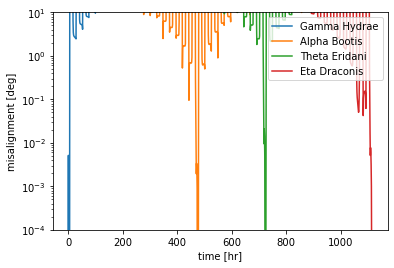

In [13]:
for ts in target_stars:
    star_ra = np.radians(star_ras[ts])
    star_dec = np.radians(star_decs[ts])
    star_dir_x = np.cos(star_dec)*np.cos(star_ra)
    star_dir_y = np.cos(star_dec)*np.sin(star_ra)
    star_dir_z = np.sin(star_dec)
    
    misalignment = np.linalg.norm(directions - [[star_dir_x, star_dir_y, star_dir_z]], axis=1)
    plt.plot(np.degrees(misalignment), label=star_names[ts])
plt.ylim((1e-4,10))
plt.yscale("log")
plt.ylabel("misalignment [deg]")
plt.xlabel("time [hr]")
plt.legend(loc=1)

### Delta-v estimates for the LGS
Finally, we plot our estimates for the delta-v required to repoint the LGS to observe the given target stars. The total delta-v in this example is 270 m/s spread over 47 days and used to repoint to 3 target stars.

Text(0, 0.5, 'delta v [m/s]')

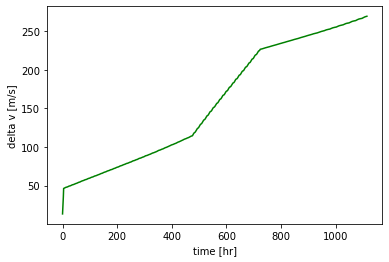

In [14]:
delta_v_lgs = np.linalg.norm(dvs_lgs, axis=1)

plt.plot(np.cumsum(delta_v_lgs), color="g")
plt.xlabel("time [hr]")
plt.ylabel("delta v [m/s]")